# Data Processiong

## Loading Data

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import seaborn as sns
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib as mpl
from wordcloud import WordCloud

In [2]:
data = pd.read_csv('data/raw_survey_data_2022.csv',header=None)

In [3]:
# with sub-questions as header
df = pd.read_csv('data/raw_survey_data_2022.csv',header=1)

## Helper function

In [4]:
def plot_3_cat(df_count):
        cmap = mpl.cm.Blues(np.linspace(0,0.9,100))
        cmap = mpl.colors.ListedColormap(cmap[10:,:-1])



        b_prob=(df_count).apply(lambda x: x / x.sum(), axis=0)
        b_prob =b_prob[(b_prob.iloc[2:,:].sum()).sort_values().index]
        aaa=(b_prob[(b_prob.iloc[2:,:].sum()).sort_values().index]).T
        bbb=b_prob.T

        fig,ax=plt.subplots(figsize=(8,6),dpi=300)
        b_prob.T.plot(kind='barh', stacked=True,colormap=cmap, figsize=(10, 6),ax=ax)
        plt.legend(['Agree','Neither agree \n nor disagree','Disagree'][::-1],bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., ncol=1)
        ax.set_xlabel("Proportion",fontsize=12)
        for n, x in enumerate([*aaa.index.values]):
            m=3
            for (proportion, count, y_loc) in zip(bbb.loc[x],
                                              aaa.loc[x],
                                              bbb.loc[x].cumsum()):

                if m<2:
                     plt.text(x=(y_loc - proportion) + (proportion / 2),
                     y=n - 0.11,
                     s=f'{str(np.round(proportion * 100)).split(".")[0]}%',
                              #s=f'{str(count).split(".")[0]}', 
                     color="white",
                     fontsize=8,
                     fontweight="bold")
                if m>=2:

                    plt.text(x=(y_loc - proportion) + (proportion / 2)-0.01,
                     y=n - 0.11,
                     s=f'{str(np.round(proportion * 100)).split(".")[0]}%',
                             #s=f'{str(count).split(".")[0]}', 
                     color="black",
                     fontsize=8,
                     fontweight="bold")
                m-=1
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)


        plt.show()
        return ax

## Data cleaning

In [5]:
# Check if there are invalid responses 
# 1. the response column is correct (most essential:If you have read the survey up to this point, please select the number four (4). By selecting number 4, you'll be entered to win one of the prizes.)
# 2. response time more than 200s

In [6]:
## Finding the response question and their column indices
data.loc[0,data.iloc[0,:].str.contains('If you have read the survey up to this point')==True].index

Int64Index([176, 306], dtype='int64')

In [7]:
## 1 response column is correct
df_1=df[(df.iloc[:,176]=='2')&(df.iloc[:,306]=='4')]

In [8]:
## 2 response time more than 200s
def response_time(df,minimum=200):
    data1=df.iloc[:,1] #DataFrame with start time
    data2=df.iloc[:,2] #DataFrame with end time
    data3=df.iloc[:,3:] #DataFrame with data

    data3["time"]=data2.apply(lambda x: datetime.strptime(x, '%m/%d/%y %H:%M'))-data1.apply(lambda x: datetime.strptime(x, '%m/%d/%y %H:%M'))
    #(data1.iloc[:,1].values.astype('datetime64[D]')-data1.iloc[:,0].values.astype('datetime64[D]'))

                                                                                                    
    index_time= data3["time"].apply(lambda x: x/np.timedelta64(1, 's'))
    data3['clean']=(index_time>200)
    cleaned_data=data3.loc[data3.clean==True].iloc[:,:-2]

    return cleaned_data
cleaned_data_text=response_time(df_1,200)

cleaned_data_text.shape

(1271, 348)

In [9]:
## change some answer to numerical
def numeric_scale(cleaned_data_text):
    cleaned_data=cleaned_data_text.copy()
    for i in range(cleaned_data.shape[0]):
        for j in range(cleaned_data.shape[1]):
            if cleaned_data.iloc[i,j] in ['Strongly agree','Strongly Agree']:
                cleaned_data.iloc[i,j]=5
            if cleaned_data.iloc[i,j]=='Agree':
                cleaned_data.iloc[i,j]=4
            if cleaned_data.iloc[i,j]in['Neither agree or disagree','Neither agree nor disagree','Neither disagree nor agree']:
                cleaned_data.iloc[i,j]=3
            if cleaned_data.iloc[i,j]=='Disagree':
                cleaned_data.iloc[i,j]=2
            if cleaned_data.iloc[i,j]=='Strongly disagree':
                cleaned_data.iloc[i,j]=1
    return cleaned_data


cleaned_data=numeric_scale(cleaned_data_text)

In [10]:
# use the same way to clean 2019 data
data_2019 = pd.read_csv('data/Copy of de-identified Graduate Student Quality of Life Survey - Spring 2019.xlsx - Graduate Student Quality of Lif.csv',header=1)
print(data_2019.shape)
cleaned_data_2019=response_time(data_2019,200)
cleaned_data_2019.shape

d2019=numeric_scale(cleaned_data_2019)

(1033, 345)


##  Basic Statistics

In [11]:
##calculating the counts of each question

In [12]:
counts=[]
for i in range(len(cleaned_data.columns)):
    counts.append(dict(cleaned_data.iloc[:,i].value_counts()))


## Creating Question Table

In [13]:
# create the table of the first 2 rows to see the questions and the columns they locate
Q=data.iloc[:2,3:].T
Q.columns=['Question','Sub_Question']
#Q['location']=[ lambda x: x.index*(x.Question.isna()==False)]
Q=Q.reset_index(drop=True)
Q['location']=np.where(Q.Question.isna()==False, Q.Question.index, "False")
Q['counts']=counts

In [14]:
# Main questions
qq=Q[Q['location']!='False']
qq=qq.reset_index(drop=True)

In [15]:
#Q.to_csv("output/Questions-22.csv", index=True)

In [16]:
pd.options.display.max_colwidth=120

In [17]:
Q.Question

0                                    I am satisfied with my overall experience at Columbia.
1      I am satisfied with the following with respect to my overall experience at Columbia.
2                                                                                       NaN
3                                                                                       NaN
4                                                                                       NaN
                                               ...                                         
343                                                                                     NaN
344                                                               What is your current age?
345                                                         Is English your first language?
346              Was English the medium of instruction in your primary or secondary school?
347           Let us know about other important matters that are not covered by 

## Find dataset for queryed text



In [18]:
##Find dataset for queryed text

def query_data(Q,qq,cleaned_data,query,indx):
    que=Q[Q['Question'].str.contains(query)==True]
    val=que.values
    ind=que.index.values
    print(Q.loc[ind[indx-1],'Question'])
    start=ind[indx-1]
    end=int(qq.iloc[qq[qq.location==str(ind[indx-1])].index+1]['location'])
    df_return=cleaned_data.iloc[:,start:end]
    return df_return



In [19]:
query_data(Q,qq,cleaned_data,"current academic department",indx=1).value_counts()

What is your current academic department or institute?


Response.3                                    
Industrial Engineering and Operations Research    314
Computer Science                                  274
Electrical Engineering                            148
Biomedical Engineering                            138
Mechanical Engineering                             95
Data Science Institute                             76
Chemical Engineering                               68
Civil Engineering and Engineering Mechanics        62
Applied Physics and Applied Mathematics            58
Earth and Environmental Engineering                29
I prefer not to answer.                             9
dtype: int64

# Initial Analysis

## 1 How Satisfied are the SEAS students

In [20]:

query="satisfied"
indx=1  # the index of quetion you want to query among all questions that contains your query text, 
        # for example: I want to know the second question involves "satisfied", the indx is 2


df_satisfied = query_data(Q,qq,cleaned_data,query,indx=1)

I am satisfied with my overall experience at Columbia.


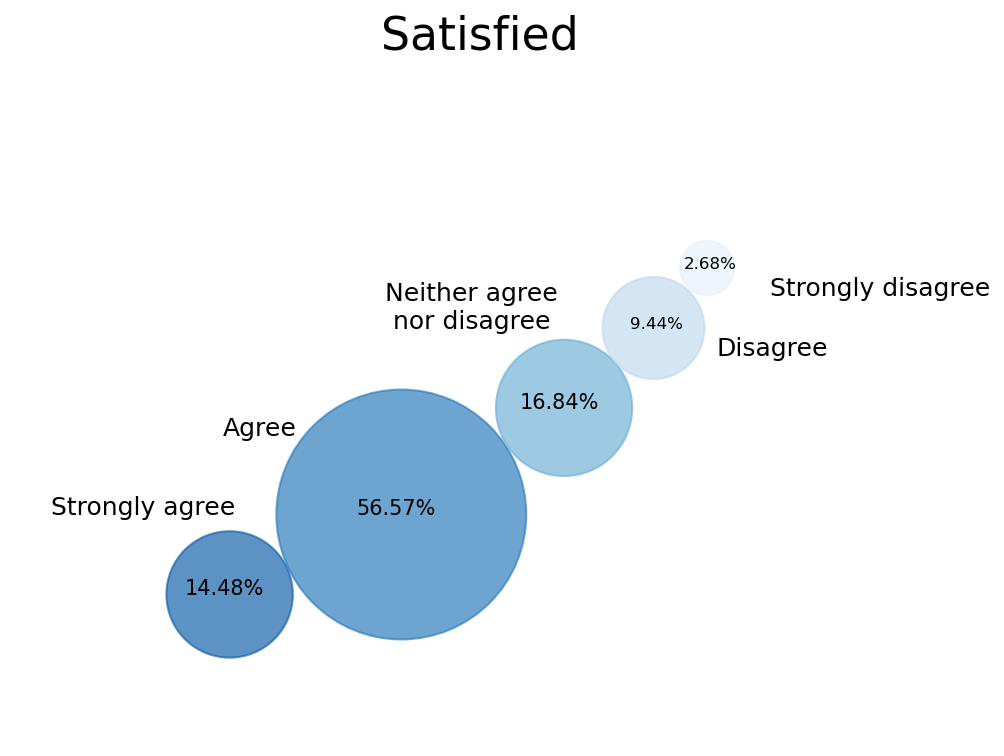

In [21]:
#cm = plt.cm.get_cmap('RdYlBu')
cmap = mpl.cm.Blues(np.linspace(0,0.8,100))
cmap = mpl.colors.ListedColormap(cmap[10:,:])


indd=['Strongly agree','Agree','Neither agree \n nor disagree','Disagree','Strongly disagree']
a=(df_satisfied.Response.value_counts()).sort_index(ascending=False)

fig,ax0=plt.subplots(figsize=(8,6),dpi=150)

# use the scatterplot function to build the bubble map
#sns.scatterplot(x=[1,2,2.5,3,3.5], y=[0.9,1.5,1.84,1.9,2.5], size=a, legend=False, sizes=(200,20000),ax=ax0)
ax0.set_xlim([-0.2, 5.0])
ax0.set_ylim([-0.10, 5.0])
x=[1,1.96,2.87,3.37,3.67]
y=[1,1.6,2.4,3,3.45]
colors=[2.8,2.5,1.9,1.3,0.8]
sc=plt.scatter(x, y,s=a*20, c=colors, cmap=cmap,  alpha=0.7)
#plt.colorbar(sc)
for i in range(3):
    ax0.annotate(indd[i],(x[i]-1,y[i]+0.6),fontsize=12)
    ax0.annotate(str(round(a[5-i]/a.sum()*100,2))+"%",(x[i]-0.25,y[i]-0))
for i in range(3,5):
    ax0.annotate(indd[i],(x[i]+0.35,y[i]-0.2),fontsize=12)
    ax0.annotate(str(round(a[5-i]/a.sum()*100,2))+"%",(x[i]-0.13,y[i]-0),fontsize=8)
ax0.set_title("Satisfied",fontsize=22)



plt.axis('off')

# show the graph
plt.show()


## 2 Importance v.s. Satisfaction

In [22]:
df_important=query_data(Q,qq,cleaned_data,"important",indx=1)

The following are important with respect to my overall experience at Columbia.


In [23]:
df_satisfied2 = query_data(Q,qq,cleaned_data,"satisfied",indx=2)

I am satisfied with the following with respect to my overall experience at Columbia.


In [24]:
a=pd.DataFrame(df_satisfied2.mean()).T
b=pd.DataFrame(df_important.mean()).T
b.columns=a.columns
c2022=pd.concat([a,b],ignore_index=True)
c2022['Year']=2022

In [25]:
aa=pd.DataFrame(df_satisfied2019.mean()).T
bb=pd.DataFrame(df_important2019.mean()).T
bb.columns=aa.columns

c2019=pd.concat([aa,bb],ignore_index=True)
c2019['Year']=2019


NameError: name 'df_satisfied2019' is not defined

In [ ]:
c2019.columns=c2022.columns
cc=pd.concat([c2019,c2022],ignore_index=True)
cc

In [ ]:
#plt.scatter(c.iloc[0,:],c.iloc[1,:])
import matplotlib.cm as cm


fig,ax=plt.subplots(figsize=(8,6),dpi=150)


colors = cm.tab20(np.linspace(0, 1, (12)))

for i in range(12):
    ax.scatter(c2022.iloc[0,i], c2022.iloc[1,i],s=90,marker='^',label=c2022.columns[i],c=colors[i].reshape(1,-1))

for i in range(12):
    ax.scatter(c2019.iloc[0,i], c2019.iloc[1,i],s=90,marker='^',facecolors='none',edgecolors=colors[i].reshape(1,-1))

line1=ax.axhline(y=c2022.iloc[1,:-1].mean(),c='grey')
ax.axvline(x=c2022.iloc[0,:-1].mean(),c='grey' )

line2=ax.axhline(y=c2019.iloc[1,:-1].mean(),c='grey',ls='--')
ax.axvline(x=c2019.iloc[0,:-1].mean(),c='grey' ,ls='--')


ax.set_xlim([3.0, 4.250])
ax.set_ylim([3.25, 4.750])


#ax.set_title("Importance vs Satisfaction for all features",fontsize=22)


#second_legend=plt.legend(c.columns,bbox_to_anchor=(1, 2.5))
#second_legend=plt.legend(c.columns,loc="upper left")

leg = plt.legend(loc=(1.05,0.4), title="Features")
ax.add_artist(leg)
#leg = plt.legend(,loc=(1.05,0.4), title="Year")


#import matplotlib.lines as mlines

import matplotlib.patches as mpatches

grey_triangle1 = ax.scatter([], [], color='grey', marker='^', linestyle='None')
grey_triangle2 = ax.scatter([], [], color='grey', marker='^', facecolors='none',edgecolors="grey",linestyle='None')

#first_legend=plt.legend([line1,line2],['2022','2019'],bbox_to_anchor=(1, 1.05))
leg1=plt.legend(handles=[line1,line2,grey_triangle1,grey_triangle2], labels=['2022 ','2019','2022 ','2019'],loc=(1.05,0.15), title="Year")
ax.add_artist(leg1)

ax.set_xlabel("Satisfaction",fontsize=14)
ax.set_ylabel("Importance",fontsize=14)
    
ax.axhline(y=c2022.iloc[1,:].mean())
ax.axvline(x=c2022.iloc[0,:].mean(),c='black' )

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)



plt.show()





## Satisfaction v.s. Importance on Academic Compared with 2019 by Department

In [26]:

df_satisfied2019=query_data(Q,qq,d2019,"satisfied",indx=2)
df_important2019=query_data(Q,qq,d2019,"important",indx=1)

I am satisfied with the following with respect to my overall experience at Columbia.
The following are important with respect to my overall experience at Columbia.


In [27]:
dep2019=query_data(Q,qq,d2019,"current academic department",indx=1).copy()
dep2019.replace('Data Science Institute', 'Data Science (MS Only)',inplace=True)
dep2019.replace('Applied Physics and Applied Mathematics','APAM',inplace=True)
dep2019.replace('Biomedical Engineering','BMEN',inplace=True)
dep2019.replace('Civil Engineering and Engineering Mechanics','CEEM',inplace=True)
dep2019.replace('Chemical Engineering','CHEN',inplace=True)
dep2019.replace('Computer Science','COMS',inplace=True)
dep2019.replace('Data Science (MS Only)','MSDS',inplace=True)
dep2019.replace('Earth and Environmental Engineering','EAEE',inplace=True)
dep2019.replace('Electrical Engineering','ELEN',inplace=True)
dep2019.replace('Industrial Engineering and Operations Research','IEOR',inplace=True)
dep2019.replace('Mechanical Engineering','MECE',inplace=True)


#degree=query_data(Q,qq,cleaned_data,'Current Academic Program',indx=1)
dfas_2019=pd.DataFrame(df_satisfied2019['Academics'])
dfai_2019=pd.DataFrame(df_important2019['Academics.1'])

dfas_2019['department']=dep2019
dfai_2019['department']=dep2019



What is your current academic department or institute?


In [28]:

dfs_2019=pd.DataFrame(dfas_2019.groupby(['department']).mean().mean(axis=1))
dfi_2019=pd.DataFrame(dfai_2019.groupby(['department']).mean().mean(axis=1))

In [29]:
df_2019=pd.concat([dfi_2019.T,dfs_2019.T])
#df_2019.rename(columns={'Data Science Institute':'Data Science (MS Only)'},inplace=True)
df_2019.drop(columns='I prefer not to answer.',inplace=True)
df_2019

department      APAM      BMEN      CEEM      CHEN      COMS      EAEE  \
0           4.535714  4.574713  4.590909  4.448980  4.606667  4.421053   
0           3.964286  3.873563  4.227273  4.020408  4.013333  4.131579   

department      ELEN      IEOR      MECE      MSDS  
0           4.672414  4.432099  4.493827  4.600000  
0           4.181034  3.806584  4.123457  3.957143

In [32]:

#degree=query_data(Q,qq,cleaned_data,'Current Academic Program',indx=1)
dfas_2022=pd.DataFrame(df_satisfied2['Academics'])
dfai_2022=pd.DataFrame(df_important['Academics.1'])
dfas_2022['department']=department
dfai_2022['department']=department
dfs_2022=

dfi_2022=pd.DataFrame(dfai_2022.groupby(['department']).mean().mean(axis=1))
df_2022=pd.concat([dfi_2022.T,dfs_2022.T])
df_2022.rename(columns={'Data Science Institute':'Data Science (MS Only)'},inplace=True)
df_2022.drop(columns='I prefer not to answer.',inplace=True)
df_2022

department      APAM      BMEN      CEEM      CHEN      COMS      EAEE  \
0           4.620690  4.572464  4.645161  4.573529  4.613139  4.517241   
0           3.931034  3.731884  4.048387  3.985294  3.930657  3.413793   

department      ELEN      IEOR      MECE      MSDS  
0           4.594595  4.579618  4.610526  4.644737  
0           3.925676  3.942675  3.821053  3.697368

In [33]:
df_2022 = df_2022[[ 'CEEM', 'APAM', 'BMEN',  'CHEN', 'COMS', 'EAEE','ELEN','IEOR', 'MECE','MSDS']]
df_2019 = df_2019[[ 'CEEM','APAM', 'BMEN', 'CHEN', 'COMS','EAEE','ELEN','IEOR', 'MECE','MSDS']]

In [34]:
#df_2019.rename(columns={'DSI':'MSDS'},inplace=True)

1
2
3
4
5
6
7
8
9


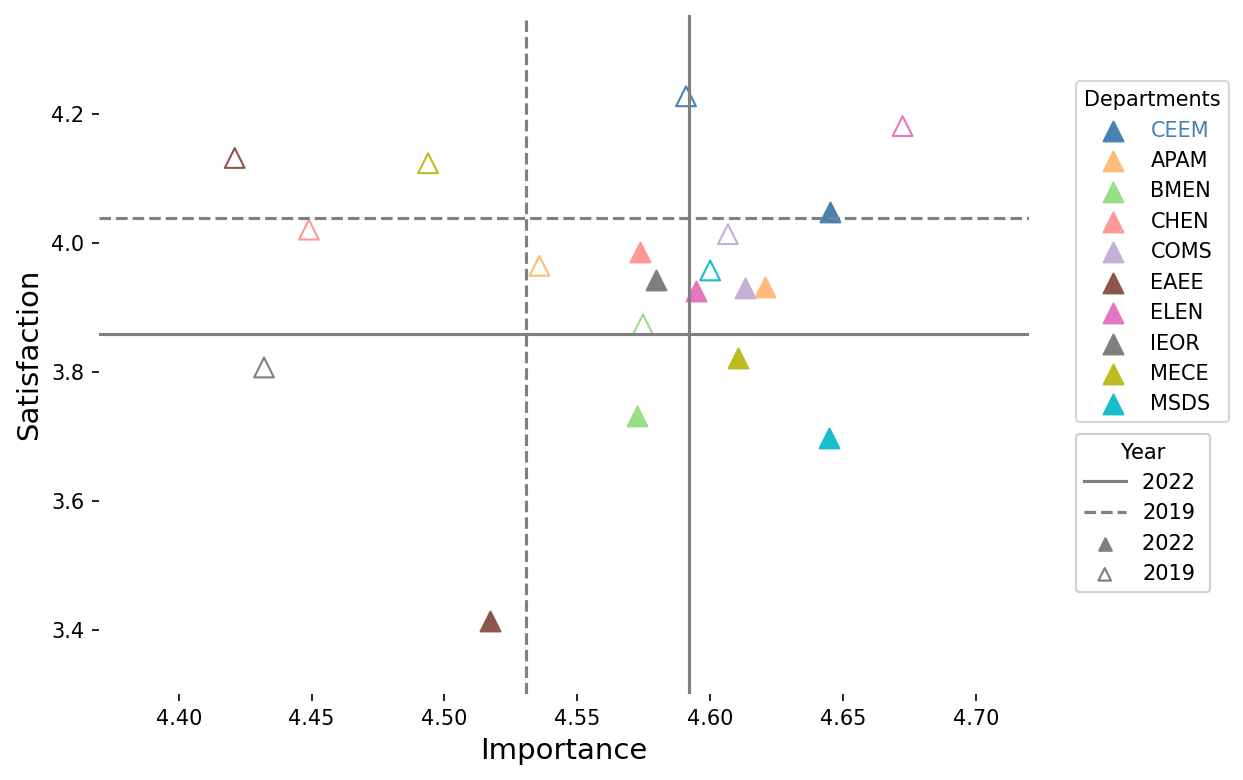

In [35]:
#plt.scatter(c.iloc[0,:],c.iloc[1,:])
import matplotlib.cm as cm


fig,ax=plt.subplots(figsize=(8,6),dpi=150)


colors = cm.tab20(np.linspace(0, 1, (12)))
ax.scatter(df_2022.iloc[0,0], df_2022.iloc[1,0],s=90,marker='^',label=df_2022.columns[0],c='steelblue')
ax.scatter(df_2019.iloc[0,0], df_2019.iloc[1,0],s=90,marker='^',facecolors='none',edgecolors='steelblue')


for i in range(1,10):
    print(i)
    ax.scatter(df_2022.iloc[0,i], df_2022.iloc[1,i],s=90,marker='^',label=df_2022.columns[i],c=colors[i+1].reshape(1,-1))

for i in range(1,10):
    ax.scatter(df_2019.iloc[0,i], df_2019.iloc[1,i],s=90,marker='^',facecolors='none',edgecolors=colors[i+1].reshape(1,-1))



    
line1=ax.axhline(y=df_2022.iloc[1,:-1].mean(),c='grey')
ax.axvline(x=df_2022.iloc[0,:-1].mean(),c='grey' )

line2=ax.axhline(y=df_2019.iloc[1,:-1].mean(),c='grey',ls='--')
ax.axvline(x=df_2019.iloc[0,:-1].mean(),c='grey' ,ls='--')


ax.set_xlim([4.370, 4.720])
ax.set_ylim([3.3, 4.3540])


#ax.set_title("Importance vs Satisfaction for all features",fontsize=22)


#second_legend=plt.legend(c.columns,bbox_to_anchor=(1, 2.5))
#second_legend=plt.legend(c.columns,loc="upper left")

leg = plt.legend(loc=(1.05,0.4), title="Departments")
ax.add_artist(leg)
#leg = plt.legend(,loc=(1.05,0.4), title="Year")

for text in leg.get_texts():
        
        plt.setp(text, color = 'steelblue')
        break

#import matplotlib.lines as mlines

import matplotlib.patches as mpatches

grey_triangle1 = ax.scatter([], [], color='grey', marker='^', linestyle='None')
grey_triangle2 = ax.scatter([], [], color='grey', marker='^', facecolors='none',edgecolors="grey",linestyle='None')

#first_legend=plt.legend([line1,line2],['2022','2019'],bbox_to_anchor=(1, 1.05))
leg1=plt.legend(handles=[line1,line2,grey_triangle1,grey_triangle2], labels=['2022 ','2019','2022 ','2019'],loc=(1.05,0.15), title="Year")
ax.add_artist(leg1)

ax.set_xlabel("Importance",fontsize=14)
ax.set_ylabel("Satisfaction",fontsize=14)


ax.axhline(y=c2022.iloc[1,:].mean())
ax.axvline(x=c2022.iloc[0,:].mean(),c='black' )

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)



plt.show()






In [300]:
text

Text(0, 0, 'APAM')

## 3 Satisfaction on other basis

In [30]:
degree=query_data(Q,qq,cleaned_data,'Current Academic Program',indx=1).copy()
department=query_data(Q,qq,cleaned_data,'current academic department',indx=1).copy()
gender=query_data(Q,qq,cleaned_data,'gender',indx=3).copy()
LGBTQ=query_data(Q,qq,cleaned_data,'LGBTQ',indx=1).copy()
ethnic=query_data(Q,qq,cleaned_data,'ethnic',indx=1).copy()
country=query_data(Q,qq,cleaned_data,'Country',indx=1).copy()
age=query_data(Q,qq,cleaned_data,'age',indx=3).copy()

Current Academic Program
What is your current academic department or institute?
Please indicate the gender(s) with which you identify (check all that apply):
Do you identify yourself as part of the LGBTQ community?
Please identify your ethnic background.
Country of Origin
What is your current age?


In [31]:
department.replace('Data Science Institute', 'Data Science (MS Only)',inplace=True)
department.replace('Applied Physics and Applied Mathematics','APAM',inplace=True)
department.replace('Biomedical Engineering','BMEN',inplace=True)
department.replace('Civil Engineering and Engineering Mechanics','CEEM',inplace=True)
department.replace('Chemical Engineering','CHEN',inplace=True)
department.replace('Computer Science','COMS',inplace=True)
department.replace('Data Science (MS Only)','MSDS',inplace=True)
department.replace('Earth and Environmental Engineering','EAEE',inplace=True)
department.replace('Electrical Engineering','ELEN',inplace=True)
department.replace('Industrial Engineering and Operations Research','IEOR',inplace=True)
department.replace('Mechanical Engineering','MECE',inplace=True)


In [103]:
inddf=['Strongly agree','Agree','Neither agree \n nor disagree','Disagree','Strongly disagree','Not Applicable']

## 3.1 Satisfation by Gender

posx and posy should be finite values
posx and posy should be finite values


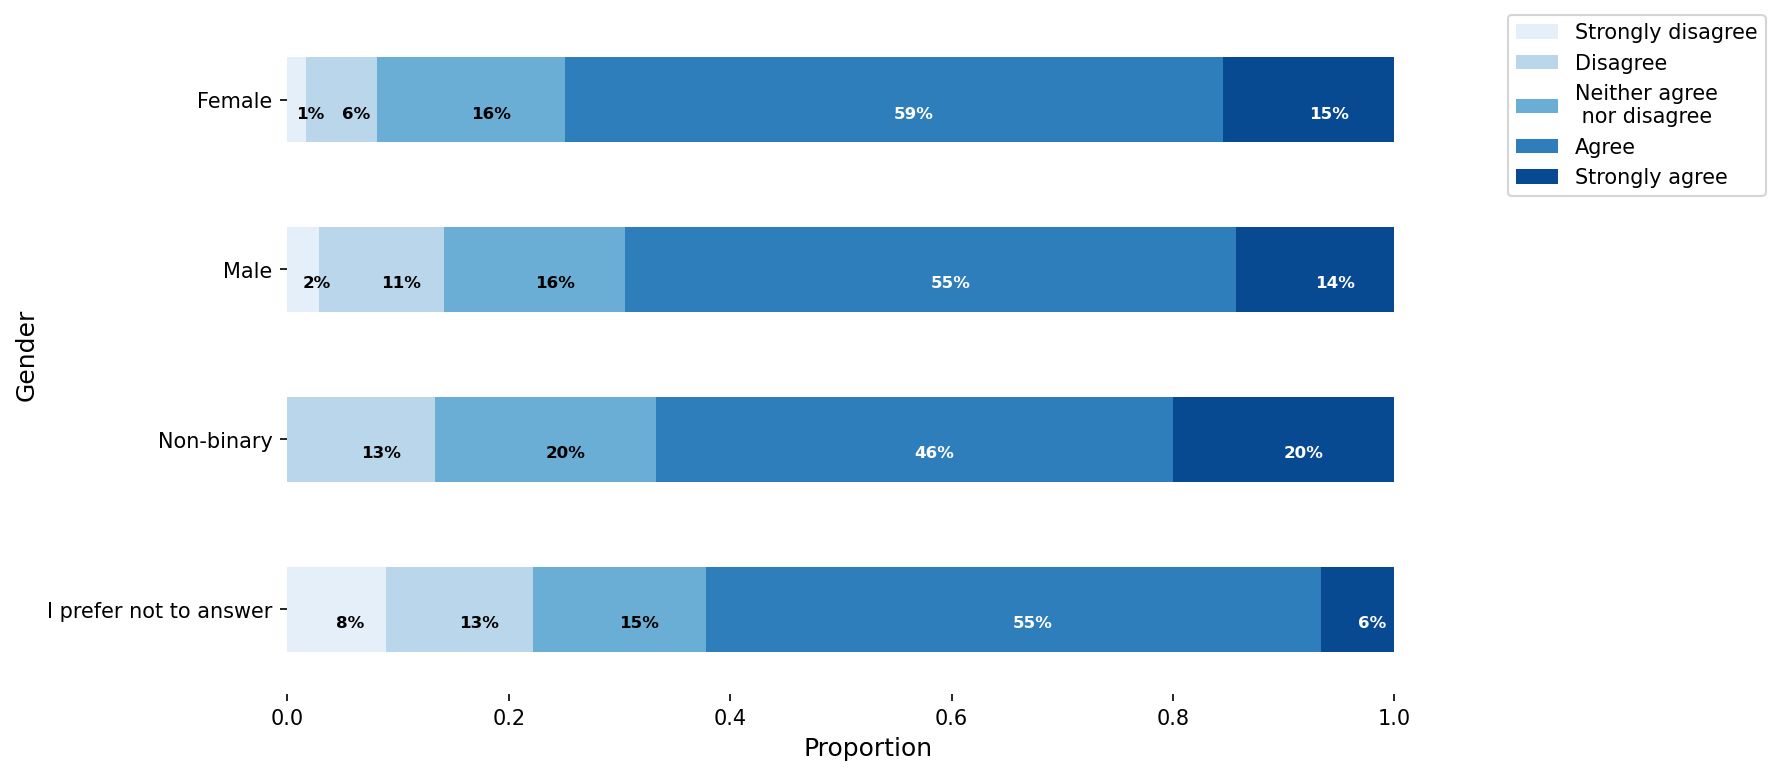

In [104]:
#cm = plt.cm.get_cmap('RdYlBu')
cmap = mpl.cm.Blues(np.linspace(0,0.9,100))
cmap = mpl.colors.ListedColormap(cmap[10:,:-1])


df_satisfied_gender=df_satisfied.copy()
df_satisfied_gender=df_satisfied_gender.join(gender)

#gender_c=['Female','Male','Response','Non-binary','Do not identify as female, male, or non-binary','I prefer not to answer','Prefer to self-describe']
gender_c=['Female','Male','Response','Non-binary','I prefer not to answer']


b=pd.DataFrame(columns=gender_c) 
for i in gender_c:
    data_used=df_satisfied_gender.loc[df_satisfied_gender[i].isna()!=True,'Response']
    b[i]=(pd.DataFrame(data_used.value_counts()).fillna(0)/pd.DataFrame(data_used).count(axis=0)*100)
    #print(pd.DataFrame(data_used).count(axis=0))  
 #b.append(a)

#b=b[b.columns[::-1]]
#b=b[['Female', 'Male', 'Non-binary','I prefer not to answer', 'Prefer to self-describe','Do not identify as female, male, or non-binary'][::-1]]
b=b[['Female', 'Male', 'Non-binary','I prefer not to answer'][::-1]]


b_prob=b.apply(lambda x: x / x.sum(), axis=0)
aaa=b.sort_index().T
bbb=b_prob.sort_index().T


fig,ax=plt.subplots(figsize=(8,6),dpi=150)
b_prob.sort_index().T.plot(kind='barh', stacked=True,colormap=cmap, figsize=(10, 6),label=b.T.columns,ax=ax)
#pd.DataFrame(b) 
plt.legend(inddf[:-1][::-1],bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., ncol=1)

#df3_1_cafe_count.index.name = 'rate'
#df3_1_cafe_count.columns.name = 'features'

plt.ylabel("Gender",fontsize=12)
plt.xlabel("Proportion",fontsize=12)
#plt.title("Overall Student Satisfaction: by Gender",fontsize=20)


for n, x in enumerate([*aaa.index.values]):
    m=5
    for (proportion, count, y_loc) in zip(bbb.loc[x],
                                          aaa.loc[x],
                                          bbb.loc[x].cumsum()):
        
        if m<3:
                 plt.text(x=(y_loc - proportion) + (proportion / 2),
                 y=n - 0.11,
                 s=f'{str(count).split(".")[0]}%', 
                 color="white",
                 fontsize=8,
                 fontweight="bold")
        if m>=3:
                plt.text(x=(y_loc - proportion) + (proportion / 2),
                 y=n - 0.11,
                 s=f'{str(count).split(".")[0]}%', 
                 color="black",
                 fontsize=8,
                 fontweight="bold")
        m-=1
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)


plt.show()

## 3.2 Satisfaction By Degree

In [41]:
df_satisfied_degree=df_satisfied.copy()
df_satisfied_degree['degree']=degree
df_satisfied_degree['num']=1
dff=df_satisfied_degree.groupby(['degree','Response']).count().unstack('degree')
df_degree=dff['num']#/dfff.sum(axis=0)
#dff.to_csv("output/df_satisfied_degree.csv")
#df_degree=dff['num'].drop(columns='Professional Degree')
df_degree=df_degree.fillna(0)
#df_satisfied_degrea['Response']=df_satisfied_degree.Response.astype(int)
inner=df_satisfied_degree.groupby(['degree','Response']).sum()
outer = df_satisfied_degree.groupby('degree').sum()
outer

num
degree                           
Doctor of Philosophy (Ph.D.)  208
M.S. leading to Ph.D.          74
Master of Science (M.S.)      988
Professional Degree             1

In [54]:
print(df_satisfied_degree[df_satisfied_degree.degree=='Doctor of Philosophy (Ph.D.)'].mean())
print(df_satisfied_degree[df_satisfied_degree.degree=='M.S. leading to Ph.D.'].mean())
print(df_satisfied_degree[df_satisfied_degree.degree=='Master of Science (M.S.)'].mean())

Response    3.682692
num         1.000000
dtype: float64
Response    3.810811
num         1.000000
dtype: float64
Response    3.703441
num         1.000000
dtype: float64


/var/folders/_r/5vgvtlc95cvfjt0qzlww6hhm0000gn/T/ipykernel_69407/1797240537.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  print(df_satisfied_degree[df_satisfied_degree.degree=='Doctor of Philosophy (Ph.D.)'].mean())
/var/folders/_r/5vgvtlc95cvfjt0qzlww6hhm0000gn/T/ipykernel_69407/1797240537.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  print(df_satisfied_degree[df_satisfied_degree.degree=='M.S. leading to Ph.D.'].mean())
/var/folders/_r/5vgvtlc95cvfjt0qzlww6hhm0000gn/T/ipykernel_69407/1797240537.py:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will r

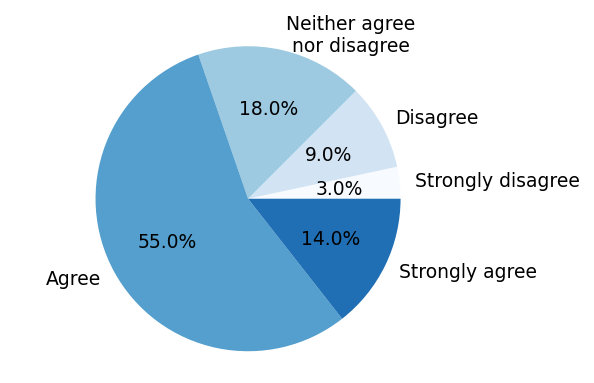

In [65]:
# Create a pieplot
indd=['Strongly agree','Agree','Neither agree \n nor disagree','Disagree','Strongly disagree']


fig,ax=plt.subplots(figsize=(4,3),dpi=150)
#plt.pie(np.array(df_degree.iloc[:,0]),color=cmap)
cmap = mpl.cm.Blues(np.linspace(0,1.7,10))
#cmap = mpl.colors.ListedColormap(cmap[10:,:-1])

explode = (0, 0, 0, 0,0) 
_, _, autotexts =ax.pie(df_degree['Doctor of Philosophy (Ph.D.)'], explode=explode, labels=indd[::-1], autopct=lambda p: '{:.1f}%'.format(round(p)) if p > 0 else '',colors=cmap,
        shadow=False,textprops={'fontsize':9})
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()


posx and posy should be finite values
posx and posy should be finite values


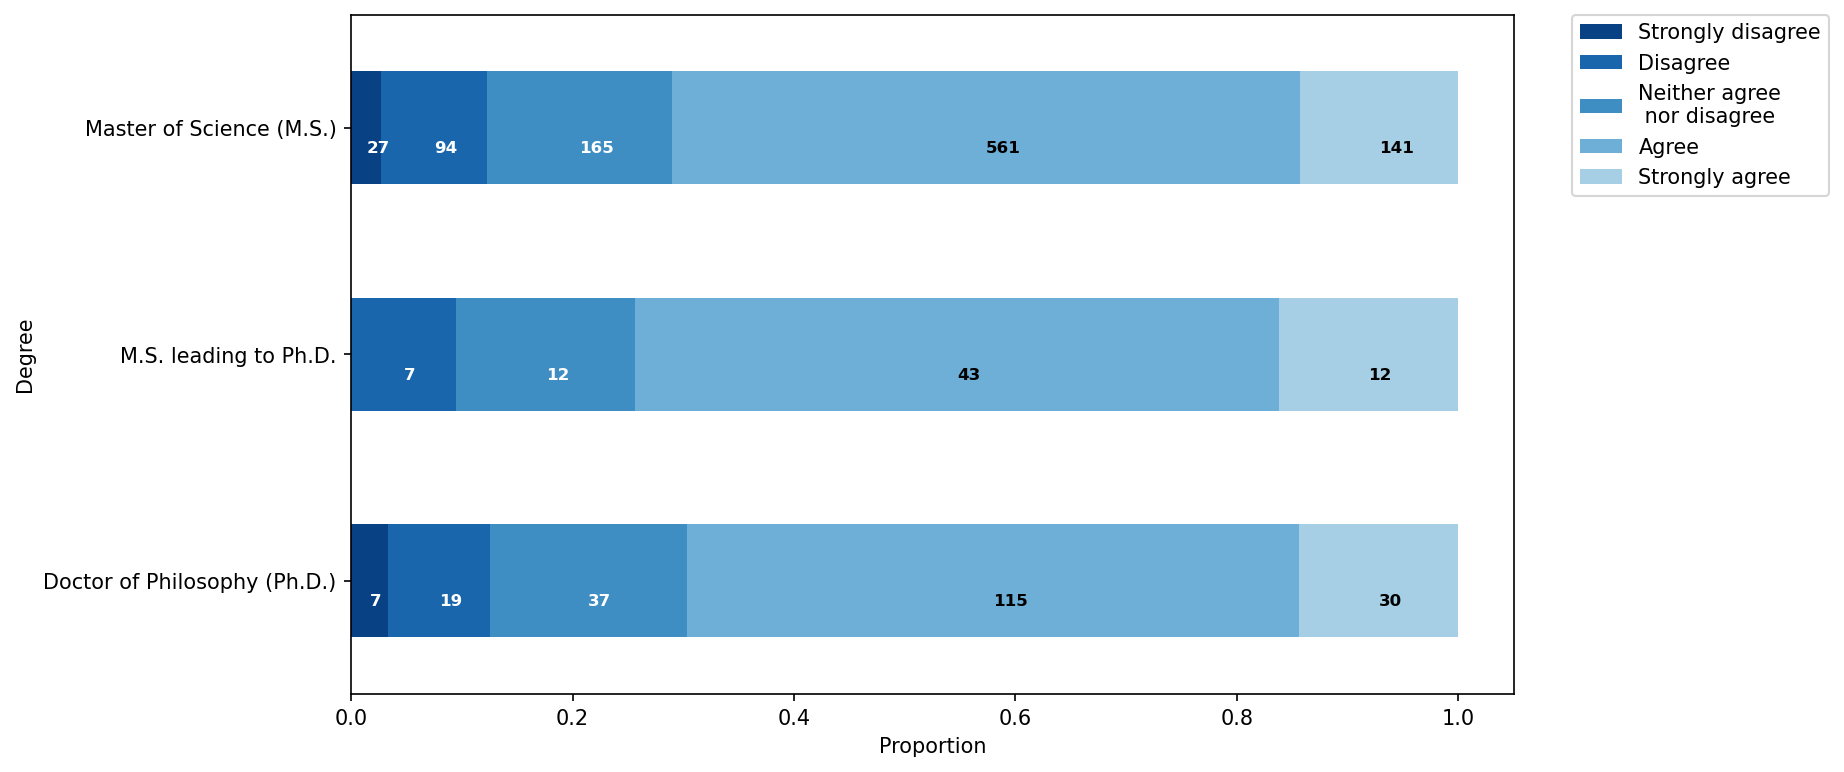

In [142]:
#cm = plt.cm.get_cmap('RdYlBu')
cmap = mpl.cm.Blues_r(np.linspace(0,0.65,100))
cmap = mpl.colors.ListedColormap(cmap[10:,:-1])


b_prob=df_degree.apply(lambda x: x / x.sum(), axis=0)
aaa=df_degree.T
bbb=b_prob.sort_index().T


fig,ax=plt.subplots(figsize=(8,6),dpi=150)
b_prob.sort_index().T.plot(kind='barh', stacked=True,colormap=cmap, figsize=(10, 6),label=b.T.columns,ax=ax)
#pd.DataFrame(b) 
plt.legend(indd[::-1],bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., ncol=1)

#df3_1_cafe_count.index.name = 'rate'
#df3_1_cafe_count.columns.name = 'features'

plt.ylabel("Degree")
plt.xlabel("Proportion")
#plt.title("Overall Student Satisfaction: by Degree",fontsize=20)


for n, x in enumerate([*aaa.index.values]):
    m=5
    for (proportion, count, y_loc) in zip(bbb.loc[x],
                                          aaa.loc[x],
                                          bbb.loc[x].cumsum()):
        
        if m<3:
                 plt.text(x=(y_loc - proportion) + (proportion / 2),
                 y=n - 0.11,
                 s=f'{str(count).split(".")[0]}', 
                 color="black",
                 fontsize=8,
                 fontweight="bold")
        if m>=3:
                plt.text(x=(y_loc - proportion) + (proportion / 2),
                 y=n - 0.11,
                 s=f'{str(count).split(".")[0]}', 
                 color="white",
                 fontsize=8,
                 fontweight="bold")
        m-=1
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)


plt.show()

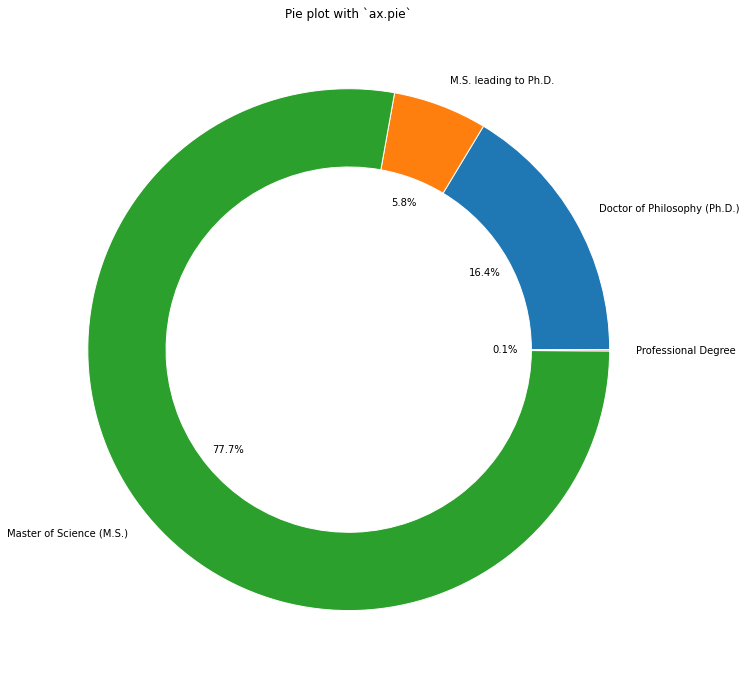

In [335]:
fig, ax = plt.subplots(figsize=(24,12))
size = 0.3

ax.pie(outer.values.flatten(), radius=1,
       labels=outer.index,
       autopct='%1.1f%%',
       wedgeprops=dict(width=size, edgecolor='w'))

#ax.pie(inner.values.flatten(), radius=1-size, 
#       labels = inner_labels,
#       wedgeprops=dict(width=size, edgecolor='w'),colors=cmap)

ax.set(aspect="equal", title='Pie plot with `ax.pie`')
plt.show()

## 3.3 Satisfaction by Department

In [85]:
(b_prob.iloc[3:,:].sum()).sort_values()

department
I prefer not to answer.                           0.555556
Earth and Environmental Engineering               0.586207
Computer Science                                  0.664234
Data Science (MS Only)                            0.697368
Industrial Engineering and Operations Research    0.700637
Electrical Engineering                            0.709459
Biomedical Engineering                            0.739130
Applied Physics and Applied Mathematics           0.741379
Mechanical Engineering                            0.747368
Civil Engineering and Engineering Mechanics       0.790323
Chemical Engineering                              0.823529
dtype: float64

In [87]:
b_prob[(b_prob.iloc[3:,:].sum()).sort_values().index]

department  I prefer not to answer.  Earth and Environmental Engineering  \
Response                                                                   
1                               NaN                             0.068966   
2                          0.222222                             0.172414   
3                          0.222222                             0.172414   
4                          0.333333                             0.413793   
5                          0.222222                             0.172414   

department  Computer Science  Data Science (MS Only)  \
Response                                               
1                   0.032847                0.039474   
2                   0.116788                0.131579   
3                   0.186131                0.131579   
4                   0.547445                0.605263   
5                   0.116788                0.092105   

department  Industrial Engineering and Operations Research  \
Response                                                     
1                                                 0.015924   
2                                                 0.105096   
3                                                 0.178344   
4                                                 0.566879   
5                                                 0.133758   

department  Electrical Engineering  Biomedical Engineering  \
Response                                                     
1                         0.027027                0.036232   
2                         0.074324                0.065217   
3                         0.189189                0.159420   
4                         0.527027                0.579710   
5                         0.182432                0.159420   

department  Applied Physics and Applied Mathematics  Mechanical Engineering  \
Response                                                                      
1                                          0.034483                0.010526   
2                                          0.086207                0.073684   
3                                          0.137931                0.168421   
4                                          0.637931                0.621053   
5                                          0.103448                0.126316   

department  Civil Engineering and Engineering Mechanics  Chemical Engineering  
Response                                                                       
1                                              0.032258              0.014706  
2                                              0.048387              0.044118  
3                                              0.129032              0.117647  
4                                              0.580645              0.588235  
5                                              0.209677              0.235294

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


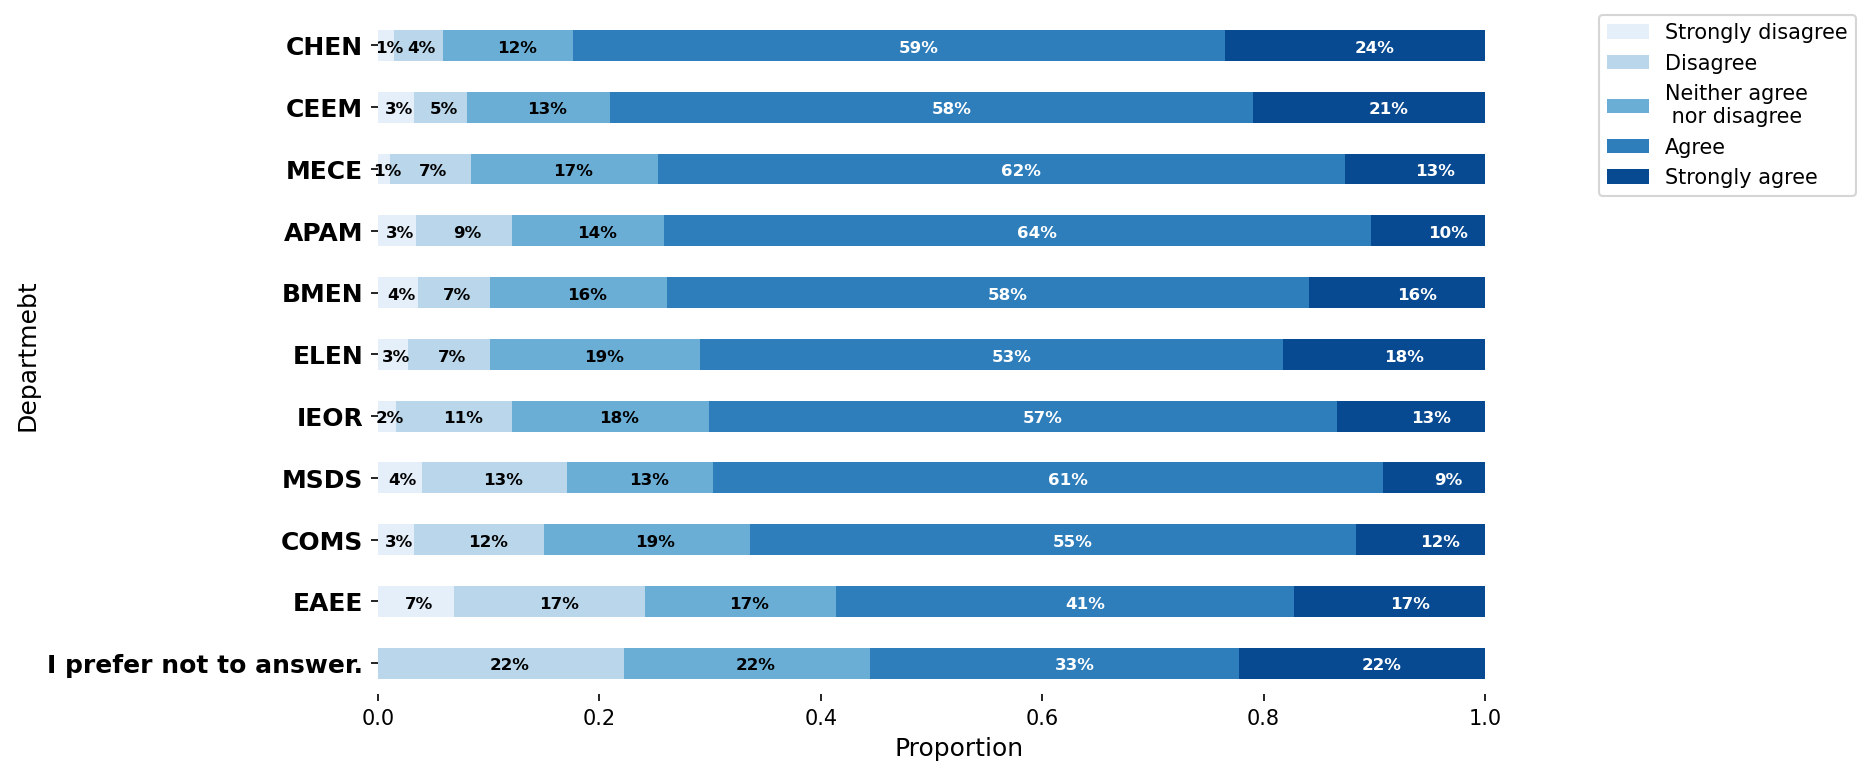

In [351]:
#cmap = mpl.cm.Blues(np.linspace(0,0.9,100))
#cmap = mpl.colors.ListedColormap(cmap[10:,:-1])

df_satisfied_department=df_satisfied.copy()
df_satisfied_department['department']=department
df_satisfied_department['num']=1
b=df_satisfied_department.groupby(['department','Response']).count().unstack('department').num
#/dfff.sum(axis=0)
indd=['Strongly agree','Agree','Neither agree \n nor disagree','Disagree','Strongly disagree']


#cm = plt.cm.get_cmap('RdYlBu')
#b=b_prob[(b_prob.iloc[4:,:].sum()).sort_values().index]
b_prob=b.apply(lambda x: x / x.sum(), axis=0)
aaa=b[(b_prob.iloc[3:,:].sum()).sort_values().index].T
bbb=b_prob[(b_prob.iloc[3:,:].sum()).sort_values().index].T


fig,ax=plt.subplots(figsize=(8,6),dpi=150)
bbb.plot(kind='barh', stacked=True,colormap=cmap, figsize=(10, 6),label=b.T.columns,ax=ax)
#pd.DataFrame(b) 
plt.legend(indd[::-1],bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., ncol=1)

#df3_1_cafe_count.index.name = 'rate'
#df3_1_cafe_count.columns.name = 'features'

plt.ylabel("Departmebt",fontsize=12)
plt.xlabel("Proportion",fontsize=12)
#plt.title("Overall Student Satisfaction: by Gender",fontsize=20)

plt.yticks(fontsize=12,fontweight="bold")

for n, x in enumerate([*aaa.index.values]):
    m=5
    for (proportion, count, y_loc) in zip(bbb.loc[x],
                                          aaa.loc[x],
                                          bbb.loc[x].cumsum()):
        
        if m<3:
                 plt.text(x=(y_loc - proportion) + (proportion / 2),
                 y=n - 0.11,
                 s=f'{str(np.round(proportion * 100)).split(".")[0]}%',
                          #s=f'{str(count).split(".")[0]}', 
                 color="white",
                 fontsize=8,
                 fontweight="bold")
        if m>=3:
                plt.text(x=(y_loc - proportion) + (proportion / 2)-0.01,
                 y=n - 0.11,
                 s=f'{str(np.round(proportion * 100)).split(".")[0]}%',
                         #s=f'{str(count).split(".")[0]}', 
                 color="black",
                 fontsize=8,
                 fontweight="bold")
        m-=1
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)



plt.savefig('output/sat_new_2022.png', bbox_inches='tight')
plt.show()

## 4 Academics


In [92]:
aca_import=query_data(Q,qq,cleaned_data,"academics",indx=1)


The following are important with respect to my overall satisfaction with SEAS classes and academics.


In [107]:
aca_import[aca_import.mean().sort_values().index].mean()

/var/folders/_r/5vgvtlc95cvfjt0qzlww6hhm0000gn/T/ipykernel_62112/2793828889.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  aca_import[aca_import.mean().sort_values().index].mean()


Supplementary educational tools    3.906373
Degree requirements                4.009441
Course Delivery Method             4.226593
Instruction                        4.366640
Course content                     4.408340
dtype: float64

/var/folders/_r/5vgvtlc95cvfjt0qzlww6hhm0000gn/T/ipykernel_62112/1405561428.py:7: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df=pd.DataFrame((aca_import[aca_import.mean().sort_values().index[::-1]].mean()))


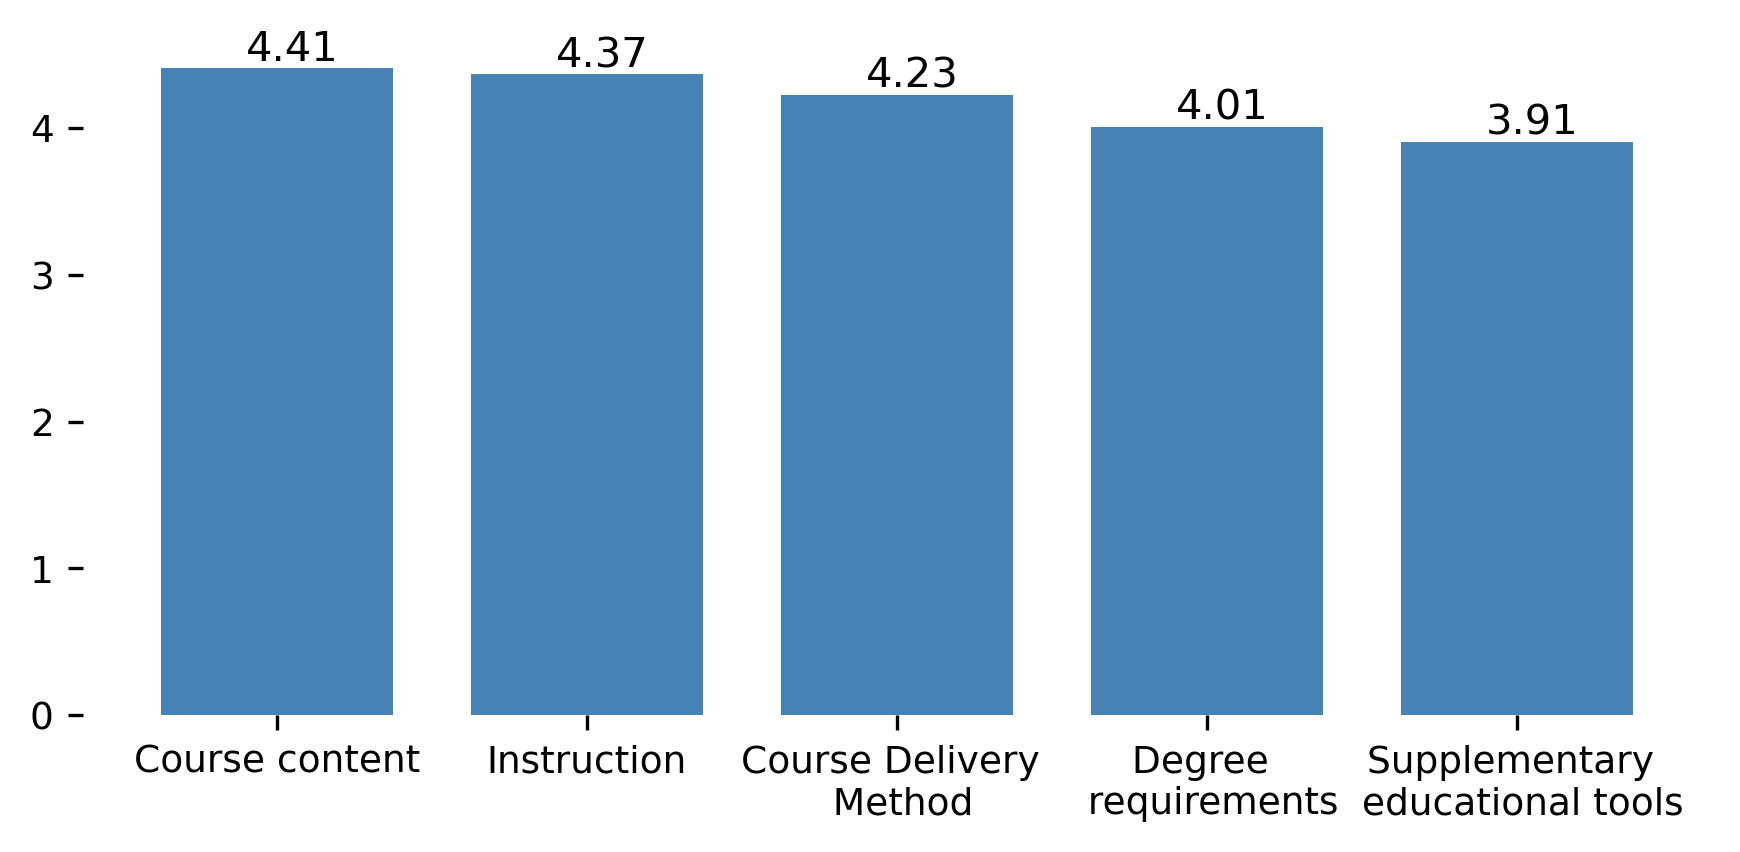

In [118]:


fig,ax=plt.subplots(figsize=(7,3),dpi=300)
#aca_import['degree']=degree
#df=aca_import.groupby(['degree']).mean().drop(index='Professional Degree')
#df=df[df.sum().sort_values().index]
indd=['Supplementary \n educational tools', 'Degree \n requirements',
       'Course Delivery \n Method', 'Instruction', 'Course content']
df=pd.DataFrame((aca_import[aca_import.mean().sort_values().index[::-1]].mean()))
ax=df.plot.bar(ax=ax,color='steelblue',width=0.75, rot=0 ,fontsize=9,legend=None)
#ax=plt.bar(np.arange(0,5,1),(aca_import[aca_import.mean().sort_values().index[::-1]].mean()),color='steelblue',width=0.75)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)


ax.set_xticklabels(indd[::-1], rotation=0,)
x_offset = -0.1
y_offset = 0.05
for p in ax.patches:
    b = p.get_bbox()
    val = "{:.2f}".format(b.y1 + b.y0)        
    ax.annotate(val, ((b.x0 + b.x1)/2+ x_offset, b.y1+y_offset),fontsize=10)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)



/var/folders/_r/5vgvtlc95cvfjt0qzlww6hhm0000gn/T/ipykernel_62112/2376935726.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aca_import['degree']=degree


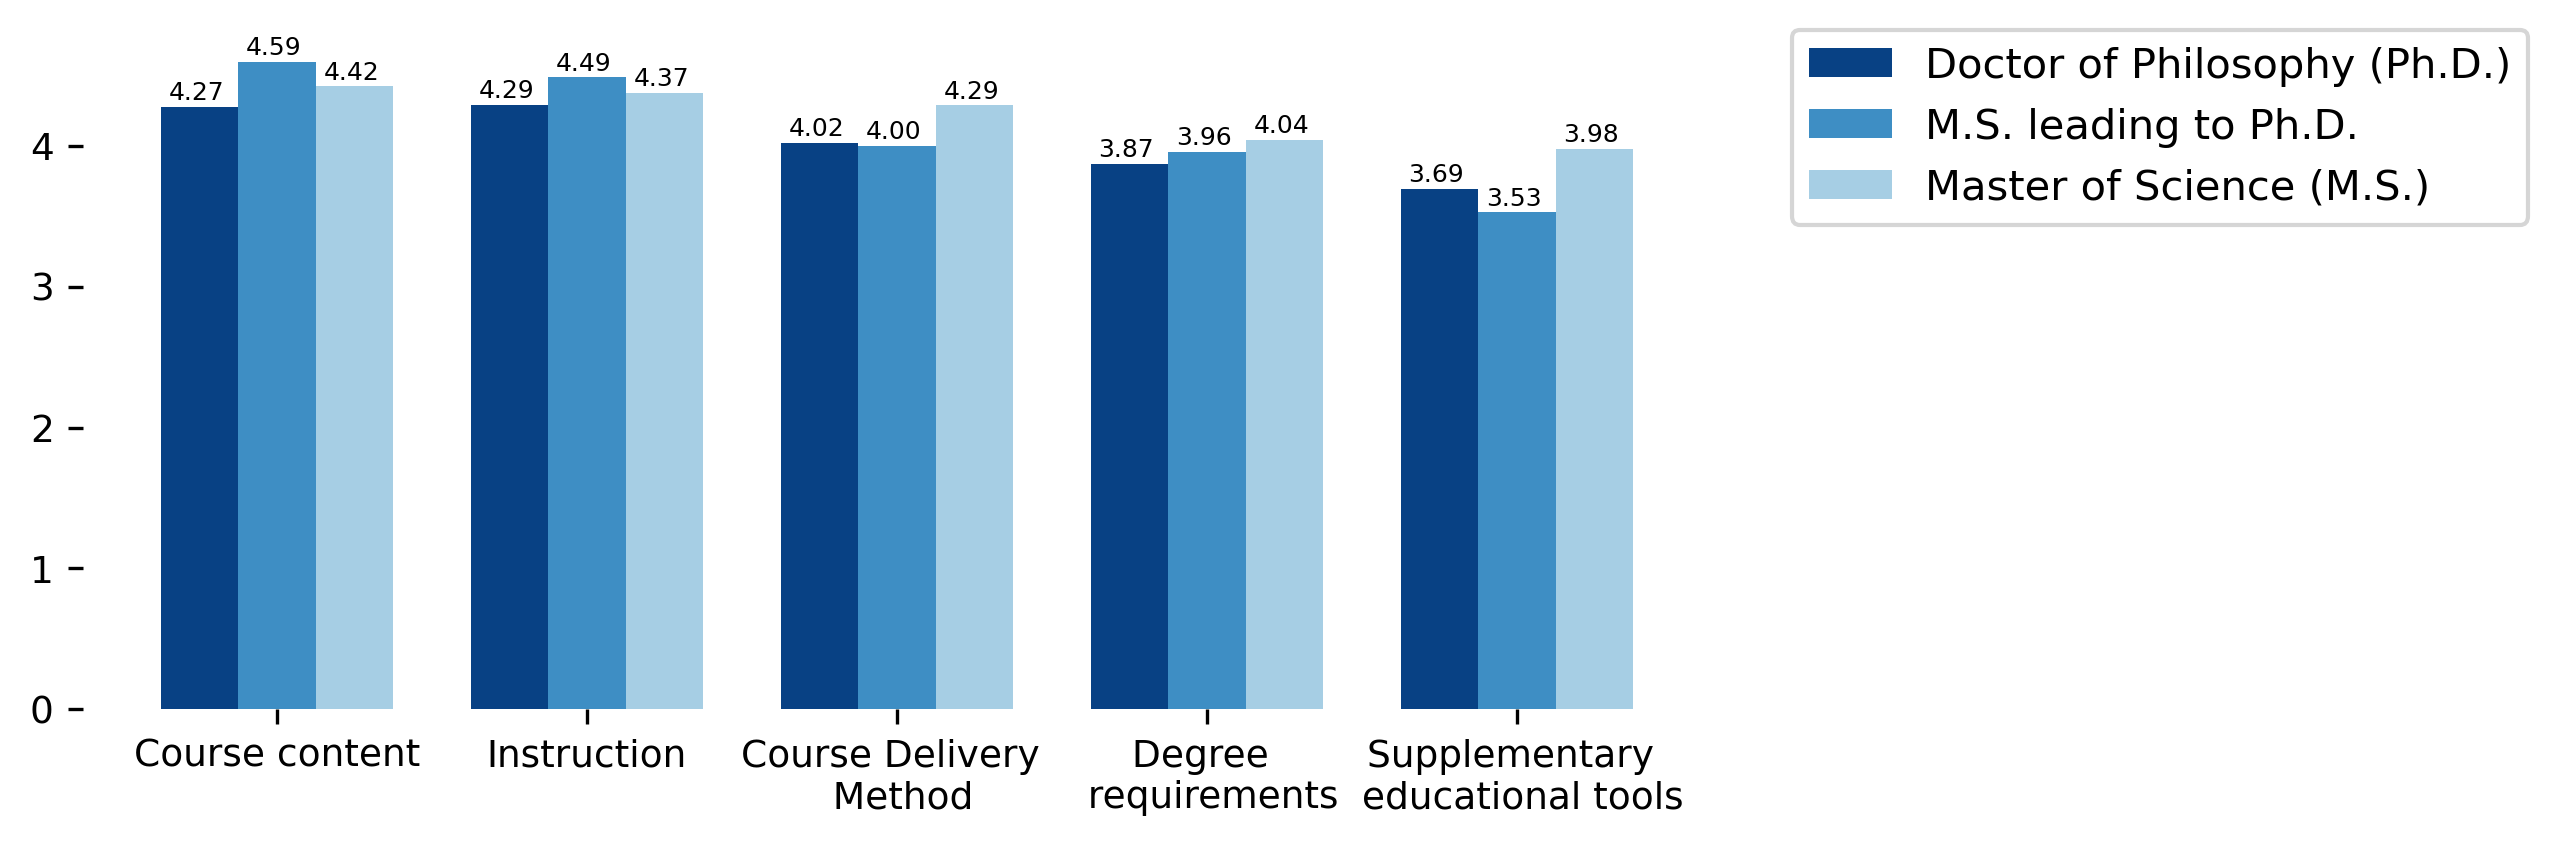

In [131]:
cmapr = mpl.cm.Blues_r(np.linspace(0,0.65,100))
cmapr = mpl.colors.ListedColormap(cmapr[10:,:-1])


fig,ax=plt.subplots(figsize=(7,3),dpi=300)
aca_import['degree']=degree
df=aca_import.groupby(['degree']).mean().drop(index='Professional Degree')
df=df[df.sum().sort_values().index[::-1]]
indd=['Supplementary \n educational tools', 'Degree \n requirements',
       'Course Delivery \n Method', 'Instruction', 'Course content']
ax=df.T.plot.bar(ax=ax,colormap=cmapr,width=0.75, rot=0 ,fontsize=9)
ax.set_xticklabels(indd[::-1], rotation=0,)
x_offset = -0.1
y_offset = 0.05
for p in ax.patches:
    b = p.get_bbox()
    val = "{:.2f}".format(b.y1 + b.y0)        
    ax.annotate(val, ((b.x0 + b.x1)/2+ x_offset, b.y1+y_offset),fontsize=6)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)



plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., ncol=1)

In [176]:
aca=query_data(Q,qq,cleaned_data,"academics",indx=2)

Please answer the following with respect to SEAS classes and academics.


In [356]:
aca1=pd.DataFrame(aca['The overall teaching quality of the lecturer was satisfactory:'].replace('Not Applicable',0))
aca1['department']=department
aca1['degree']=degree
#aca1['num']=1
aca1['The overall teaching quality of the lecturer was satisfactory:'].replace(4,5,inplace=True)
aca1['The overall teaching quality of the lecturer was satisfactory:'].replace(2,1,inplace=True)


In [357]:
daca1=aca1.groupby(['department','The overall teaching quality of the lecturer was satisfactory:']).count().unstack('department').degree
daca1.drop(index=0,columns='I prefer not to answer.',inplace=True)

In [358]:
daca1

department                                                      APAM   BMEN  \
The overall teaching quality of the lecturer was satisfactory:                
1                                                                3.0   15.0   
3                                                                9.0   18.0   
5                                                               46.0  103.0   

department                                                      CEEM  CHEN  \
The overall teaching quality of the lecturer was satisfactory:               
1                                                                4.0   4.0   
3                                                               11.0  15.0   
5                                                               47.0  49.0   

department                                                       COMS  EAEE  \
The overall teaching quality of the lecturer was satisfactory:                
1                                                                16.0   6.0   
3                                                                37.0   4.0   
5                                                               214.0  19.0   

department                                                       ELEN   IEOR  \
The overall teaching quality of the lecturer was satisfactory:                 
1                                                                15.0   31.0   
3                                                                20.0   29.0   
5                                                               109.0  251.0   

department                                                      MECE  MSDS  
The overall teaching quality of the lecturer was satisfactory:              
1                                                               11.0  13.0  
3                                                                4.0  10.0  
5                                                               78.0  53.0

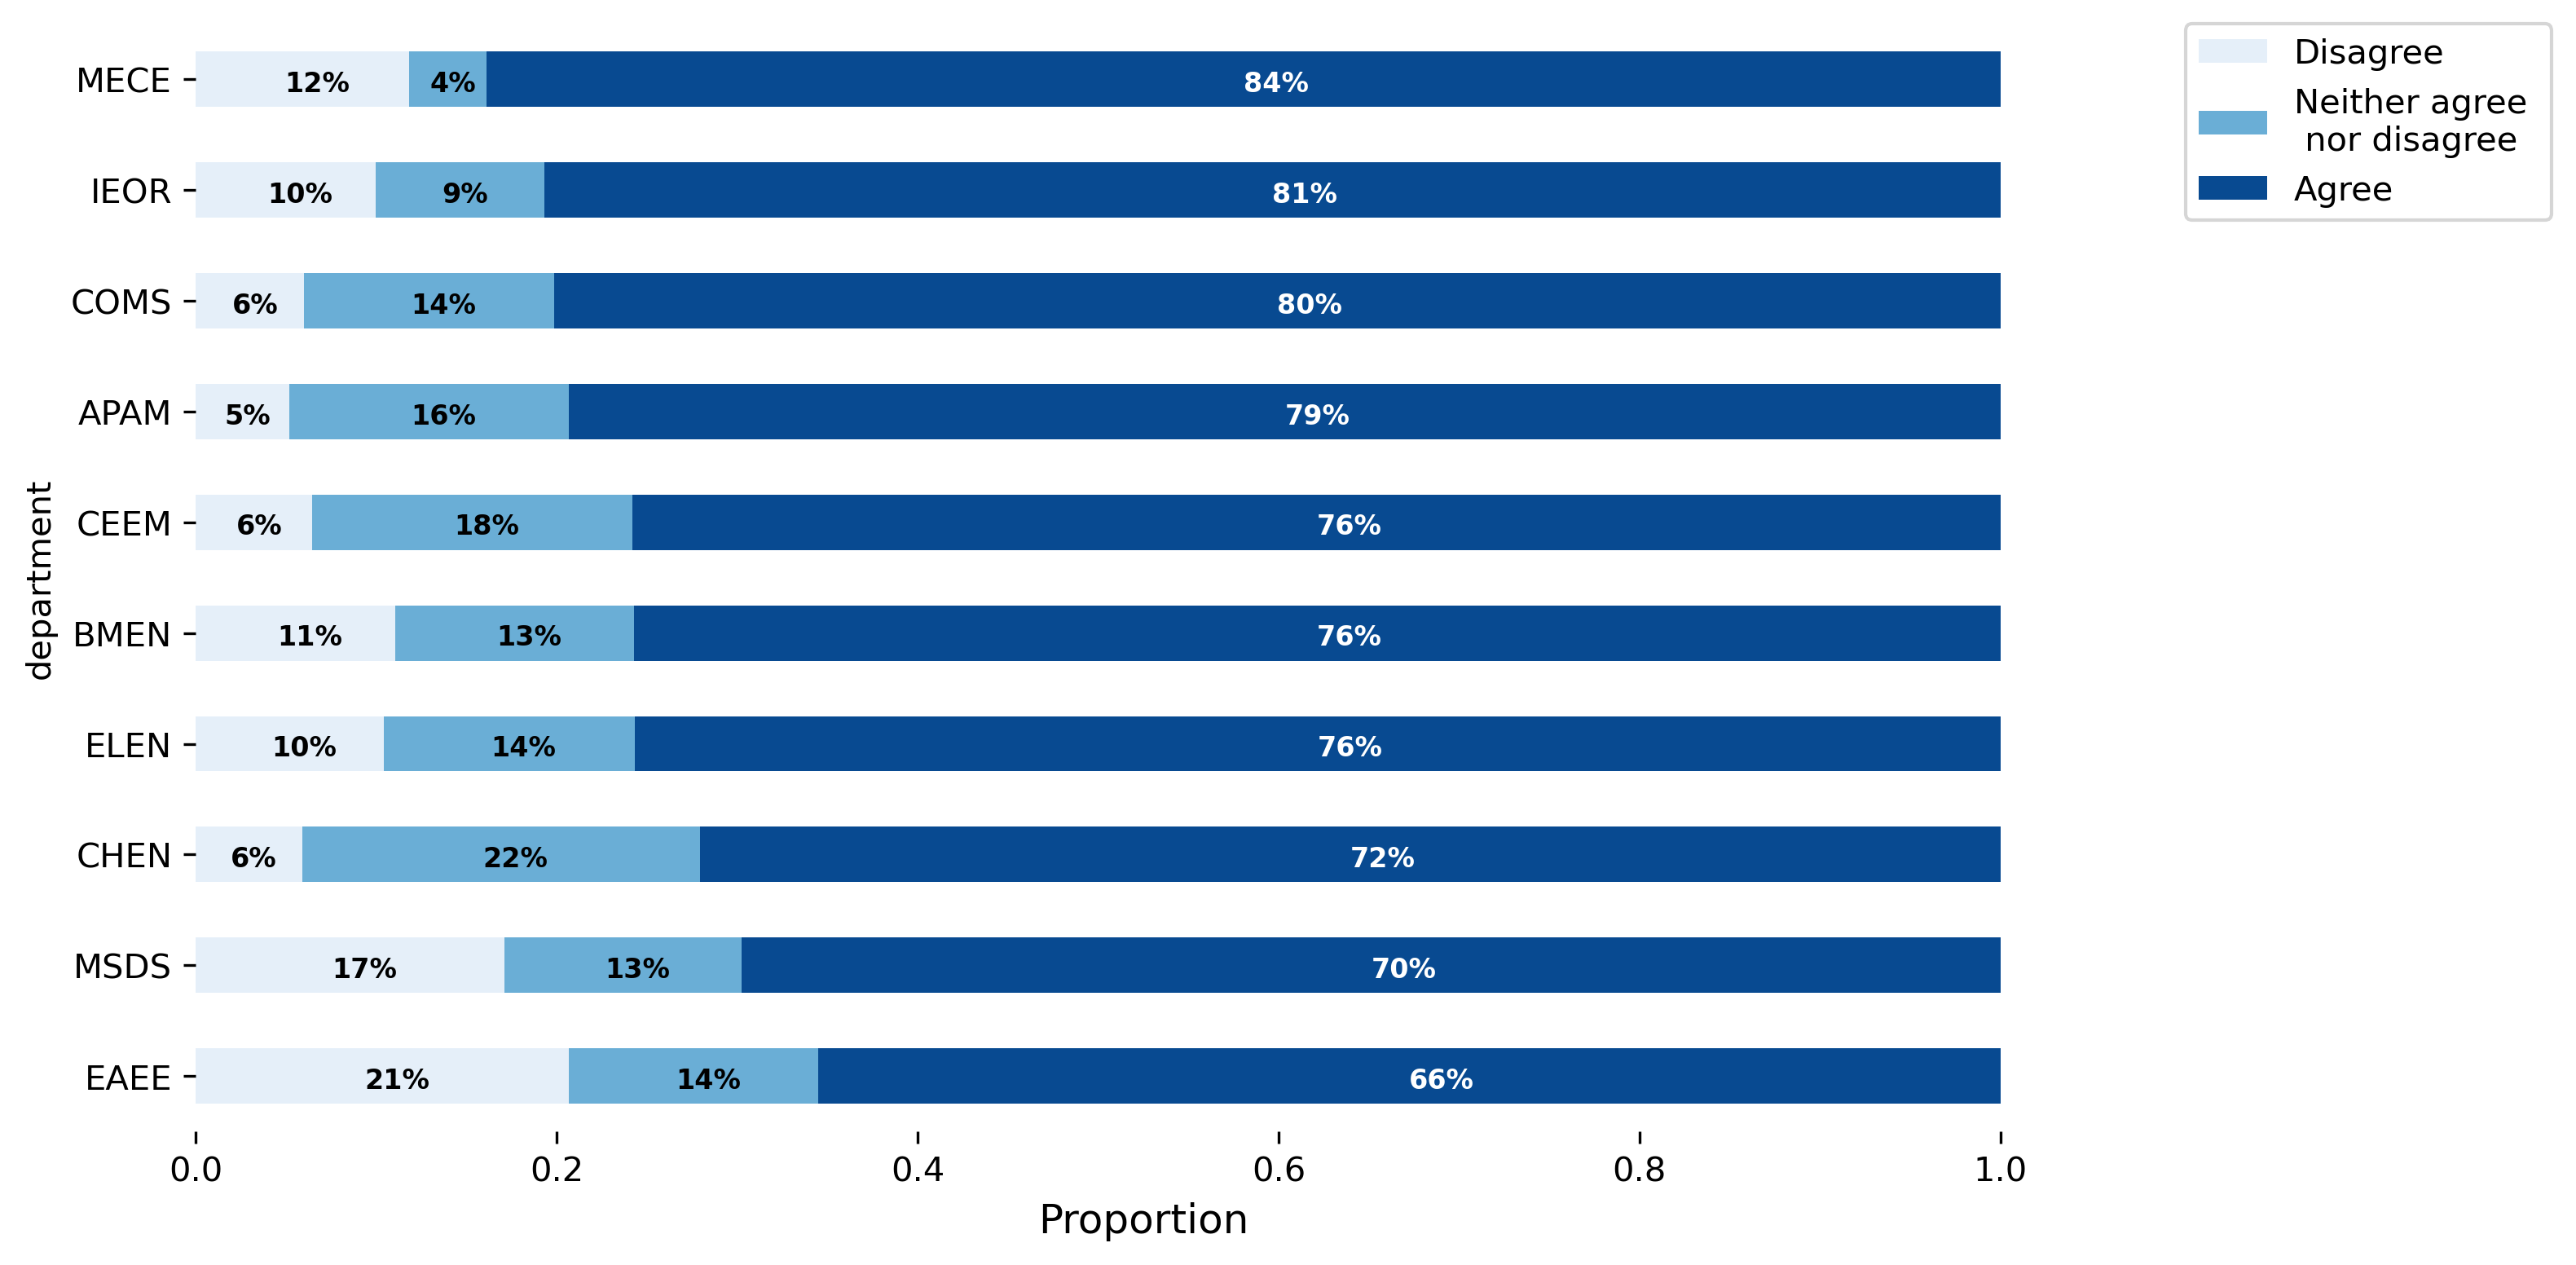

<AxesSubplot:xlabel='Proportion', ylabel='department'>

In [359]:
plot_3_cat(daca1)

## PDL

In [106]:
PDL=query_data(Q,qq,cleaned_data,"PDL",indx=1)
pdl1=pd.DataFrame(PDL['Response.5'])
pdl1['department']=department
pdl1['degree']=degree
pdl1#PDL.value_counts()
dpdl1=pdl1.groupby(['department','Response.5']).count().unstack('department').degree
(dpdl1)


Did you attend the Professional Development and Leadership (PDL) Program?


department  APAM  BMEN  CEEM  CHEN   COMS  EAEE   ELEN  \
Response.5                                               
No           NaN   1.0   3.0   NaN    7.0   NaN    NaN   
Yes         26.0  73.0  50.0  40.0  229.0  13.0  106.0   

department  I prefer not to answer.   IEOR  MECE  MSDS  
Response.5                                              
No                              NaN    NaN   3.0   1.0  
Yes                             5.0  297.0  59.0  75.0

In [108]:
dpdl1

department  APAM  BMEN  CEEM  CHEN   COMS  EAEE   ELEN  \
Response.5                                               
No           NaN   1.0   3.0   NaN    7.0   NaN    NaN   
Yes         26.0  73.0  50.0  40.0  229.0  13.0  106.0   

department  I prefer not to answer.   IEOR  MECE  MSDS  
Response.5                                              
No                              NaN    NaN   3.0   1.0  
Yes                             5.0  297.0  59.0  75.0

I am satisfied with the PDL Core Modules.


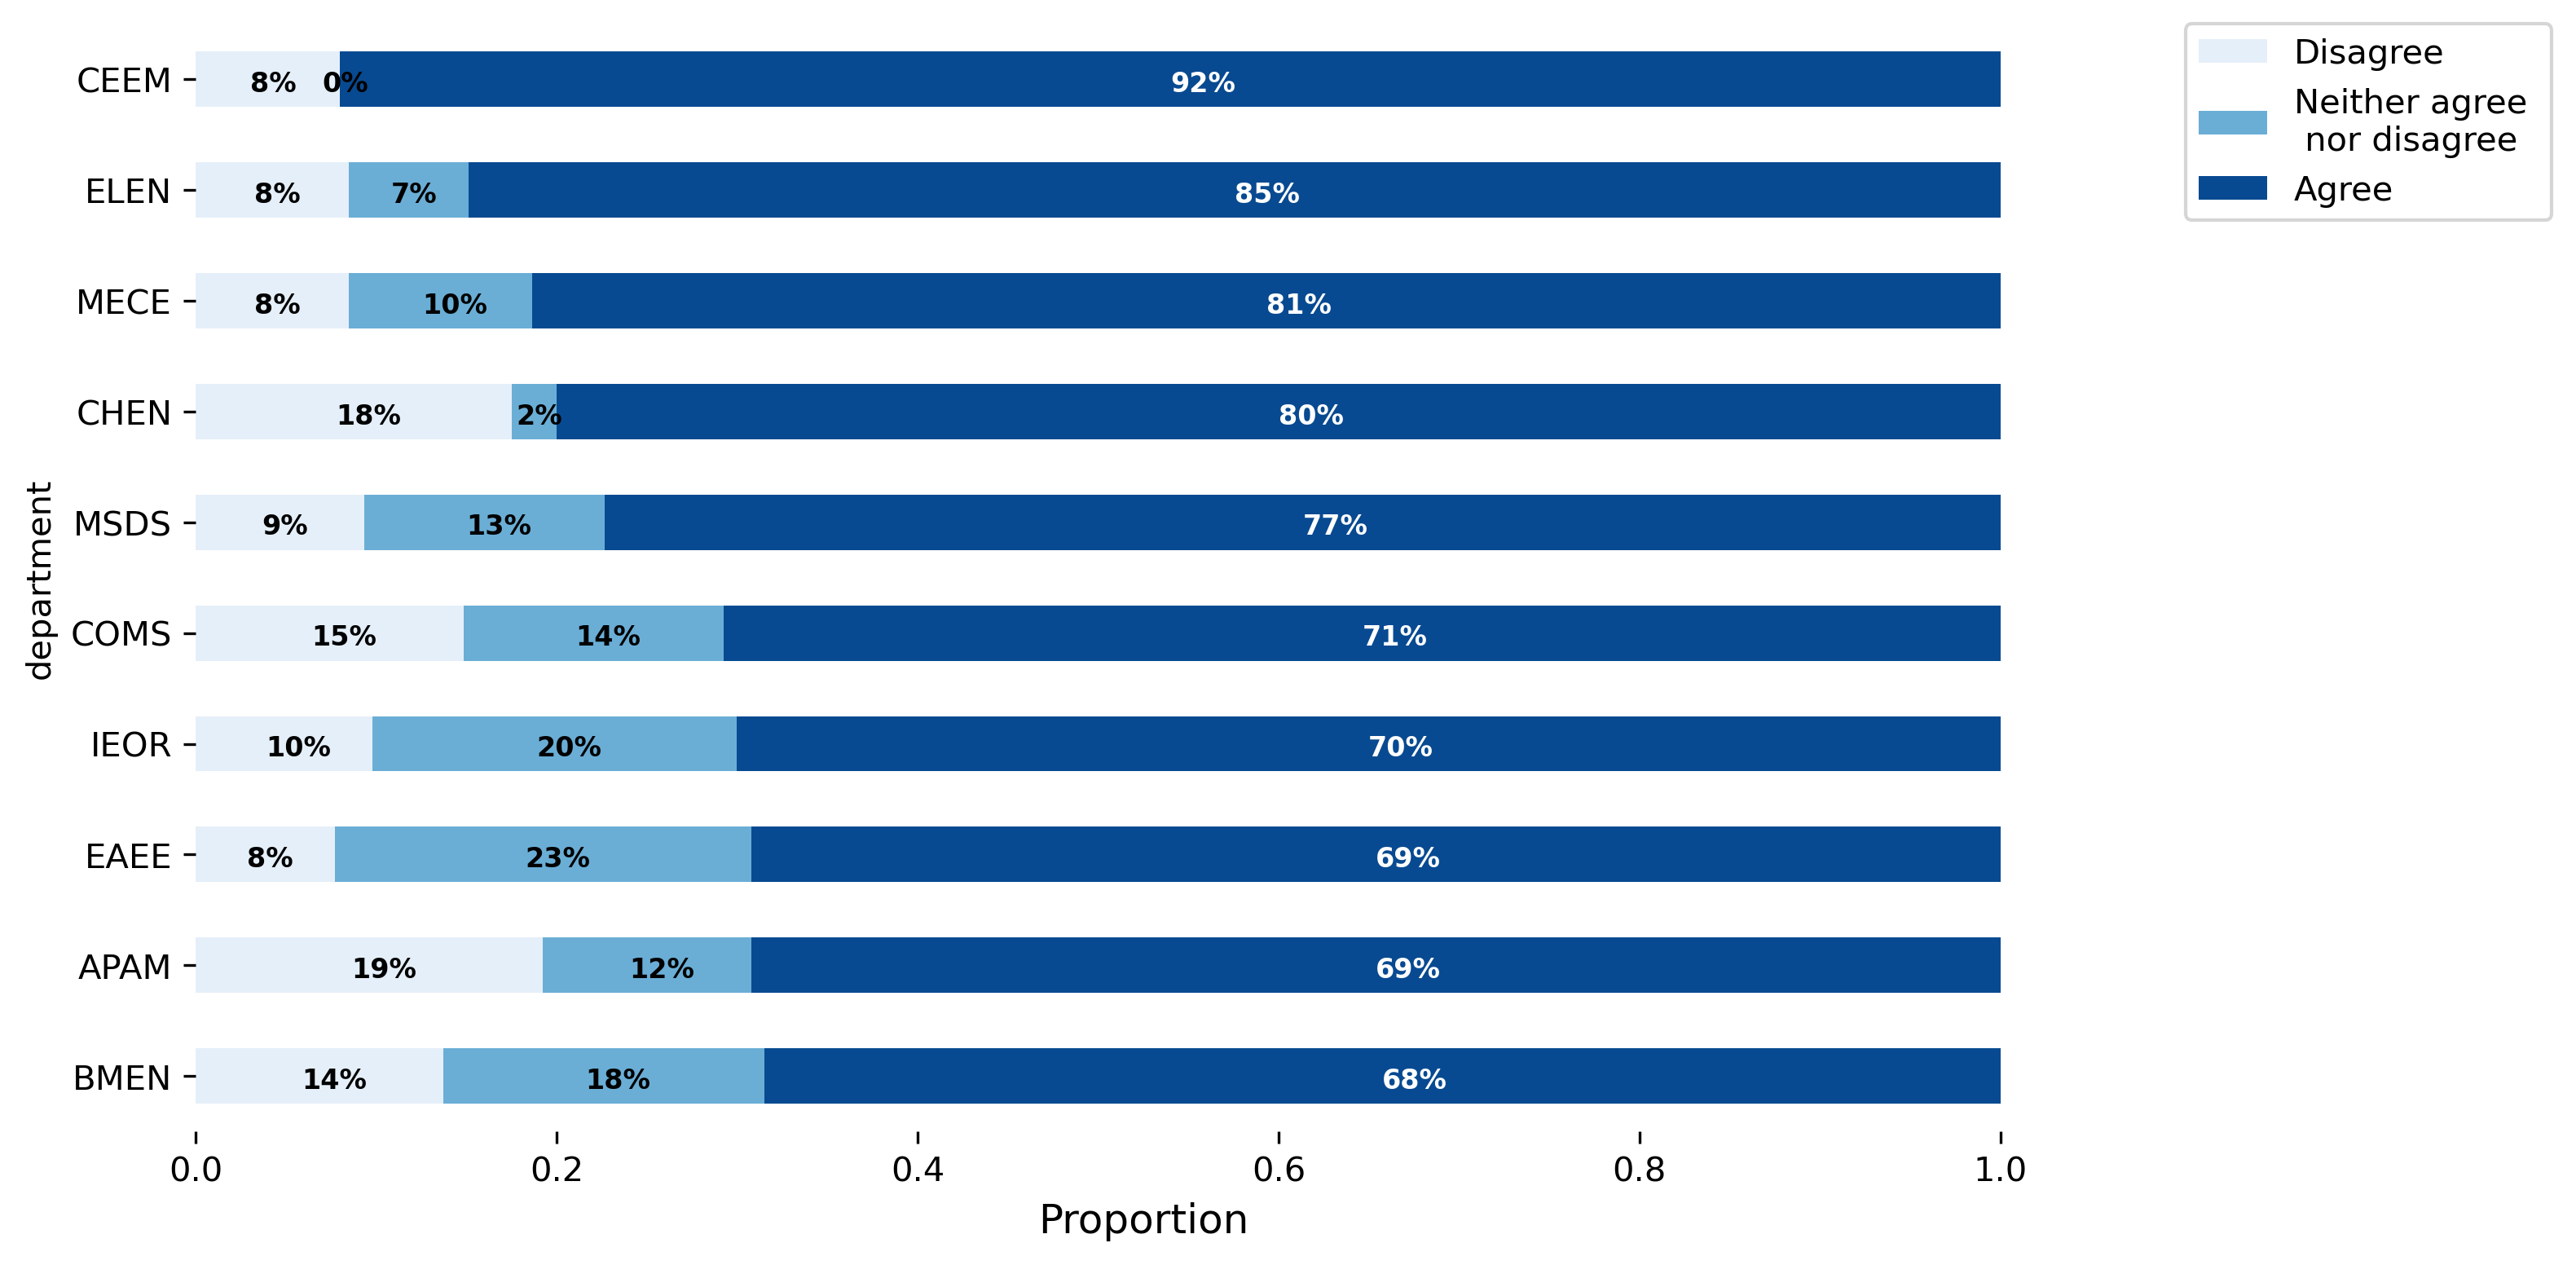

<AxesSubplot:xlabel='Proportion', ylabel='department'>

In [110]:
PDL=query_data(Q,qq,cleaned_data,"PDL",indx=2)
pdl1=pd.DataFrame(PDL['Response.6'])
pdl1['department']=department
pdl1['degree']=degree
pdl1['Response.6'].replace(4,5,inplace=True)
pdl1['Response.6'].replace(2,1,inplace=True)

pdl1#PDL.value_counts()
dpdl1=pdl1.groupby(['department','Response.6']).count().unstack('department').degree
dpdl1.drop(columns='I prefer not to answer.',inplace=True)
plot_3_cat((dpdl1).fillna(0))



In [57]:
PDL_sat=query_data(Q,qq,cleaned_data,"PDL",indx=3)
PDL_sat.value_counts()

I am satisfied with the PDL Elective Modules.


Response.7
4             495
5             215
3             155
2              65
1              43
dtype: int64

I am satisfied with the PDL Elective Modules.


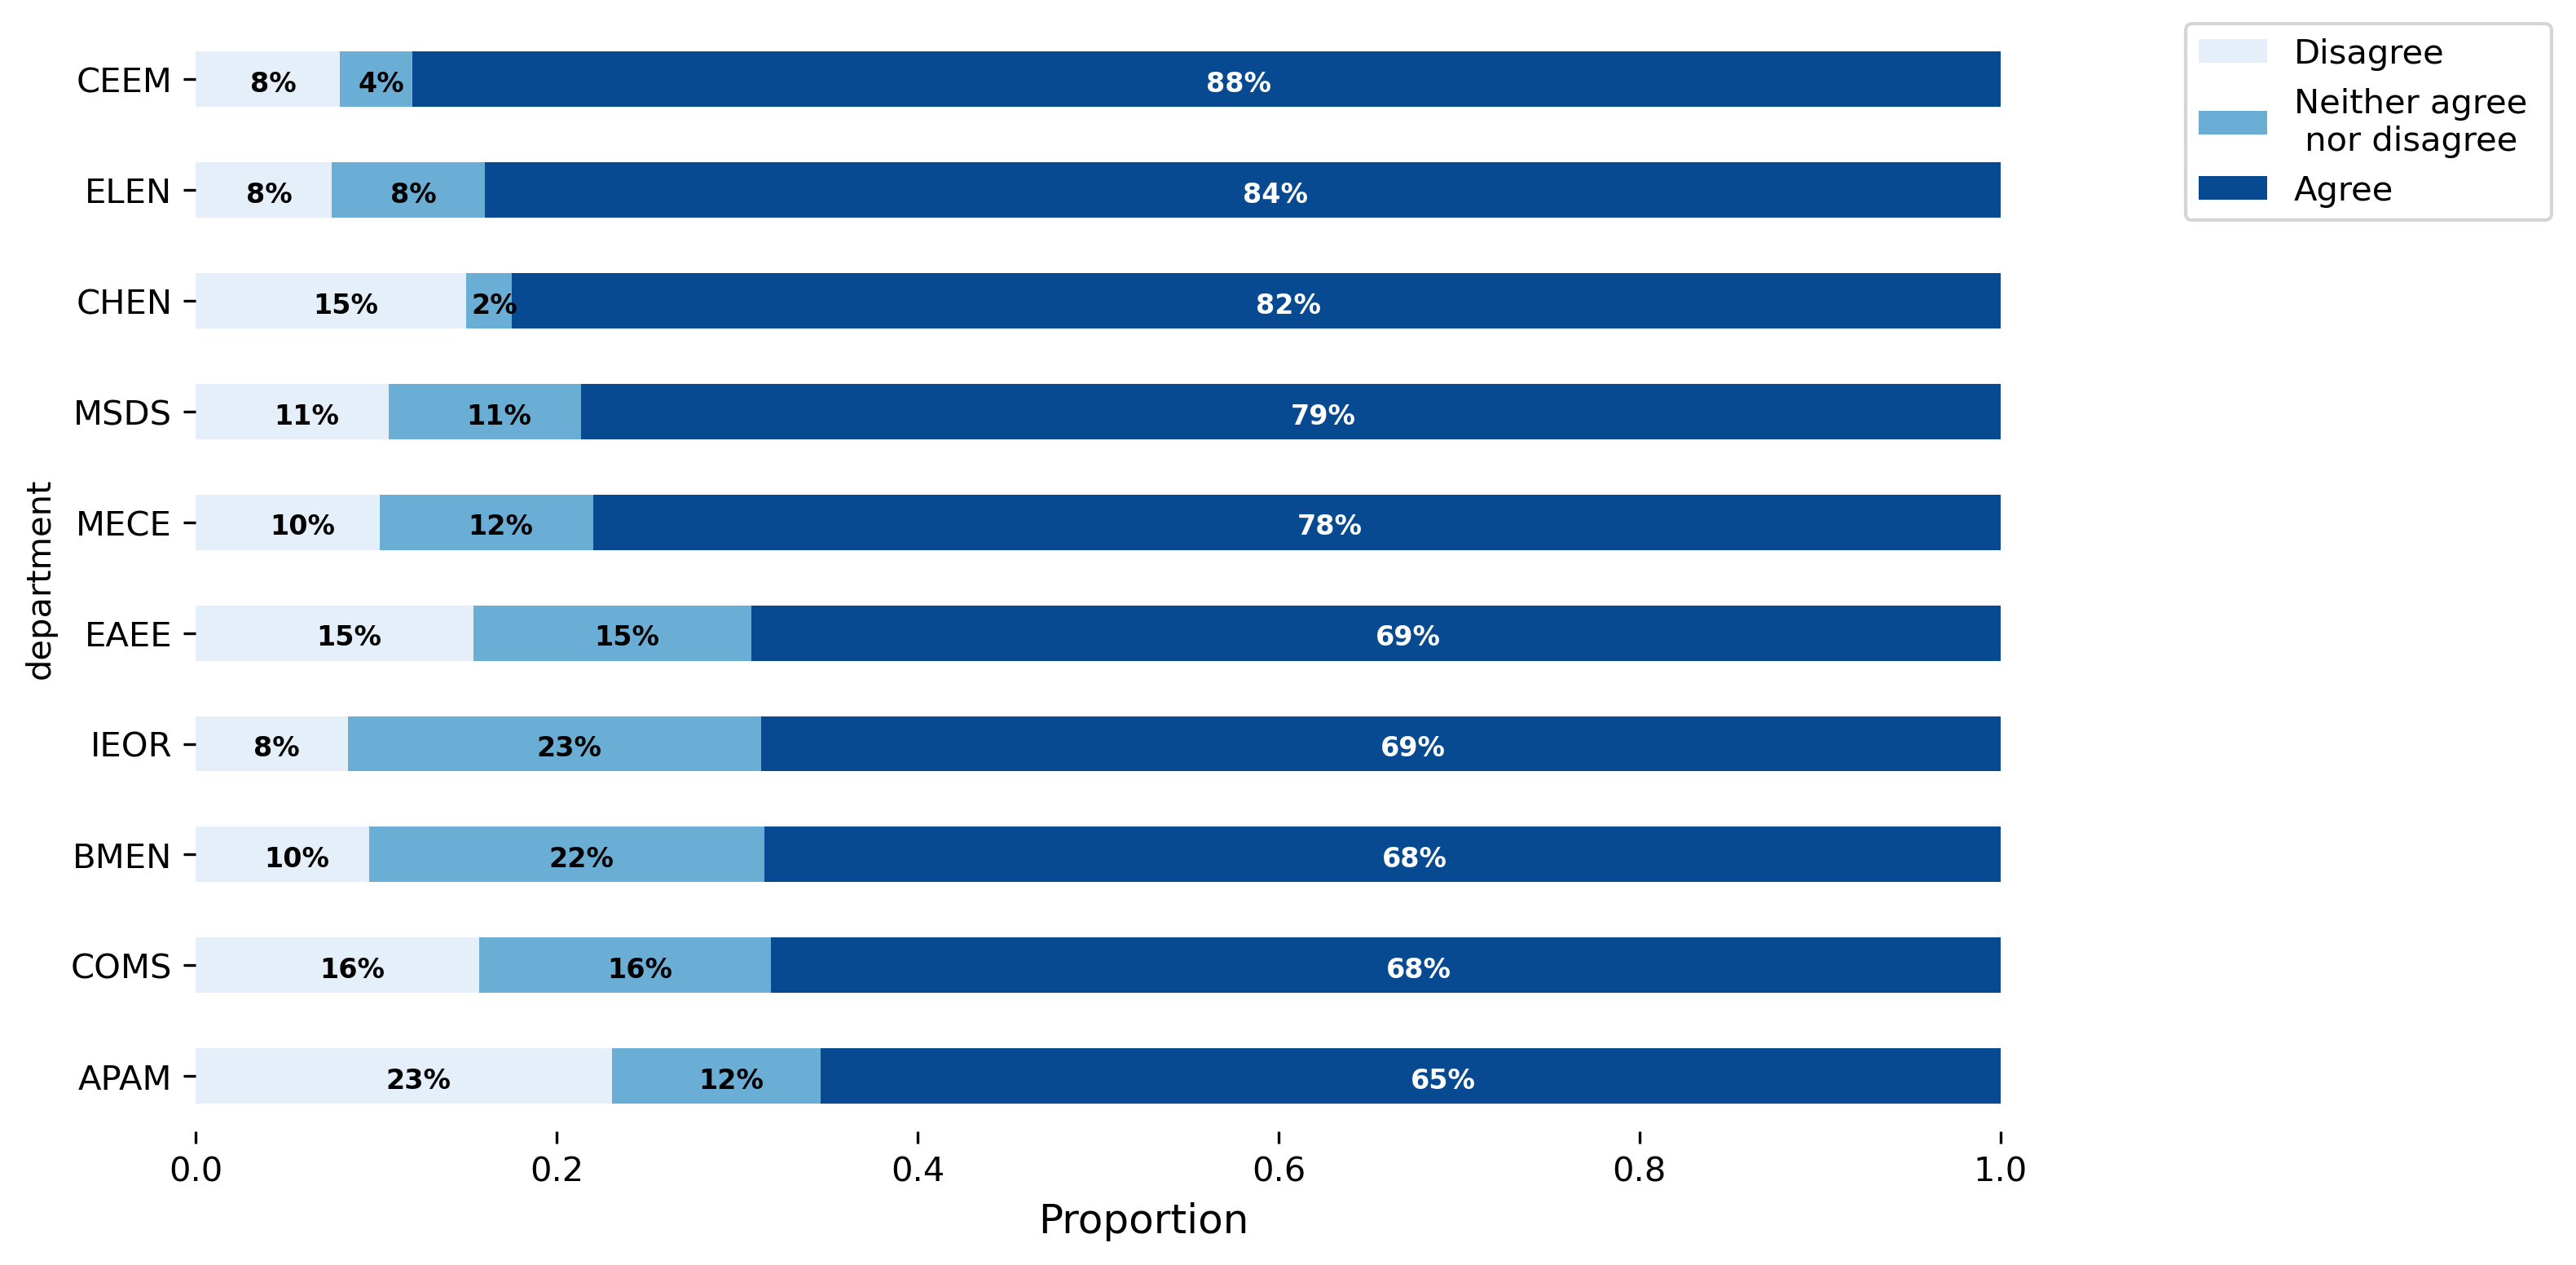

<AxesSubplot:xlabel='Proportion', ylabel='department'>

In [111]:
PDL=query_data(Q,qq,cleaned_data,"PDL",indx=3)
pdl1=pd.DataFrame(PDL['Response.7'])
pdl1['department']=department
pdl1['degree']=degree
pdl1['Response.7'].replace(4,5,inplace=True)
pdl1['Response.7'].replace(2,1,inplace=True)

pdl1#PDL.value_counts()
dpdl1=pdl1.groupby(['department','Response.7']).count().unstack('department').degree
dpdl1.drop(columns='I prefer not to answer.',inplace=True)


plot_3_cat((dpdl1).fillna(0))



In [113]:
PDL=query_data(Q,qq,cleaned_data,"resources",indx=1)
pdl1=pd.DataFrame(PDL['Professional Development and Leadership (PDL) Program'])
pdl1['department']=department
pdl1['degree']=degree
pdl1['Professional Development and Leadership (PDL) Program'].replace(4,5,inplace=True)
pdl1['Professional Development and Leadership (PDL) Program'].replace(2,1,inplace=True)
pdl1['Professional Development and Leadership (PDL) Program'].replace('Unaware of this resource',0,inplace=True)
pdl1#PDL.value_counts()
dpdl1=pdl1.groupby(['department','Professional Development and Leadership (PDL) Program']).count().unstack('department').degree
((dpdl1).fillna(0))

dpdl1.drop(columns='I prefer not to answer.',inplace=True)



I am satisfied with the following resources with respect to guidance in my degree program.


In [114]:
GCP=query_data(Q,qq,cleaned_data,"resources",indx=1)
gcp1=pd.DataFrame(GCP['Graduate Career Placement (GCP) Team'])
gcp1['department']=department
gcp1['degree']=degree
gcp1['Graduate Career Placement (GCP) Team'].replace(4,5,inplace=True)
gcp1['Graduate Career Placement (GCP) Team'].replace(2,1,inplace=True)
gcp1['Graduate Career Placement (GCP) Team'].replace('Unaware of this resource',0,inplace=True)
gcp1#PDL.value_counts()
dgcp1=gcp1.groupby(['department','Graduate Career Placement (GCP) Team']).count().unstack('department').degree
((dgcp1).fillna(0))
dgcp1.drop(columns='I prefer not to answer.',inplace=True)





I am satisfied with the following resources with respect to guidance in my degree program.


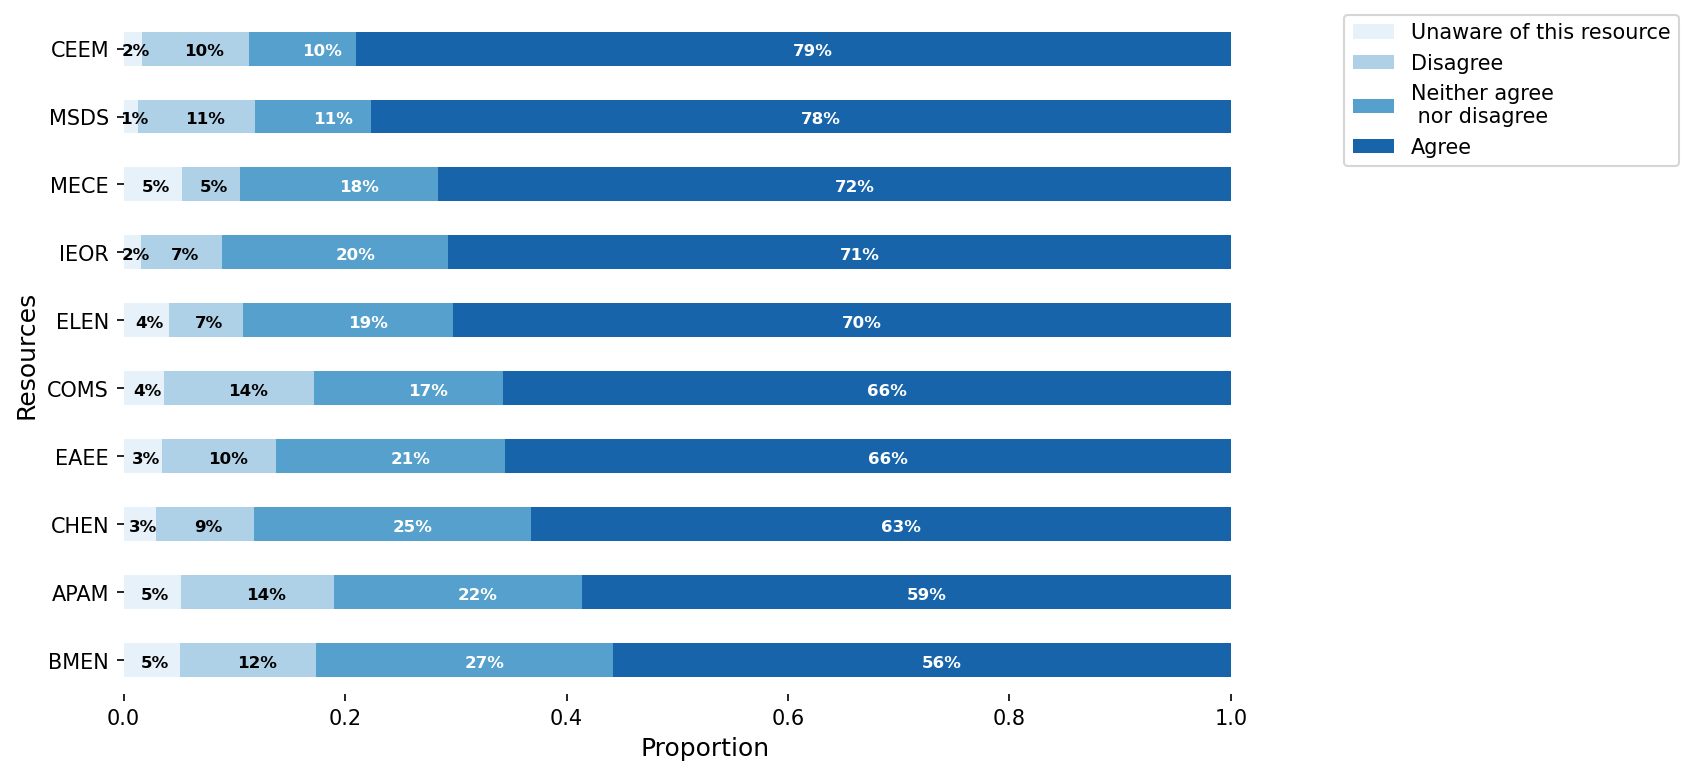

In [118]:
ind4=['Agree','Neither agree \n nor disagree','Disagree','Unaware of this resource']
dpdl1=dpdl1[::-1]

b_prob=(dpdl1[(dpdl1.iloc[2:,:].sum()).sort_values().index]).apply(lambda x: x / x.sum(), axis=0)
aaa=(b_prob[(b_prob.iloc[3:,:].sum()).sort_values().index]).T
bbb=b_prob[(b_prob.iloc[3:,:].sum()).sort_values().index].T

fig,ax=plt.subplots(figsize=(8,6),dpi=150)
bbb.plot(kind='barh', stacked=True,colormap=cmap, figsize=(10, 6),ax=ax)
#pd.DataFrame(b) 
plt.legend(ind4[::-1],bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., ncol=1)

#df3_1_cafe_count.index.name = 'rate'
#df3_1_cafe_count.columns.name = 'features'

plt.ylabel("Resources",fontsize=12)
plt.xlabel("Proportion",fontsize=12)
#plt.title("Overall Student Satisfaction: by Degree",fontsize=20)


for n, x in enumerate([*aaa.index.values]):
    m=3
    for (proportion, count, y_loc) in zip(bbb.loc[x],
                                          aaa.loc[x],
                                          bbb.loc[x].cumsum()):
        
        if m<2:
                 plt.text(x=(y_loc - proportion) + (proportion / 2),
                 y=n - 0.11,
                 s=f'{str(np.round(proportion * 100)).split(".")[0]}%',
                          #s=f'{str(count).split(".")[0]}', 
                 color="white",
                 fontsize=8,
                 fontweight="bold")
        if m>=2:
                plt.text(x=(y_loc - proportion) + (proportion / 2)-0.01,
                 y=n - 0.11,
                 s=f'{str(np.round(proportion * 100)).split(".")[0]}%',
                         #s=f'{str(count).split(".")[0]}', 
                 color="black",
                 fontsize=8,
                 fontweight="bold")
        m-=1
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)


plt.show()

In [83]:
PDLe_sat=query_data(Q,qq,cleaned_data,"PDL",indx=3)
PDLe_sat.value_counts().sum()

I am satisfied with the PDL Elective Modules.


973

In [324]:
df_satisfied_department=df_satisfied.copy()
df_satisfied_department['department']=department
df_satisfied_department['num']=1
dff=df_satisfied_department.groupby(['department','Response']).count().unstack('department')
#/dfff.sum(axis=0)
inddd=['Strongly agree','Agree','Neither agree \n nor disagree','Disagree','Strongly disagree','Unaware of this resource']



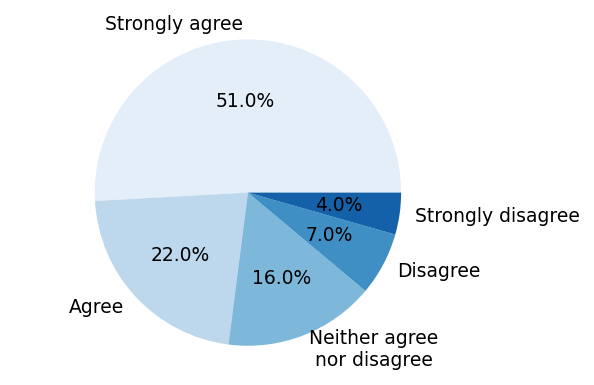

In [159]:
fig,ax=plt.subplots(figsize=(4,3),dpi=150)
#plt.pie(np.array(df_degree.iloc[:,0]),color=cmap)
#cmap = mpl.cm.Blues(np.linspace(0,1.5,10))
#cmap = mpl.colors.ListedColormap(cmap[10:,:-1])
cmapp = mpl.cm.Blues(np.linspace(0.1,1.7,10))
explode = (0, 0, 0, 0,0) 
indd=['Strongly agree','Agree','Neither agree \n nor disagree','Disagree','Strongly disagree']
_, _, autotexts =ax.pie(PDLe_sat.value_counts(), explode=explode, labels=indd, autopct=lambda p: '{:.1f}%'.format(round(p)) if p > 0 else '',colors=cmapp,
        shadow=False,textprops={'fontsize': 9})
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

#fig,ax=plt.subplots(figsize=(4,3),dpi=150)
#plt.pie(np.array(df_degree.iloc[:,0]),color=cmap)

#cmap = mpl.colors.ListedColormap(cmap[10:,:-1])

#explode = (0, 0, 0, 0,0) 
#_, _, autotexts =ax.pie(df_degree['Doctor of Philosophy (Ph.D.)'], explode=explode, labels=indd[::-1], autopct=lambda p: '{:.1f}%'.format(round(p)) if p > 0 else '',colors=cmap,
#        shadow=False,textprops={'fontsize':9})
#ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

The level of mentorship and guidance provided by my advisor(s) is adequate:

In [951]:
query_data(Q,qq,cleaned_data,"advisor",indx=2)

I am satisfied with my advisor's ability to:


Communicate efficiently Transfer academic knowledge  \
0                          5                           5   
2                          4                           4   
5             Not Applicable              Not Applicable   
6                          3                           3   
7                          4              Not Applicable   
...                      ...                         ...   
1585          Not Applicable              Not Applicable   
1586                       5                           5   
1587                       2                           2   
1588                       5                           5   
1590          Not Applicable              Not Applicable   

     Manage my research group  \
0                           3   
2                           3   
5              Not Applicable   
6                           3   
7              Not Applicable   
...                       ...   
1585           Not Applicable   
1586                        5   
1587                        3   
1588                        5   
1590           Not Applicable   

     Create a supportive and collaborative research environment  \
0                                                             3   
2                                                             3   
5                                                Not Applicable   
6                                                             3   
7                                                             4   
...                                                         ...   
1585                                             Not Applicable   
1586                                                          5   
1587                                                          4   
1588                                                          5   
1590                                             Not Applicable   

     Provide financial support for conferences of my interest  \
0                                                           3   
2                                              Not Applicable   
5                                              Not Applicable   
6                                                           3   
7                                              Not Applicable   
...                                                       ...   
1585                                           Not Applicable   
1586                                                        5   
1587                                                        1   
1588                                                        5   
1590                                           Not Applicable   

     Provide career guidance and support  
0                                      4  
2                         Not Applicable  
5                         Not Applicable  
6                                      3  
7                         Not Applicable  
...                                  ...  
1585                      Not Applicable  
1586                                   5  
1587                                   3  
1588                                   5  
1590                      Not Applicable  

[1250 rows x 6 columns]

In [234]:
skill=query_data(Q,qq,cleaned_data,"skills",indx=1).copy()
skill.replace(2,1,inplace=True)
skill.replace(4,5,inplace=True)
skill_count=skill.apply(pd.value_counts,axis=0).sort_index()
skill_count

The following skills have been improved/enhanced by my time at Columbia SEAS.


Presentation skills  Non-technical writing skills  \
1                  136                           231   
3                  320                           429   
5                  815                           611   

   Technical writing skills  Time management  \
1                       143              116   
3                       319              272   
5                       809              883   

   Proficiency and expertise in my field  Working in a team  \
1                                     63                 96   
3                                    143                256   
5                                   1065                919   

   Interacting with Industry professionals  Leadership skills  \
1                                      213                164   
3                                      326                370   
5                                      732                737   

   Facilitating conversations and discussions  \
1                                          97   
3                                         264   
5                                         910   

   Keeping up with latest advances in my field  
1                                           96  
3                                          231  
5                                          944

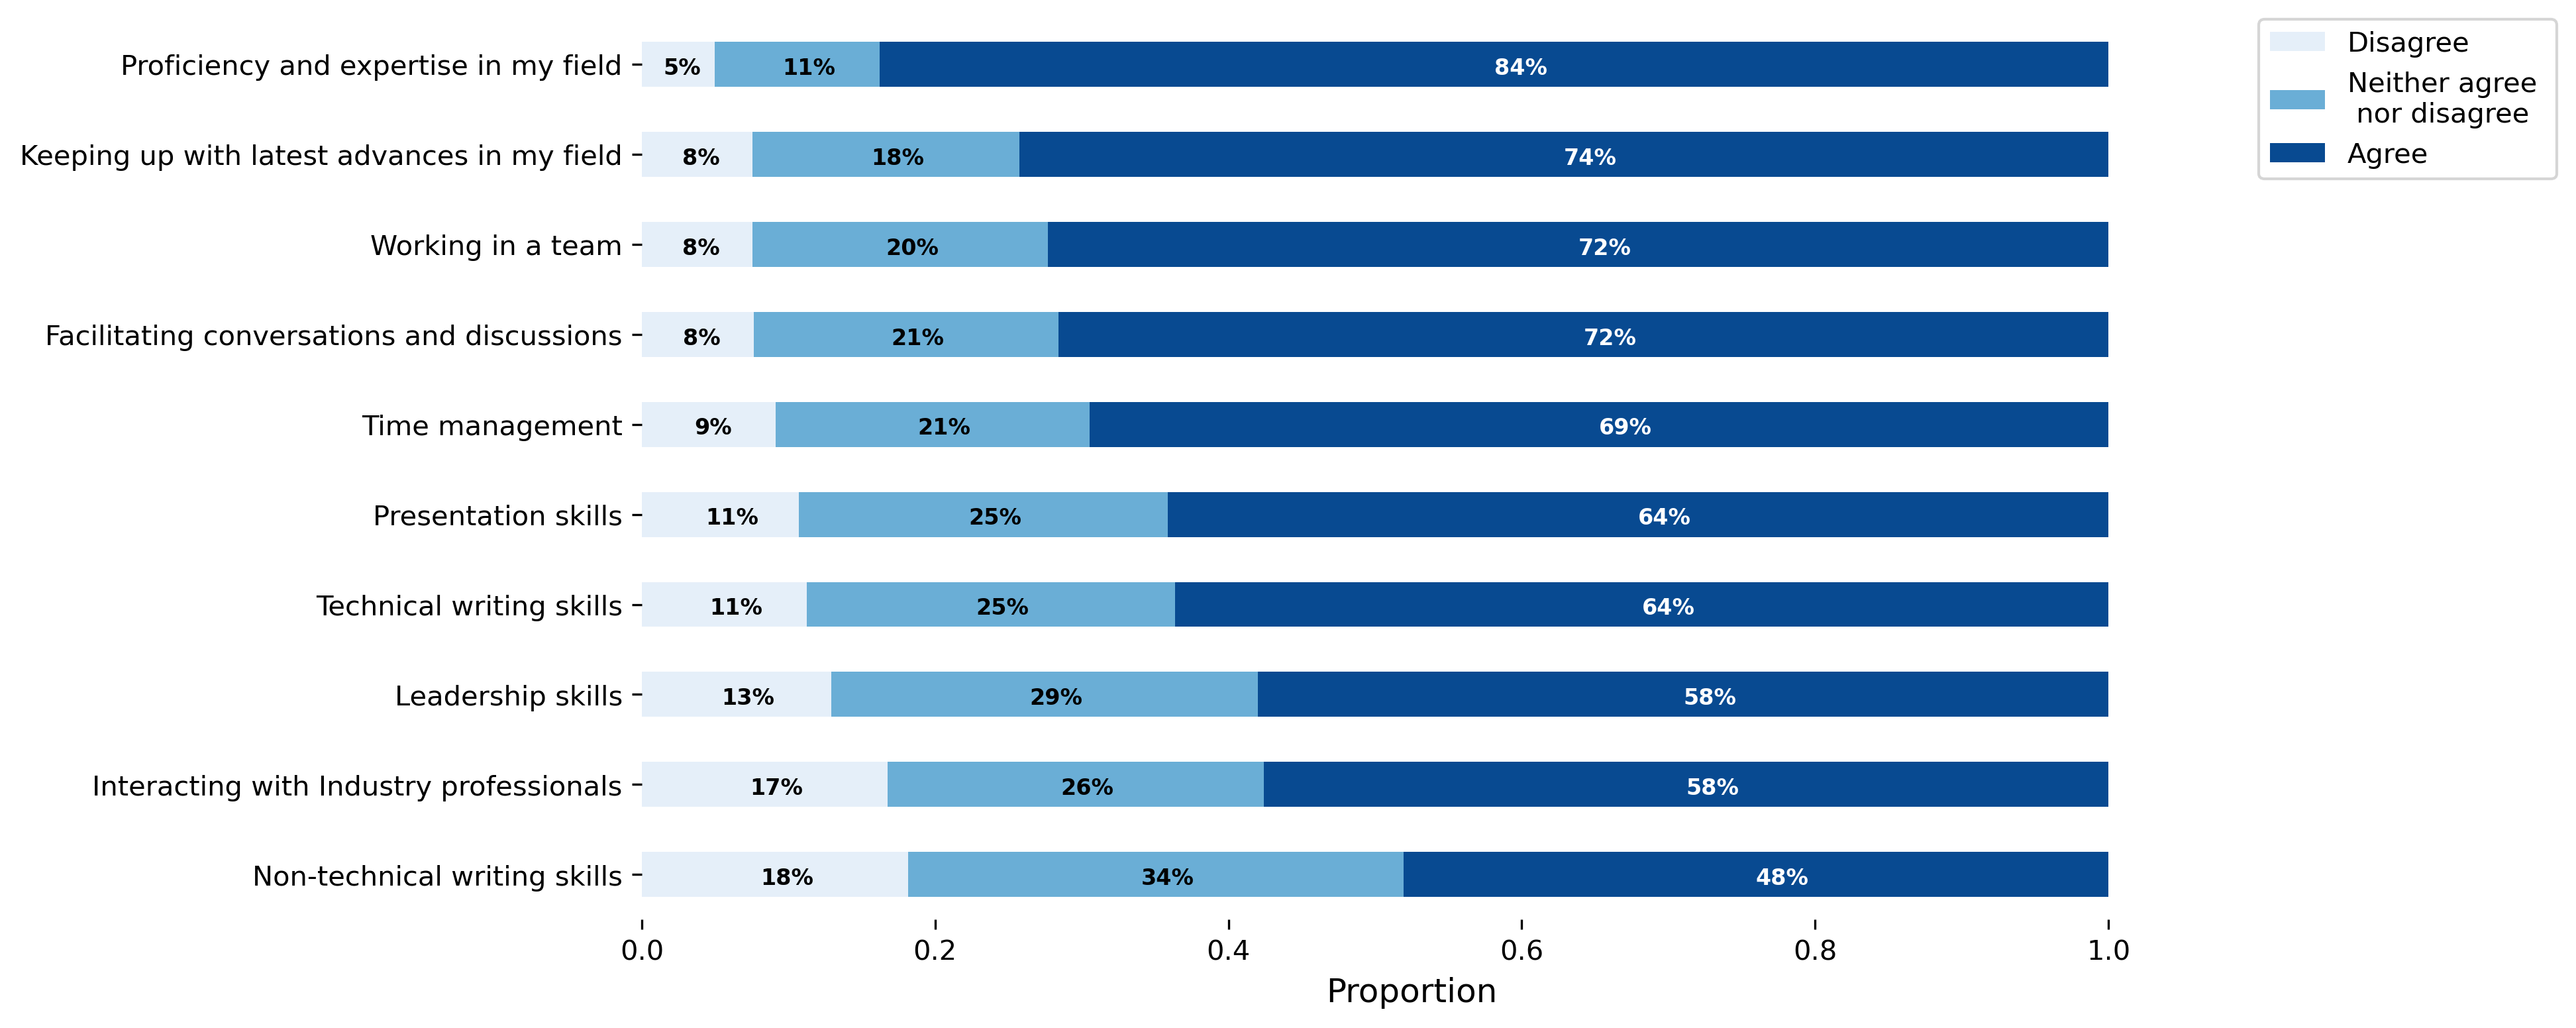

<AxesSubplot:xlabel='Proportion'>

In [203]:
plot_3_cat(skill_count)


In [756]:
PDL_com=query_data(Q,qq,cleaned_data,"PDL",indx=4).dropna()
PDL_com.to_csv("output/pdl_com.csv")

Please share comments regarding the PDL Program.


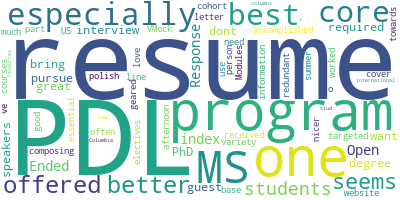

In [755]:
(PDL_com).reset_index(inplace=True)
long_string = (str((PDL_com)))
long_string = long_string.replace('classes','class')
long_string = long_string.replace('','')
long_string = long_string.replace('','')
long_string = long_string.replace('','')
wordcloud = WordCloud(background_color="white", max_words=1000, contour_width=3,random_state=2,  contour_color='skyblue')
wordcloud.generate(long_string)
    #path = f'../fig/Restaurant_{i}stars_wordcloud.png'
    #print(f"Word Cloud for {i} stars Restaurant")
fig = wordcloud.to_image()
display(fig)
    #fig.save(path)

## Resources

In [206]:
resources_sat=query_data(Q,qq,cleaned_data,"satisfied",indx=6).copy()
resources_sat.replace('Unaware of this resource',0,inplace=True)
resources_sat['degree']=degree

I am satisfied with the following resources with respect to guidance in my degree program.


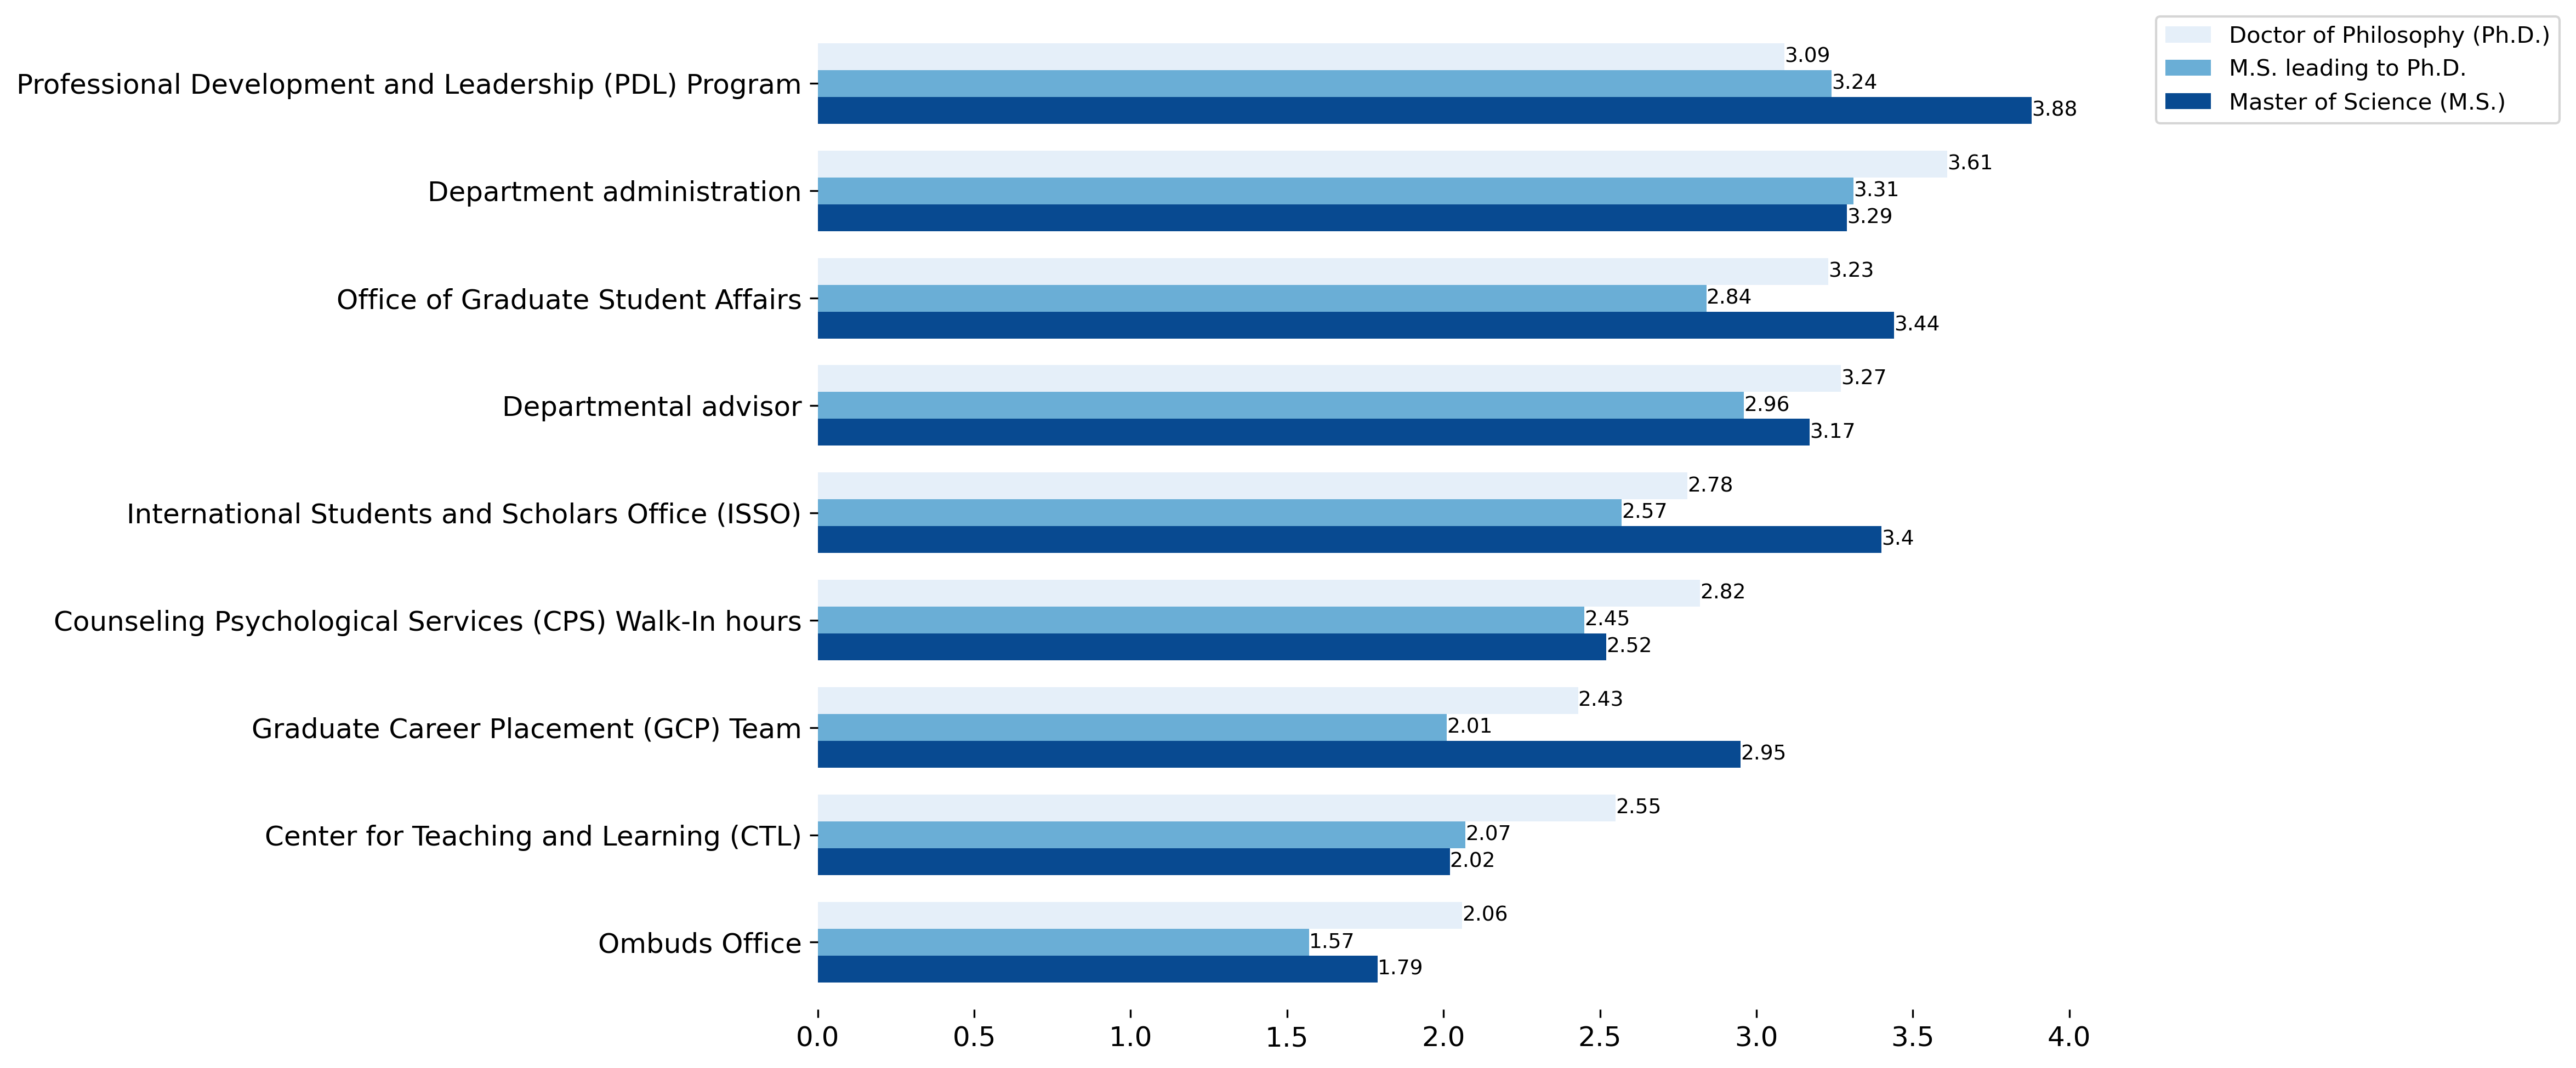

In [209]:

fig,ax=plt.subplots(figsize=(10,8),dpi=300)
#aca_import['degree']=degree
df=resources_sat.groupby(['degree']).mean().round(2).drop(index='Professional Degree')
df=df[df.mean().sort_values().index[::-1]]
#indd=['Supplementary \n educational tools', 'Degree \n requirements',
 #      'Course Delivery \n Method', 'Instruction', 'Course content']
ax=df.T.plot.barh(ax=ax,colormap=cmap,width=0.75, rot=0 ,fontsize=12)
#ax.set_xticklabels( rotation=0,)
x_offset = -0.1
y_offset = 0.05
for container in ax.containers:
    ax.bar_label(container,fontsize=9)
#for p in ax.patches:
 #   b = p.get_bbox()
  #  val = "{:.2f}".format(b.x1 + b.x0)        
  #  ax.annotate(val, (( b.y1)/2+ x_offset, b.x0 +b.x1+y_offset),fontsize=6)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

ax.invert_yaxis()

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., ncol=1)

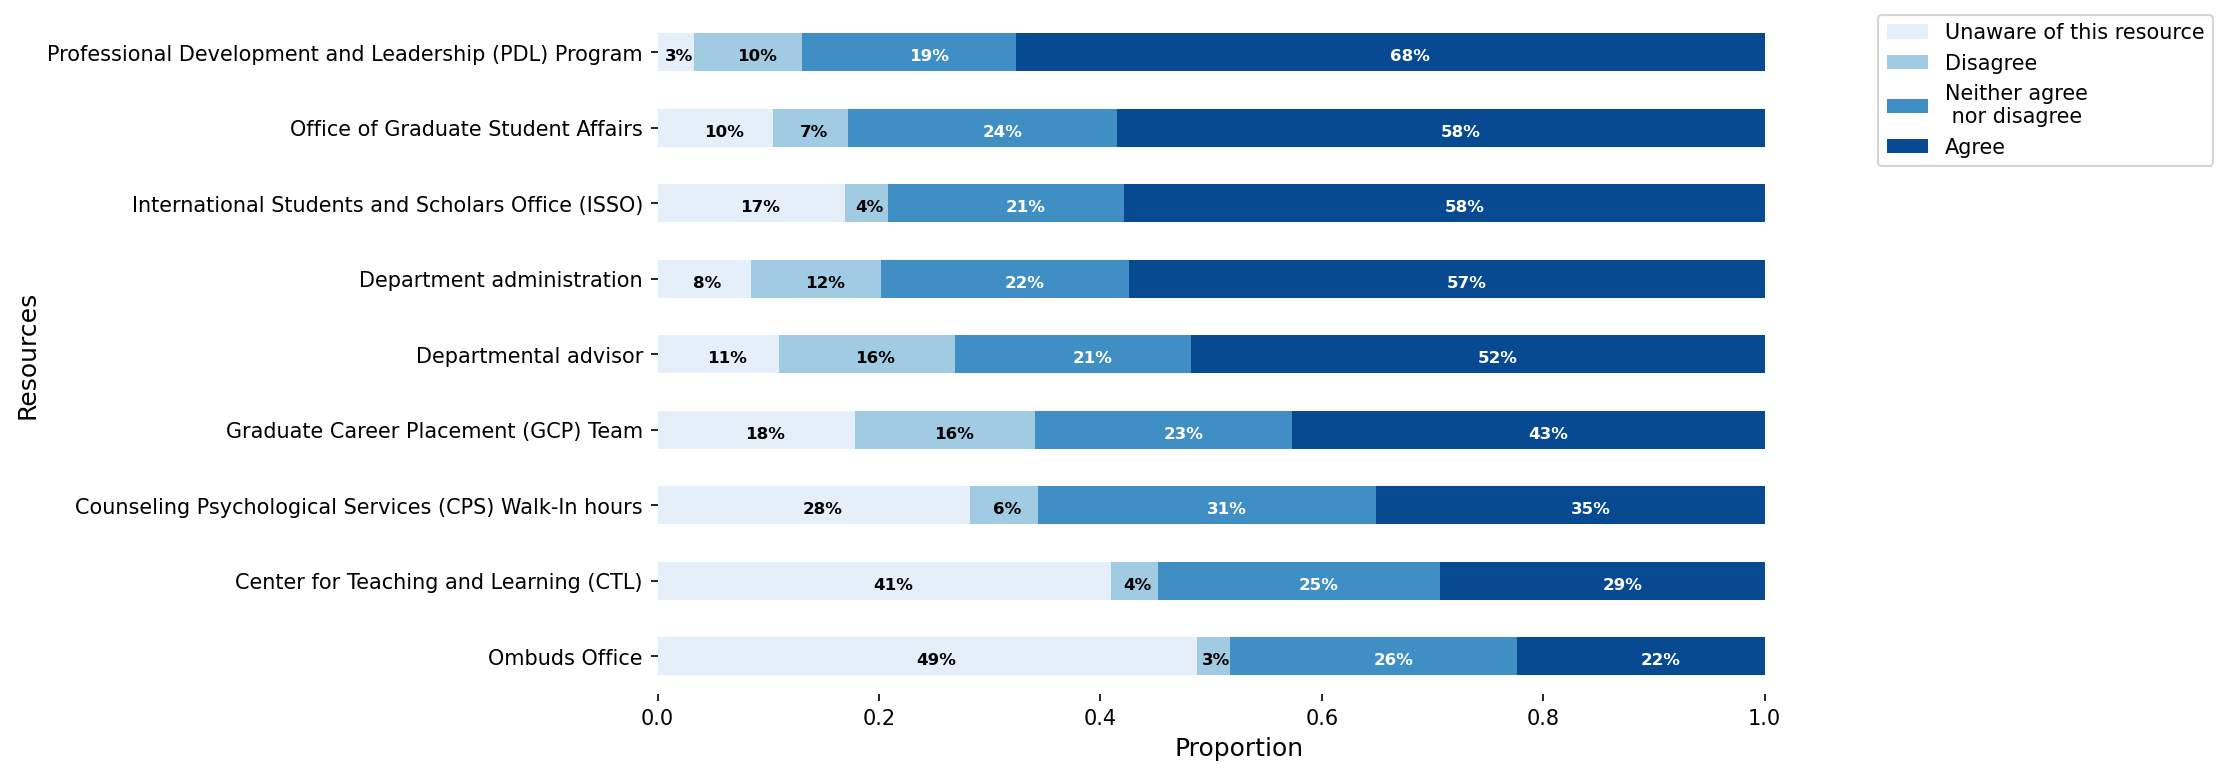

In [202]:
ind4=['Agree','Neither agree \n nor disagree','Disagree','Unaware of this resource']


b_prob=(resources_sat_count[(resources_sat_count.iloc[2:,:].sum()).sort_values().index]).apply(lambda x: x / x.sum(), axis=0)
aaa=(b_prob[(b_prob.iloc[3:,:].sum()).sort_values().index]).T
bbb=b_prob[(b_prob.iloc[3:,:].sum()).sort_values().index].T

fig,ax=plt.subplots(figsize=(8,6),dpi=150)
bbb.plot(kind='barh', stacked=True,colormap=cmap, figsize=(10, 6),ax=ax)
#pd.DataFrame(b) 
plt.legend(ind4[::-1],bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., ncol=1)

#df3_1_cafe_count.index.name = 'rate'
#df3_1_cafe_count.columns.name = 'features'

plt.ylabel("Resources",fontsize=12)
plt.xlabel("Proportion",fontsize=12)
#plt.title("Overall Student Satisfaction: by Degree",fontsize=20)


for n, x in enumerate([*aaa.index.values]):
    m=3
    for (proportion, count, y_loc) in zip(bbb.loc[x],
                                          aaa.loc[x],
                                          bbb.loc[x].cumsum()):
        
        if m<2:
                 plt.text(x=(y_loc - proportion) + (proportion / 2),
                 y=n - 0.11,
                 s=f'{str(np.round(proportion * 100)).split(".")[0]}%',
                          #s=f'{str(count).split(".")[0]}', 
                 color="white",
                 fontsize=8,
                 fontweight="bold")
        if m>=2:
                plt.text(x=(y_loc - proportion) + (proportion / 2)-0.01,
                 y=n - 0.11,
                 s=f'{str(np.round(proportion * 100)).split(".")[0]}%',
                         #s=f'{str(count).split(".")[0]}', 
                 color="black",
                 fontsize=8,
                 fontweight="bold")
        m-=1
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)


plt.show()

<BarContainer object of 9 artists>

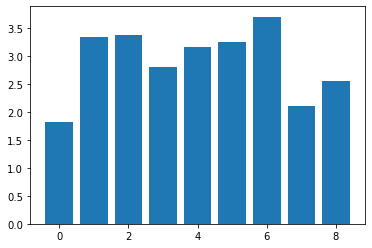

In [321]:
plt.bar(np.arange(len(resources_sat.mean(axis=0))),height=resources_sat.mean(axis=0))

## Canvas

In [205]:
canvas_sat=query_data(Q,qq,cleaned_data,"Canvas",indx=1).copy()
canvas_sat.replace('Unaware of this Feature',0,inplace=True)
canvas_sat.replace(2,1,inplace=True)
canvas_sat.replace(4,5,inplace=True)
canvas_sat_count=canvas_sat.apply(pd.value_counts,axis=0)
canvas_sat_count.drop(index=0,inplace=True)

I find the following features of Canvas convenient.


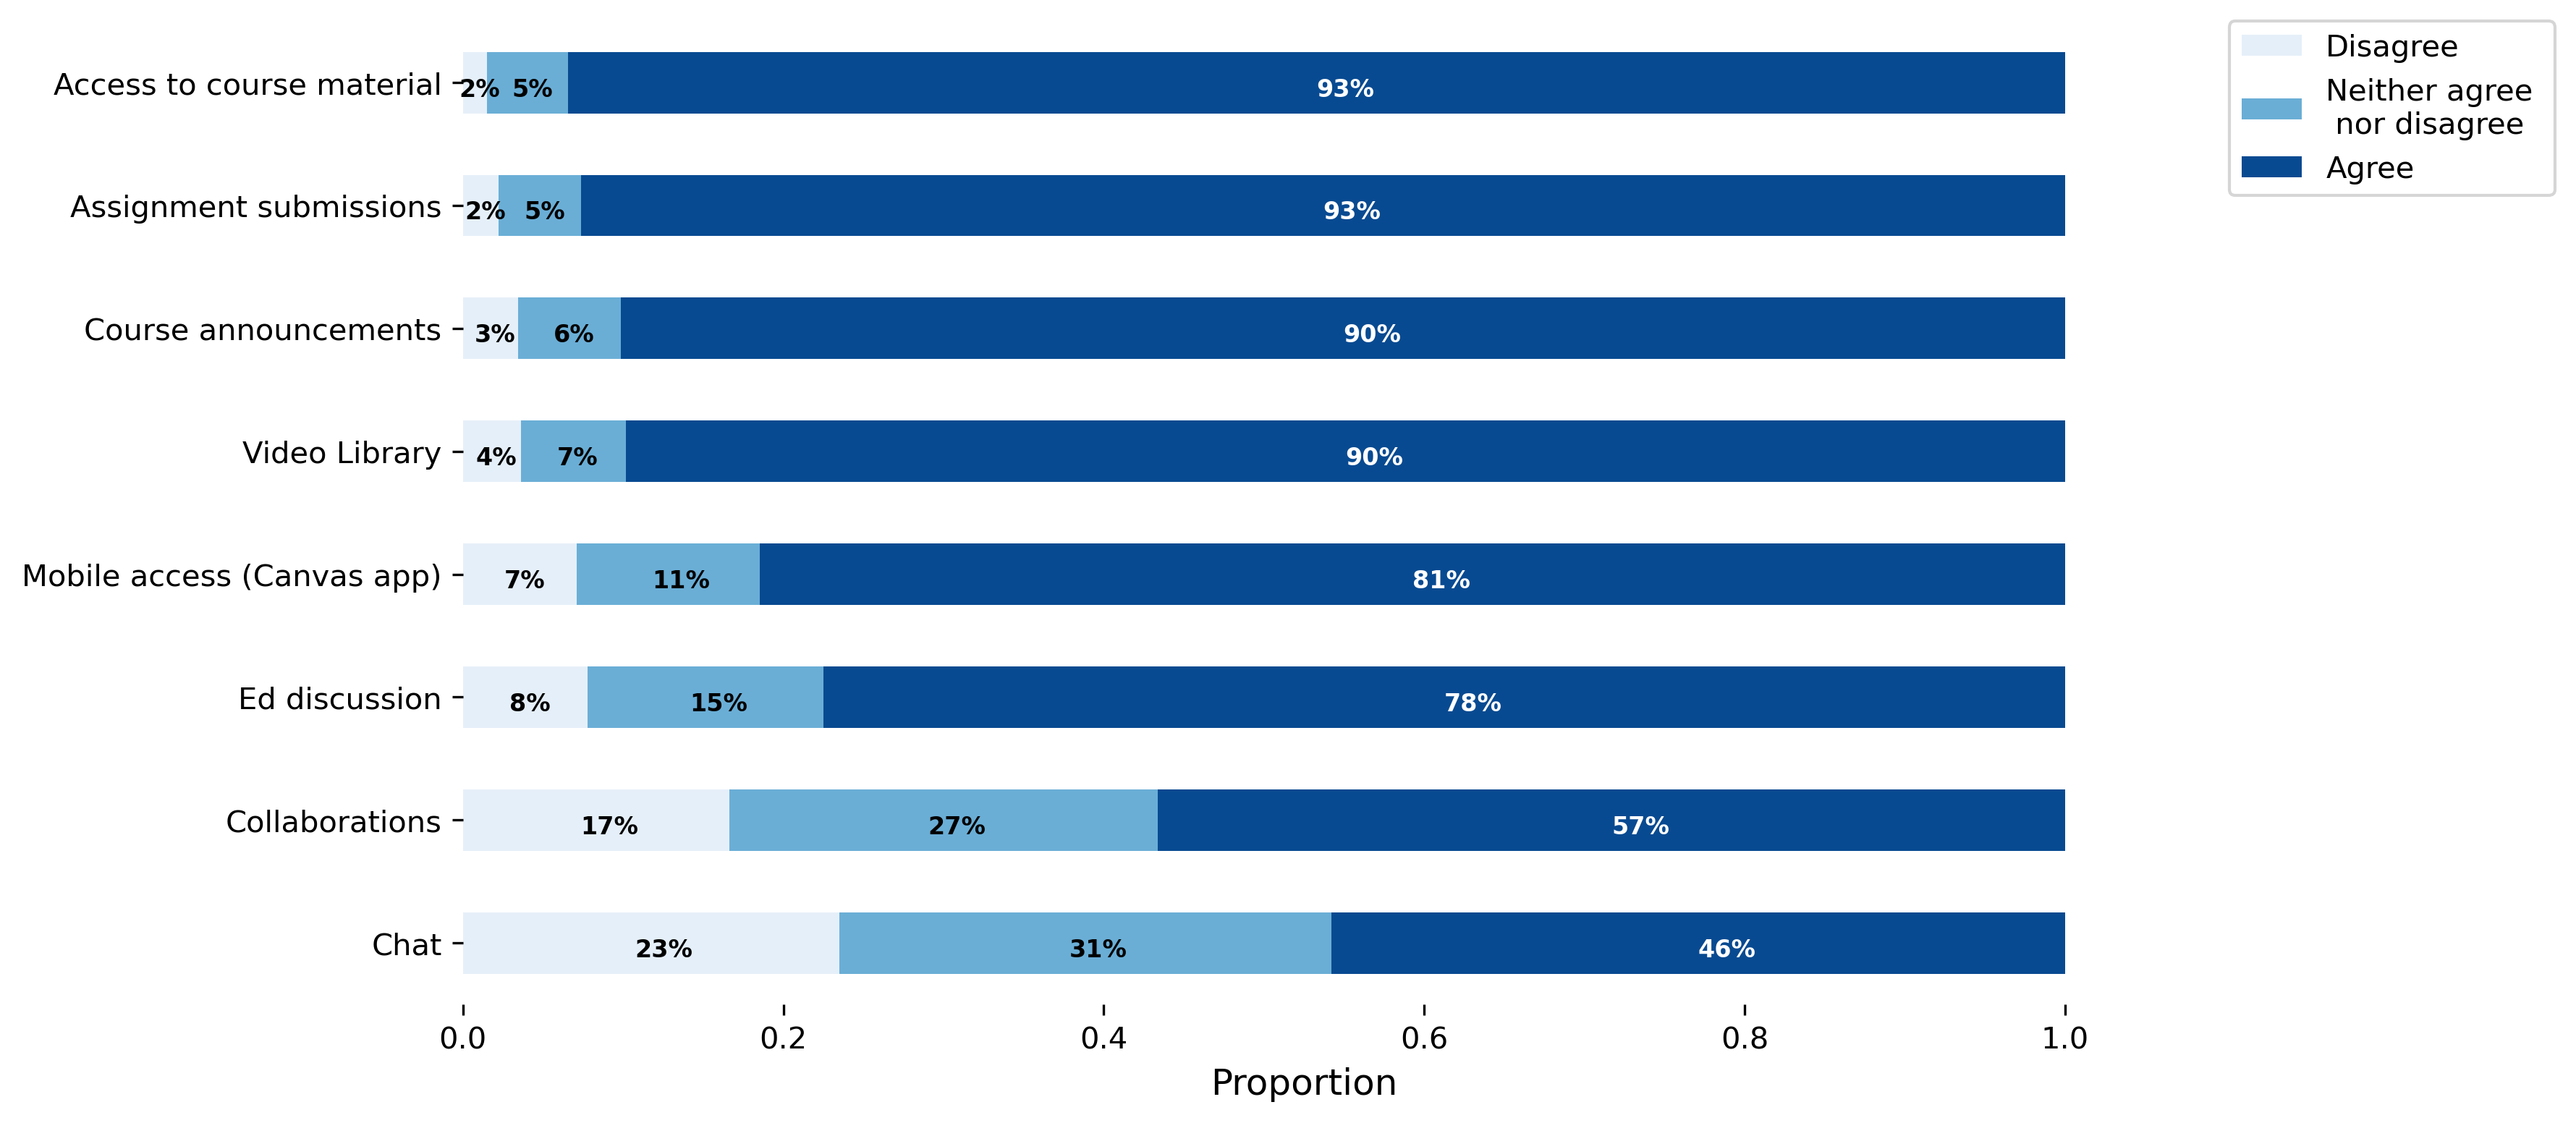

<AxesSubplot:xlabel='Proportion'>

In [206]:
plot_3_cat(canvas_sat_count)

In [666]:
canvas_com=query_data(Q,qq,cleaned_data,"Canvas",indx=2).dropna()
(canvas_com).reset_index(inplace=True)
canvas_com
#.to_csv("output/canvas_comments.csv")

Please enter any additional comments regarding Canvas:


index  \
0        6   
1       17   
2       26   
3       43   
4       45   
..     ...   
108   1511   
109   1517   
110   1528   
111   1532   
112   1549   

                                                                                                         Open-Ended Response  
0                                                     Email notifications are usually a bit late but overall it's still good  
1                                                                       please provide a way to contact people from my class  
2    2 out of 8 of my classes used any collaboration with students, TAs, and Professors in forum format (e.g., ask a ques...  
3    On my phone, I always get the same annoucement 2 times on canvas and one time from email. And when prof adding annot...  
4                                                                                                       The inbox is great.   
..                                                                                                                       ...  
108                                                            Canvas keeps sending repeated notifications which is annoying  
109                                                                                                      i do not have any.   
110  Canvas, while on hand is really intuitive, has its way of portraying legacy technology based applications which migh...  
111  I don't use Chat at all.  I don't like Ed as much as I liked Piazza.  The assignment and video library are good feat...  
112                                                                                 its not great but really doesn't matter   

[113 rows x 2 columns]

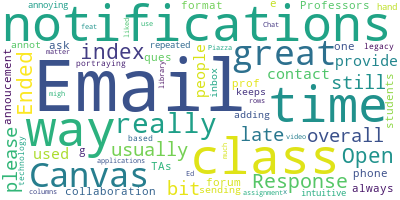

In [648]:

long_string = (str((canvas_com)))
long_string = long_string.replace('classes','class')
long_string = long_string.replace('canvas','')
long_string = long_string.replace('good','')
#long_string = long_string.replace('one','')
wordcloud = WordCloud(background_color="white", max_words=1000, contour_width=3,random_state=2,  contour_color='skyblue')
wordcloud.generate(long_string)
    #path = f'../fig/Restaurant_{i}stars_wordcloud.png'
    #print(f"Word Cloud for {i} stars Restaurant")
fig = wordcloud.to_image()
display(fig)
    #fig.save(path)

## SSOL

In [208]:
ssol_sat=query_data(Q,qq,cleaned_data,"SSOL",indx=1).copy()
ssol_sat.replace('Unaware of this Feature',0,inplace=True)
ssol_sat.replace(2,1,inplace=True)
ssol_sat.replace(4,5,inplace=True)
ssol_sat_count=ssol_sat.apply(pd.value_counts,axis=0)
ssol_sat_count.drop(index=0,inplace=True)

I find the following features of SSOL convenient.


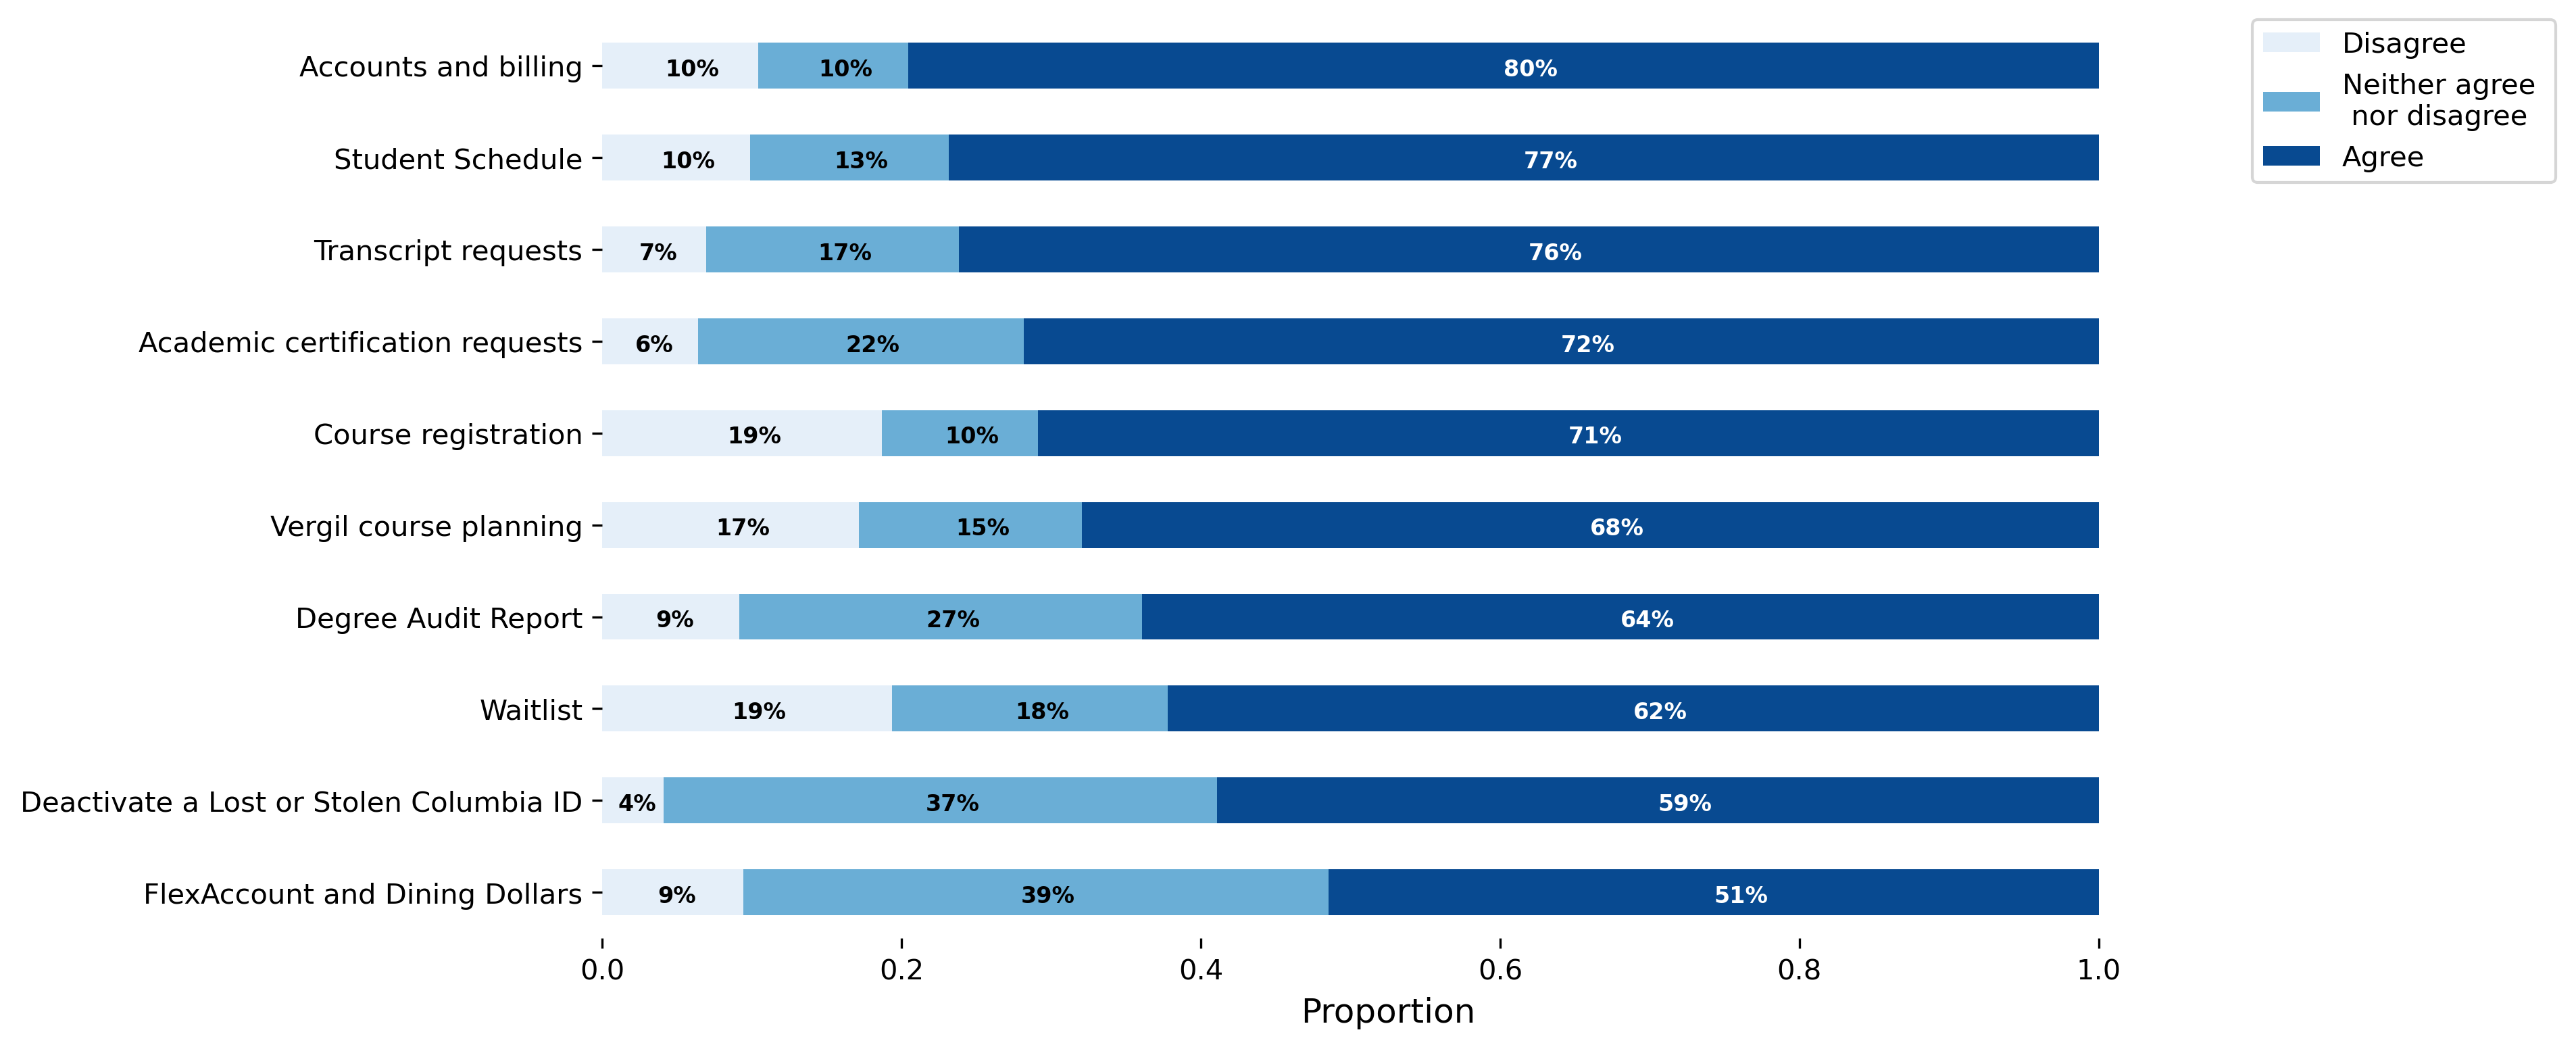

<AxesSubplot:xlabel='Proportion'>

In [209]:
plot_3_cat(ssol_sat_count)

In [654]:
ssol_com=query_data(Q,qq,cleaned_data,"SSOL",indx=2).dropna()
(ssol_com).reset_index(inplace=True)
ssol_com
#.to_csv("output/ssol_comments.csv")

Please enter any additional feedback you might have regarding SSOL:


index  \
0        6   
1       17   
2       26   
3       39   
4       43   
..     ...   
160   1510   
161   1517   
162   1533   
163   1540   
164   1549   

                                                                                                       Open-Ended Response.1  
0                                                                  It would be nice to not have strict registration windows.  
1    why are there two websites? remove virgil and just make SSOL the only website tat has to do with finding classes for...  
2    Neither agree nor disagree is I have not used it.  Course registration the first time around was confusing.  Maybe I...  
3                                                            Cannot submit the graduation application form directly on SSOL.  
4    The time to get paper edition transcript takes too long, and for international students, if we will go back to our h...  
..                                                                                                                       ...  
160  Columbia really needs to modernize Vergil/Course Catalog/SSOL. Current UI is terrible. Also, we need to have one pla...  
161                                                 SSOL must be redesigned. A total disaster of a website. Smells like 90s.  
162                                                   Really needs an update: no reason for there to be registration periods  
163                                                                  Canvas' schedule more useful and accessible than SSOL's  
164  it's a bargain bin solution, and it shows. (doesn't the universty have money for things other than the lawn?)   the ...  

[165 rows x 2 columns]

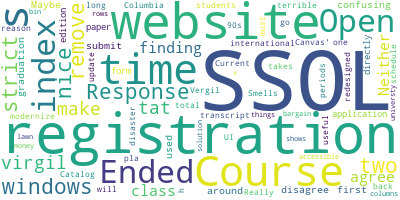

In [664]:
long_string = (str((ssol_com)))
long_string = long_string.replace('classes','class')
long_string = long_string.replace('','')
long_string = long_string.replace('really','')
long_string = long_string.replace('need','')
wordcloud = WordCloud(background_color="white", max_words=1000, contour_width=3,random_state=2,  contour_color='skyblue')
wordcloud.generate(long_string)
    #path = f'../fig/Restaurant_{i}stars_wordcloud.png'
    #print(f"Word Cloud for {i} stars Restaurant")
fig = wordcloud.to_image()
display(fig)
    #fig.save(path)

In [655]:

import sklearn.feature_extraction.text as sk_text
Tfidf_vectorizer = sk_text.TfidfVectorizer(max_features=1000, lowercase=True, analyzer='word',
stop_words= 'english',ngram_range=(1,1), min_df = .05 , max_df = .85)

matrix = Tfidf_vectorizer.fit_transform(ssol_com['Open-Ended Response.1'])


In [660]:
from sklearn.decomposition import LatentDirichletAllocation


lda=LatentDirichletAllocation(n_components=20,n_jobs=-1,
                             random_state=123)


X_lda=lda.fit_transform(matrix)
  

In [661]:
vocab=Tfidf_vectorizer.get_feature_names()

vocab=np.array(vocab)

for topic_idx in range(20):
    a=vocab[np.argsort(lda.components_[topic_idx])[::-1][:5]]
    b=' '.join(a)
    print(f'Topic #{topic_idx:2d} : {b}')
 

Topic # 0 : vergil course use registration know
Topic # 1 : registration students day time course
Topic # 2 : transcript know students time doesn
Topic # 3 : waitlist know like course students
Topic # 4 : registration students course like ssol
Topic # 5 : classes ssol vergil course like
Topic # 6 : time registration students course classes
Topic # 7 : doesn waitlist ssol registration know
Topic # 8 : day registration time students like
Topic # 9 : registration students course like ssol
Topic #10 : need use registration course billing
Topic #11 : user interface like use ssol
Topic #12 : registration students course like ssol
Topic #13 : ssol like use waitlist course
Topic #14 : day like use waitlist course
Topic #15 : better use waitlist registration vergil
Topic #16 : registration students course like ssol
Topic #17 : courses course waitlist day registration
Topic #18 : billing students know day registration
Topic #19 : course registration like students ssol


## Library

How many times per week do you frequent the following libraries?

In [210]:
lib_fre=query_data(Q,qq,cleaned_data,"libraries",indx=1).copy()

lib_fre.replace("2-Jan","1-2",inplace=True)
lib_fre.replace("3-Feb",'2-3',inplace=True)
lib_fre.replace("4-Mar","3-4",inplace=True)

How many times per week do you frequent the following libraries?


In [93]:
lib_fre_count

Science and Engineering Library in the Northwest Corner Building  \
0-1                                                708                  
1-2                                                275                  
2-3                                                116                  
3-4                                                 72                  
>4                                                 100                  

     Watson Library of Business and Economics in Uris Hall  Butler Library  \
0-1                                                767                 640   
1-2                                                208                 283   
2-3                                                116                 141   
3-4                                                 79                  75   
>4                                                 101                 132   

     Avery Architectural & Fine Arts Library  Other University libraries  \
0-1                                     1052                         944   
1-2                                      121                         150   
2-3                                       53                          65   
3-4                                       26                          44   
>4                                        19                          68   

     Non-University libraries  
0-1                      1180  
1-2                        41  
2-3                        21  
3-4                        16  
>4                         13

In [55]:
cmap = mpl.cm.Blues(np.linspace(0,0.9,100))
cmap = mpl.colors.ListedColormap(cmap[10:,:-1])



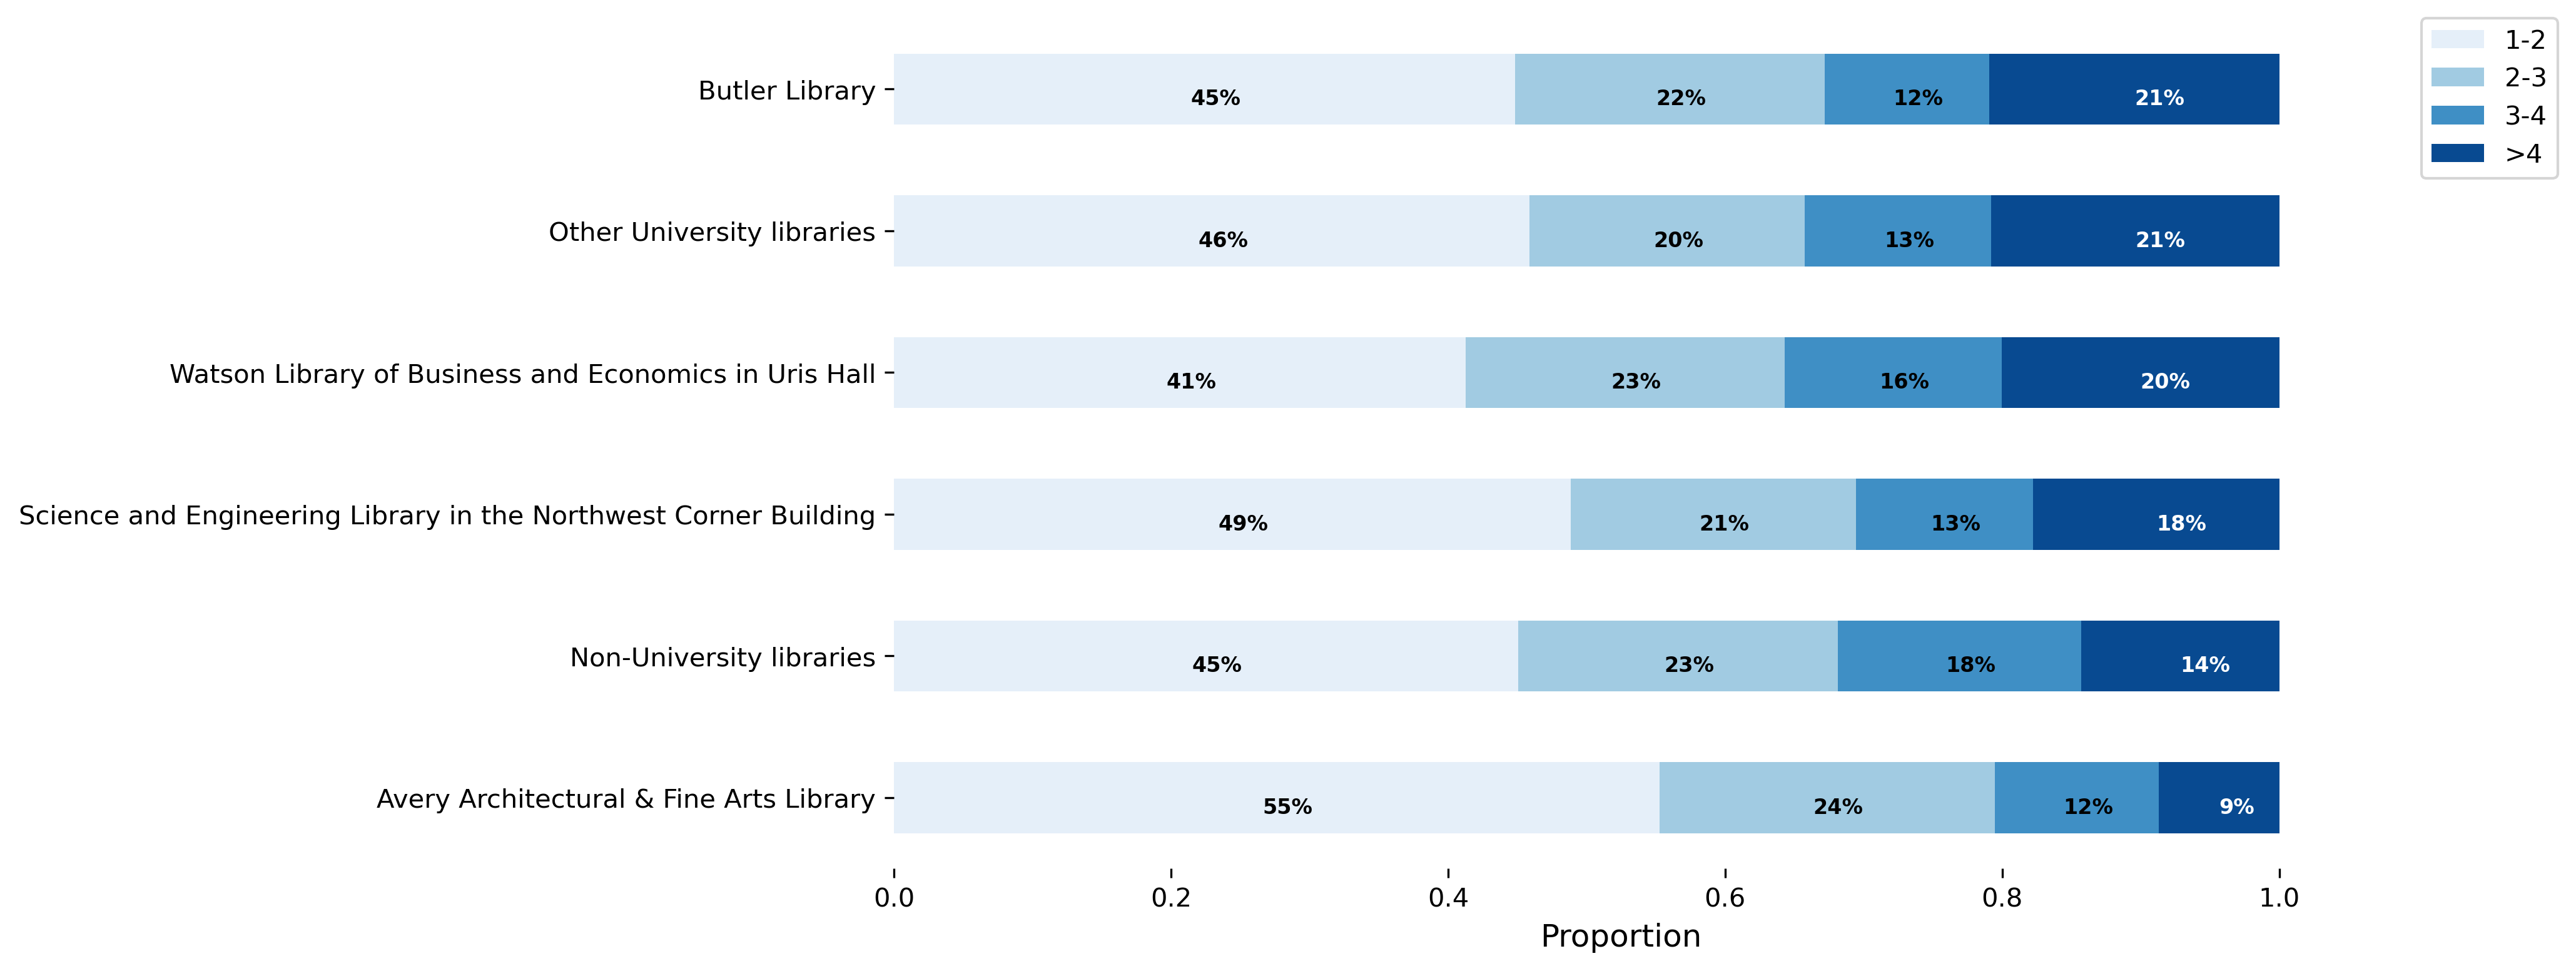

In [101]:
lib_fre_count=lib_fre.apply(pd.value_counts,axis=0)
lib_fre_count.drop(index="0-1",inplace=True)
b_prob=(lib_fre_count).apply(lambda x: x / x.sum(), axis=0)
aaa=(b_prob[(b_prob.iloc[3:,:].sum()).sort_values().index]).T

bbb=b_prob[(b_prob.iloc[3:,:].sum()).sort_values().index].T


fig,ax=plt.subplots(figsize=(8,6),dpi=300)
bbb.plot(kind='barh', stacked=True,colormap=cmap, figsize=(10, 6),ax=ax)
#pd.DataFrame(b) 
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., ncol=1)

#df3_1_cafe_count.index.name = 'rate'
#df3_1_cafe_count.columns.name = 'features'

#plt.ylabel("Resources")
plt.xlabel("Proportion",fontsize=12)
#plt.title("Overall Student Satisfaction: by Degree",fontsize=20)


for n, x in enumerate([*aaa.index.values]):
    m=4
    for (proportion, count, y_loc) in zip(bbb.loc[x],
                                          aaa.loc[x],
                                          bbb.loc[x].cumsum()):
        
        if m<2:
                 plt.text(x=(y_loc - proportion) + (proportion / 2),
                 y=n - 0.11,
                 #s=f'{str(count).split(".")[0]}', 
                 s=f'{str(np.round(proportion * 100)).split(".")[0]}%',
                 color="white",
                 fontsize=8,
                 fontweight="bold")
        if m>=2:
                plt.text(x=(y_loc - proportion) + (proportion / 2)-0.01,
                 y=n - 0.11,
                 #s=f'{str(count).split(".")[0]}',
                 s=f'{str(np.round(proportion * 100)).split(".")[0]}%',
                 color="black",
                 fontsize=8,
                 fontweight="bold")
        m-=1
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)


plt.show()

Please enter any suggestions or additional comments regarding library resources for engineers at Columbia below:


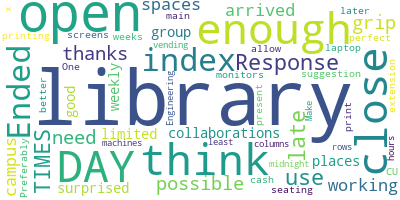

In [884]:
lib_com=query_data(Q,qq,cleaned_data,"comments regarding library resources for engineers at Columbia below:",indx=1).dropna()
lib_com.to_csv("output/lib_com.csv")
(lib_com).reset_index(inplace=True)
long_string = (str((lib_com)))
long_string = long_string.replace('libraries','library')
long_string = long_string.replace('please','')
long_string = long_string.replace('make','')
long_string = long_string.replace('','')
wordcloud = WordCloud(background_color="white", max_words=1000, contour_width=3,random_state=2,  contour_color='skyblue')
wordcloud.generate(long_string)
    #path = f'../fig/Restaurant_{i}stars_wordcloud.png'
    #print(f"Word Cloud for {i} stars Restaurant")
fig = wordcloud.to_image()
display(fig)
    #fig.save(path)

### gender-neutral bathrooms

In [211]:
gnb=query_data(Q,qq,cleaned_data,"gender-neutral bathrooms",indx=1)
indgnb=['I was unaware of \n the gender-neutral \n bathrooms in Mudd','No','Yes']

Are you satisfied with the gender-neutral bathrooms in Mudd and Engineering Terrace?


In [213]:
#cm = plt.cm.get_cmap('RdYlBu')

gnb_gender=gnb.copy()
gnb_gender=gnb_gender.join(gender)

gender_c=['Female','Male','Non-binary','Do not identify as female, male, or non-binary','I prefer not to answer','Prefer to self-describe']
b=pd.DataFrame(columns=gender_c) 
for i in gender_c:
    data_used=gnb_gender.loc[gnb_gender[i].isna()!=True,'Response.22']
    b[i]=(pd.DataFrame(data_used.value_counts()).fillna(0)/pd.DataFrame(data_used).count(axis=0)*100)
    #print(pd.DataFrame(data_used).count(axis=0))  
 #b.append(a)
b.fillna(0,inplace=True)
b=b[['Prefer to self-describe','I prefer not to answer','Female','Male','Non-binary','Do not identify as female, male, or non-binary']]
b_prob=b.apply(lambda x: x / x.sum(), axis=0)
aaa=b.sort_index().T
bbb=b_prob.sort_index().T

In [214]:
gnb_gender['Response.22']

0                                                          No
2       I was unaware of the gender-neutral bathrooms in Mudd
5       I was unaware of the gender-neutral bathrooms in Mudd
6                                                          No
7       I was unaware of the gender-neutral bathrooms in Mudd
                                ...                          
1585                                                      Yes
1586                                                      Yes
1587                                                      Yes
1588                                                      Yes
1590                                                      Yes
Name: Response.22, Length: 1271, dtype: object

In [85]:
bbb

I was unaware of the gender-neutral bathrooms in Mudd  \
Prefer to self-describe                                                                  0.500000       
I prefer not to answer                                                                   0.511111       
Female                                                                                   0.513570       
Male                                                                                     0.462411       
Non-binary                                                                               0.200000       
Do not identify as female, male, or non-binary                                           0.000000       

                                                      No       Yes  
Prefer to self-describe                         0.500000  0.000000  
I prefer not to answer                          0.088889  0.400000  
Female                                          0.056367  0.430063  
Male                                            0.045390  0.492199  
Non-binary                                      0.133333  0.666667  
Do not identify as female, male, or non-binary  0.000000  1.000000

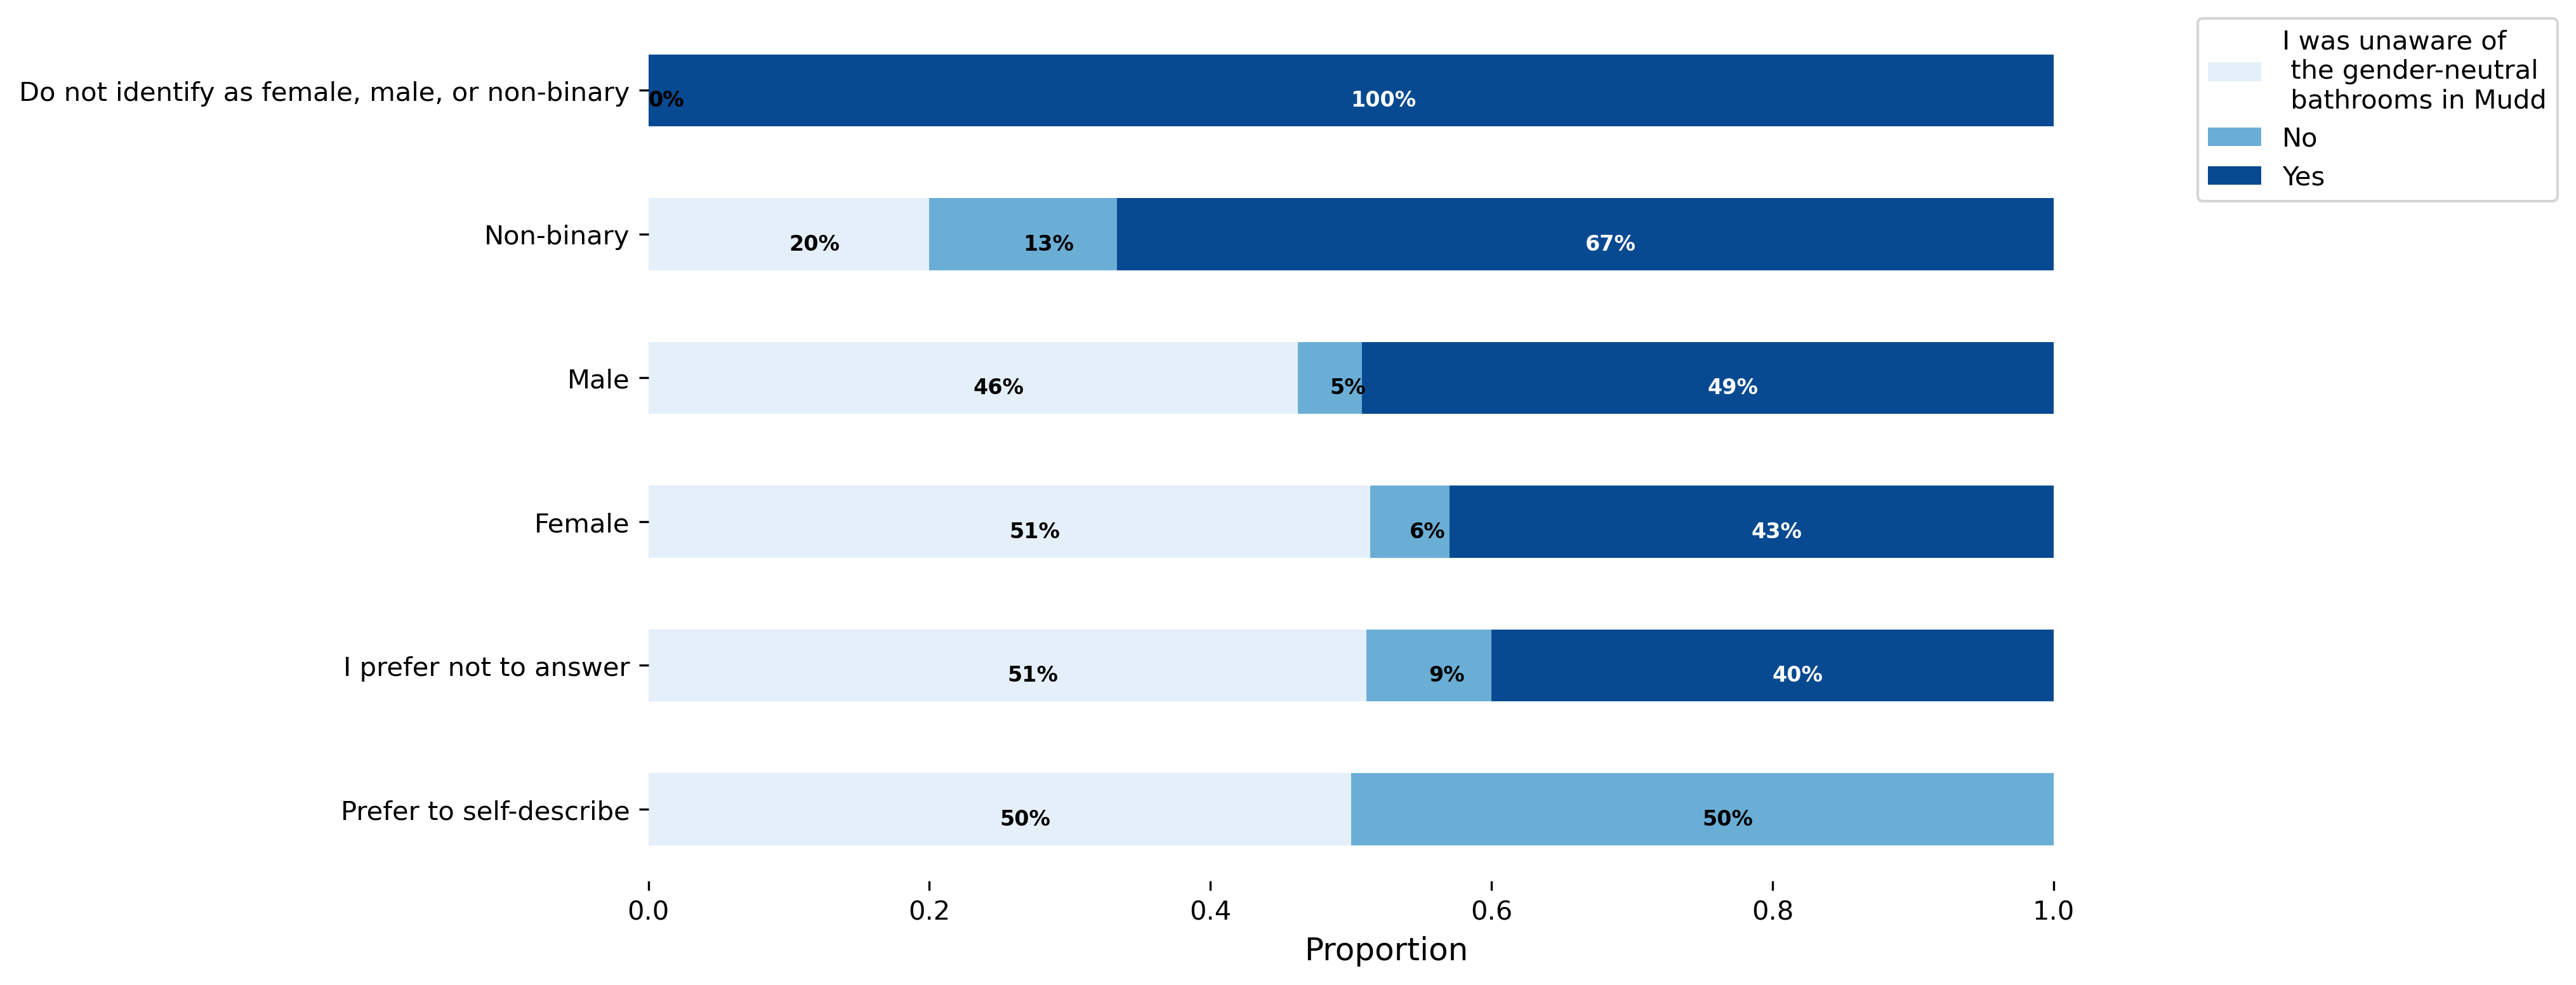

In [89]:
fig,ax=plt.subplots(figsize=(8,6),dpi=300)
b_prob.sort_index().T.plot(kind='barh', stacked=True,colormap=cmap, figsize=(10, 6),ax=ax)
#pd.DataFrame(b) 
plt.legend(indgnb,bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., ncol=1)

#plt.ylabel("Resources")
plt.xlabel("Proportion",fontsize=12)
#plt.title("Overall Student Satisfaction: by Degree",fontsize=20)


for n, x in enumerate([*aaa.index.values]):
    m=3
    for (proportion, count, y_loc) in zip(bbb.loc[x],
                                          aaa.loc[x],
                                          bbb.loc[x].cumsum()):
        
        if m<2:
                 plt.text(x=(y_loc - proportion) + (proportion / 2),
                 y=n - 0.11,
                 s=f'{str(np.round(proportion * 100)).split(".")[0]}%',
                          #s=f'{str(count).split(".")[0]}', 
                 color="white",
                 fontsize=8,
                 fontweight="bold")
        if m>=2:
            
                plt.text(x=(y_loc - proportion) + (proportion / 2),
                 y=n - 0.11,
                 s=f'{str(np.round(proportion * 100)).split(".")[0]}%',
                         #s=f'{str(count).split(".")[0]}', 
                 color="black",
                 fontsize=8,
                 fontweight="bold")
        m-=1
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)


plt.show()

## SEL

In [215]:
sel=query_data(Q,qq,cleaned_data,"Engineering Library",indx=1).copy()
sel.replace(2,1,inplace=True)
sel.replace(4,5,inplace=True)
sel_count=sel.apply(pd.value_counts,axis=0)
sel_count


The following resources at Science and Engineering Library are useful to me:


Individual study and/or work space  Group study and/or work space  \
1                                  96                            130   
3                                 332                            389   
5                                 843                            752   

   Reference materials  Computer terminal  Printing and scanning facilities  \
1                  151                168                               102   
3                  622                532                               368   
5                  498                571                               801   

   Hours of operation  
1                 127  
3                 419  
5                 725

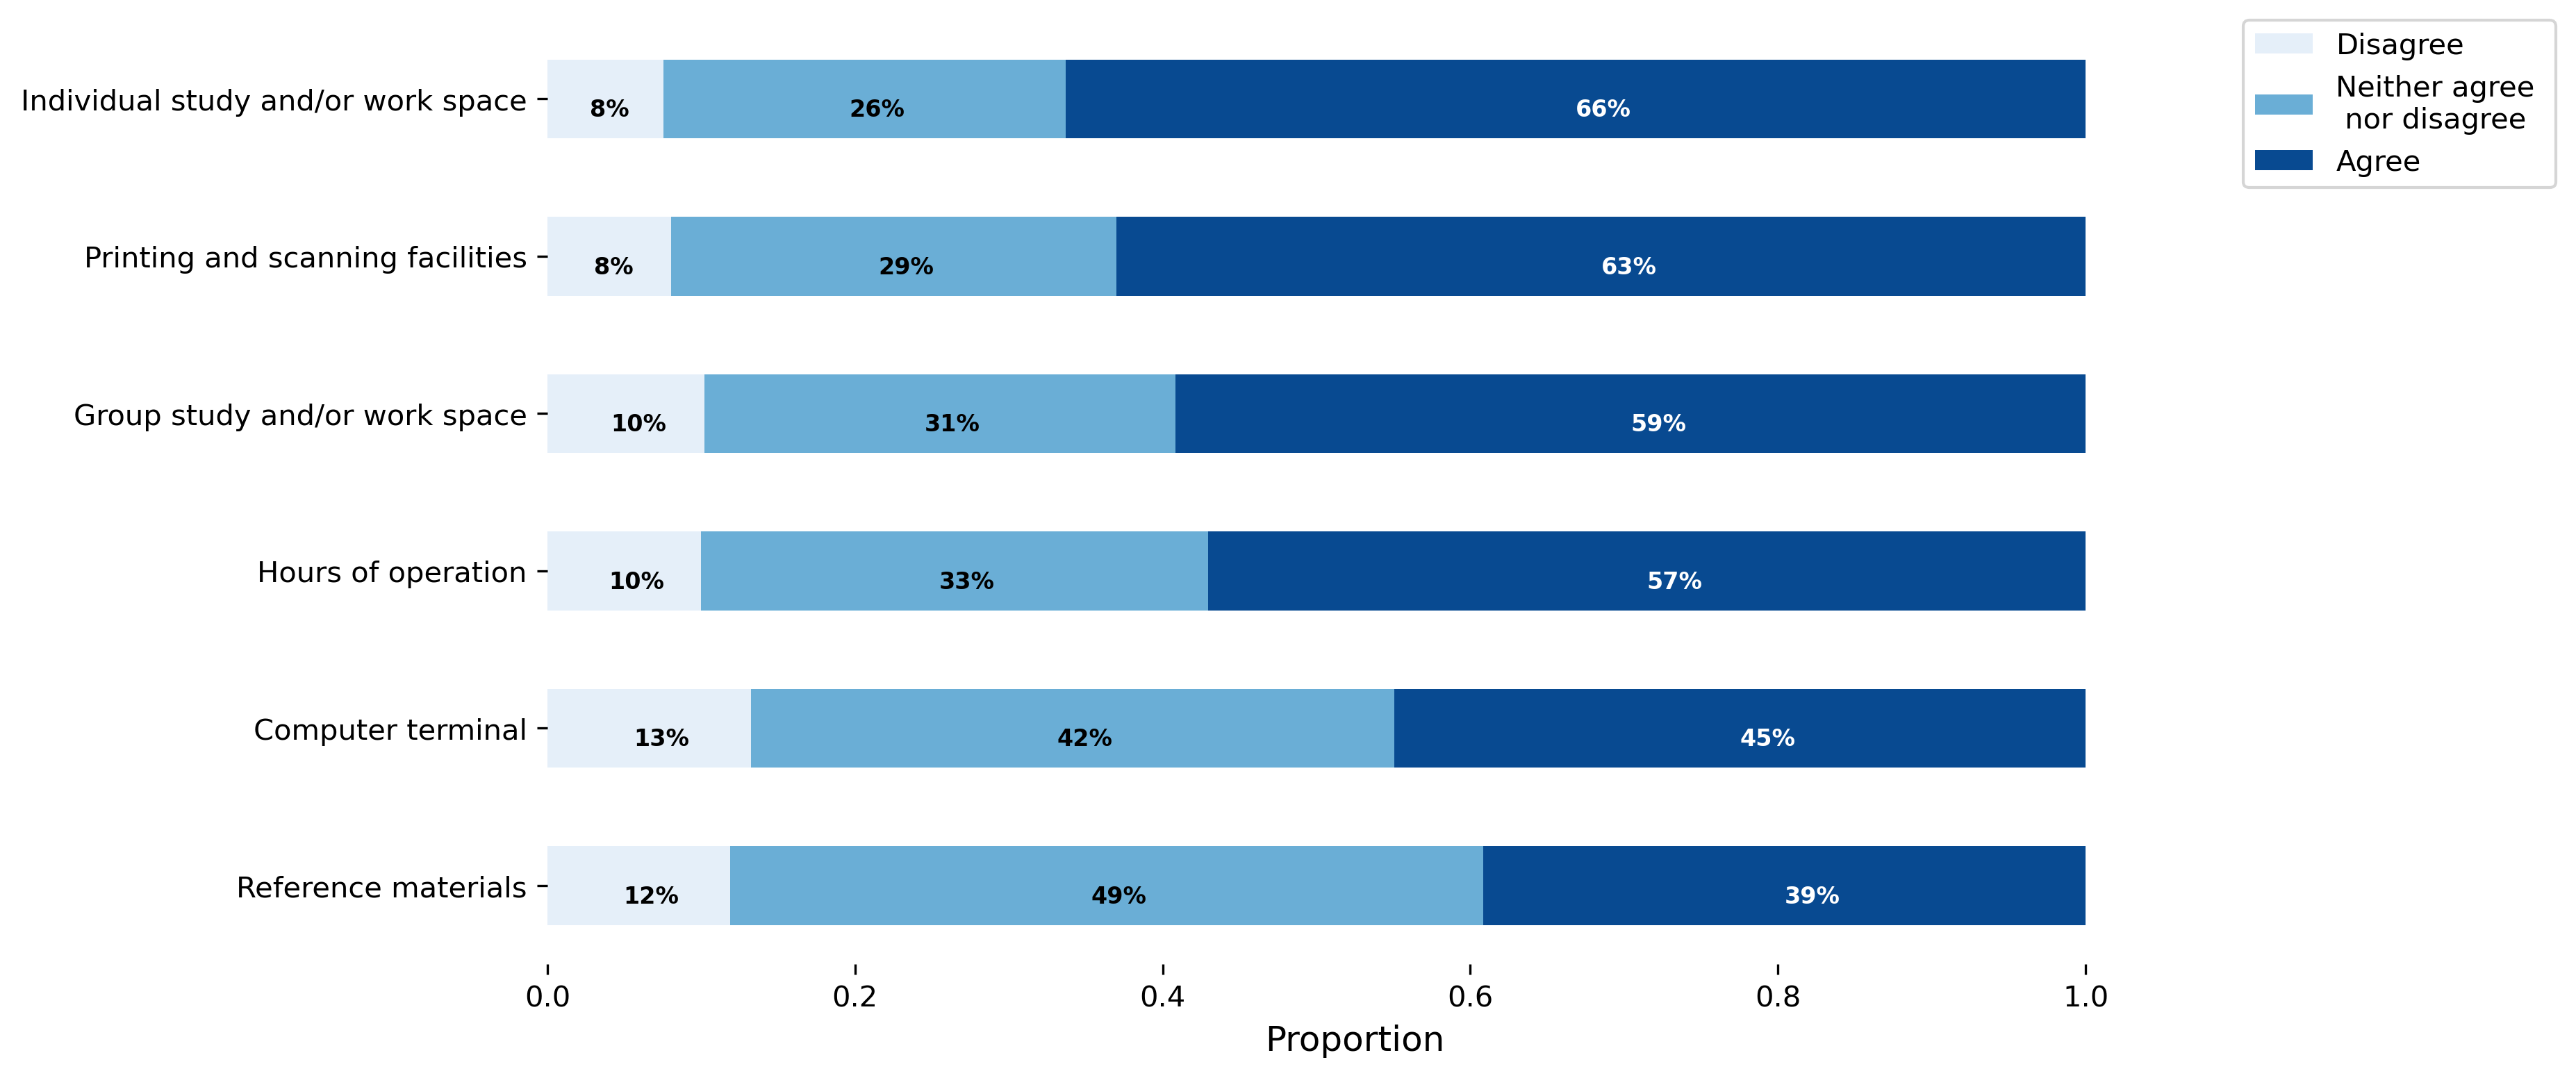

<AxesSubplot:xlabel='Proportion'>

In [216]:
plot_3_cat(sel_count)

## Facility

In [749]:
inddf=['Strongly agree','Agree','Neither agree \n nor disagree','Disagree','Strongly disagree','Not Applicable']

University Gym  \
0             190   
1             169   
2             177   
3             229   
4             293   
5             213   

   Availability of transportation to the CUIMC campus on the weekends  \
0                                                                 396   
1                                                                  49   
2                                                                  64   
3                                                                 311   
4                                                                 251   
5                                                                 200   

   Columbia Makerspace  Computer Lab at the Engineering Terrace 251/252  \
0                  413                                              404   
1                   18                                               16   
2                   21                                               29   
3                  307                                              326   
4                  301                                              292   
5                  211                                              204   

   Availability of reservable student group space  \
0                                             165   
1                                              80   
2                                             160   
3                                             263   
4                                             379   
5                                             224   

   Quality and maintenance of equipment in labs  \
0                                           291   
1                                            18   
2                                            53   
3                                           260   
4                                           397   
5                                           252   

   Availability of group study space  \
0                                105   
1                                 77   
2                                179   
3                                242   
4                                420   
5                                248   

   Availability of advanced computing resources  \
0                                           251   
1                                            24   
2                                            70   
3                                           309   
4                                           370   
5                                           247   

   Availability of engineering specific software in libraries/computer labs  \
0                                                                       262   
1                                                                        19   
2                                                                        56   
3                                                                       313   
4                                                                       376   
5                                                                       245   

   Availability of engineering specific software that can be installed on your personal computer  \
0                                                                                            154   
1                                                                                             59   
2                                                                                            123   
3                                                                                            267   
4                                                                                            399   
5                                                                                            269   

   Department lounge  Carleton Commons  Elevators in Mudd building  \
0                157               212                          49   
1                 82                16               

In [219]:
fac=query_data(Q,qq,cleaned_data,"I am satisfied with the following.",indx=3).copy()
fac.replace("Not Applicable",0,inplace=True)
fac.replace(2,1,inplace=True)
fac.replace(4,5,inplace=True)
fac_count=fac.apply(pd.value_counts,axis=0)
fac0=fac_count[(fac_count.iloc[3:,:].sum()).sort_values().index]
fac1=fac0.iloc[:,:10].copy()
fac1.drop(index=0,inplace=True)

I am satisfied with the following.


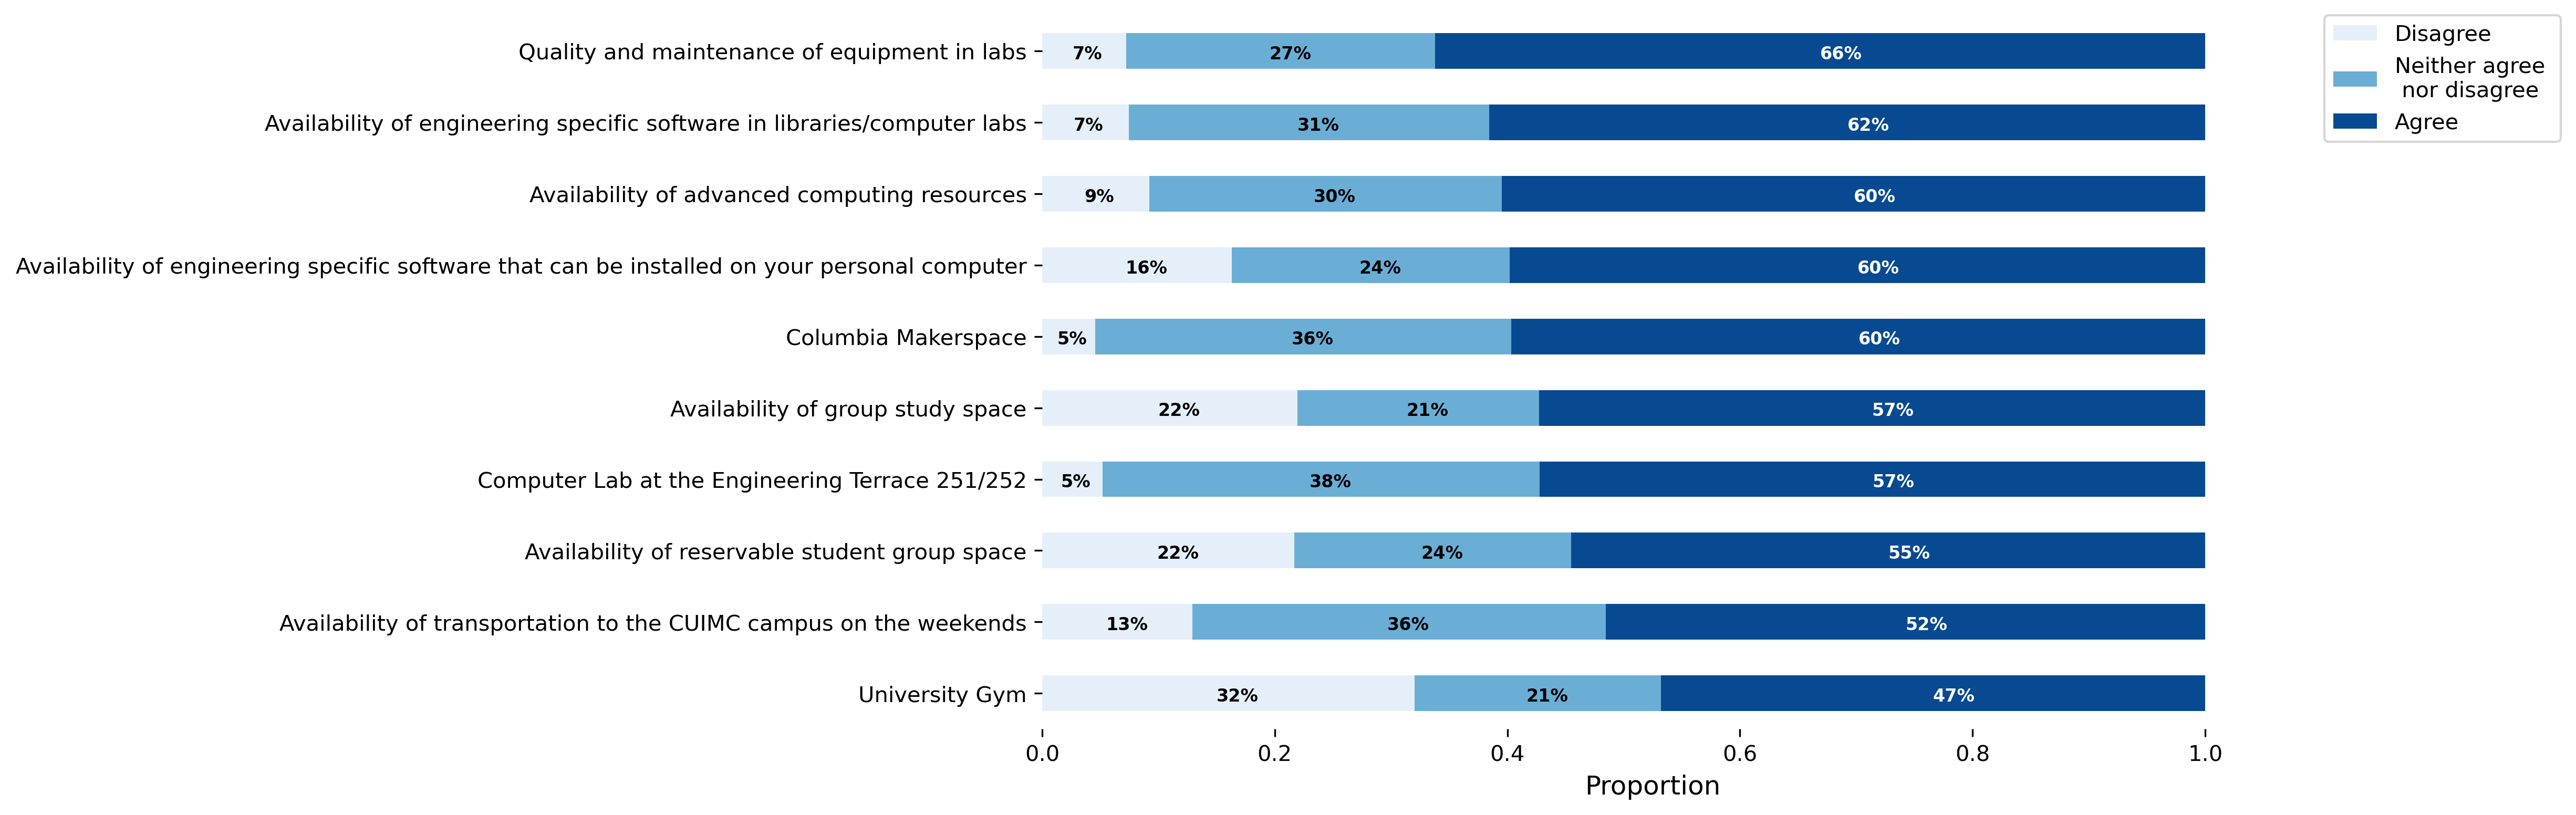

<AxesSubplot:xlabel='Proportion'>

In [220]:
plot_3_cat(fac1)

In [222]:
#fac1_count=fac1.apply(pd.value_counts,axis=0)
fac1_prob=(fac1).apply(lambda x: x / x.sum(), axis=0)
proind=(fac1_prob.iloc[2:,:].sum()).sort_values().index
aaa=(fac1[proind]).T
bbb=fac1_prob[proind].T
#bbb

In [227]:
fac2=fac0.iloc[:,10:].copy()
#fac1_count=fac1.apply(pd.value_counts,axis=0)
fac2.drop(index=0,inplace=True)
fac2_prob=(fac2).apply(lambda x: x / x.sum(), axis=0)
#proind2=(fac2_prob.iloc[2:,:].sum()).sort_values().index
#aaa=(fac2[proind]).T
#bbb=fac2_prob[proind].T
#proind2

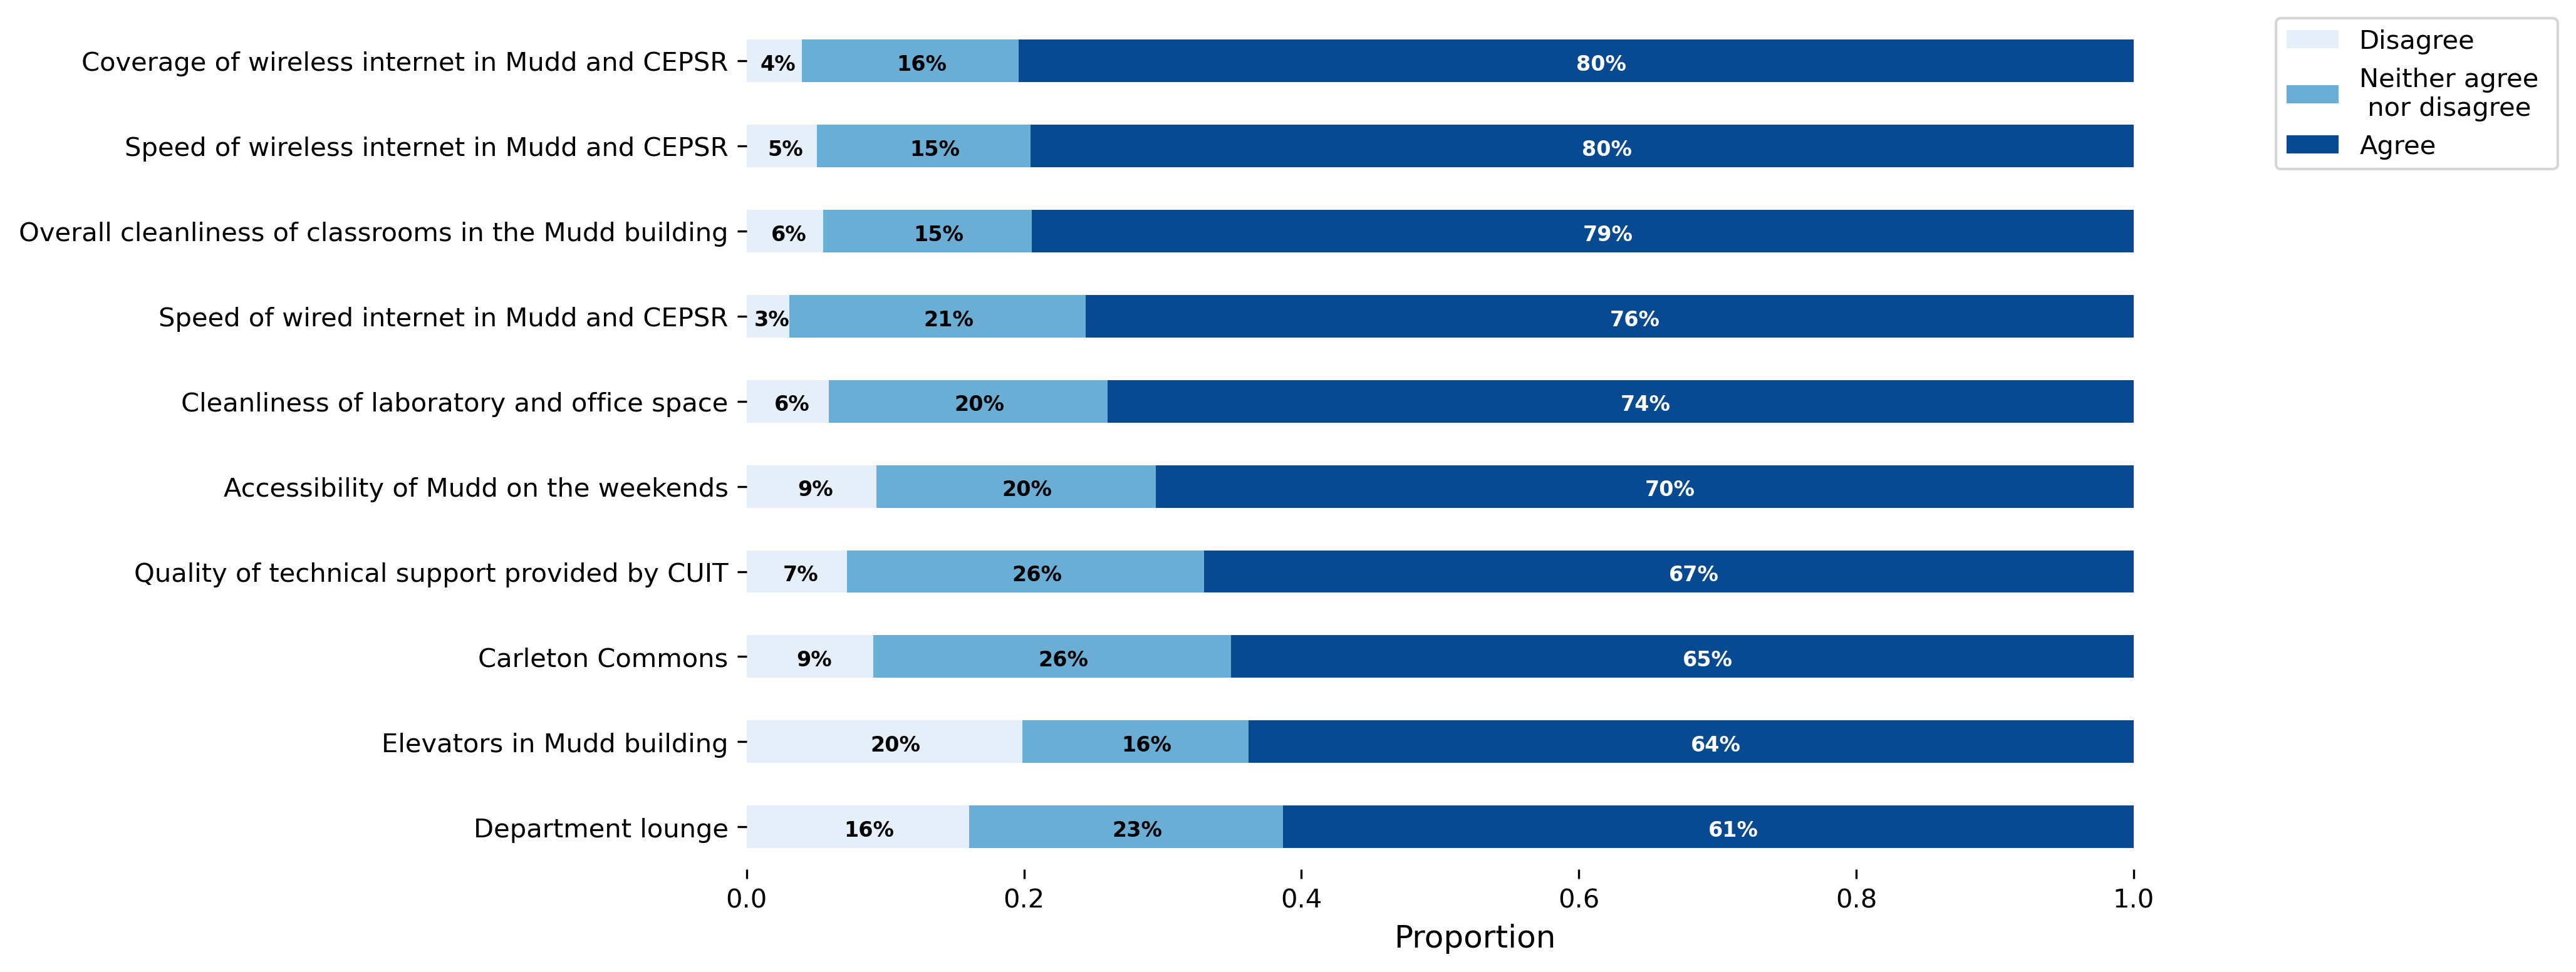

<AxesSubplot:xlabel='Proportion'>

In [229]:
plot_3_cat(fac2)

In [172]:
pd.DataFrame((query_data(Q,qq,cleaned_data_text,"after-hour",indx=0)).value_counts())

I am satisfied with the weekday after-hours and weekend swipe access for the 1st floor Mudd entrance.


0
Response.24                    
Agree                       495
Neither agree nor disagree  410
Strongly agree              151
Strongly disagree           114
Disagree                    101

In [175]:
pd.DataFrame((query_data(Q,qq,cleaned_data_text,"after hour",indx=0)).value_counts())

To what extent have you used the Mudd 1st floor after hour swipe access on a weekly basis?


0
Saturdays  Sundays    Weekday evenings     
0-2 times  0-2 times  0-2 times         731
                      2-5 times         140
2-5 times  2-5 times  2-5 times          90
10+ times  10+ times  10+ times          50
2-5 times  2-5 times  5-10 times         35
5-10 times 5-10 times 5-10 times         34
0-2 times  0-2 times  5-10 times         31
2-5 times  0-2 times  2-5 times          24
           2-5 times  10+ times          15
                      0-2 times          11
           0-2 times  0-2 times           9
5-10 times 5-10 times 10+ times           9
2-5 times  0-2 times  5-10 times          8
5-10 times 2-5 times  5-10 times          5
           5-10 times 2-5 times           4
0-2 times  0-2 times  10+ times           4
5-10 times 2-5 times  2-5 times           4
0-2 times  2-5 times  5-10 times          3
                      0-2 times           2
5-10 times 0-2 times  10+ times           2
10+ times  5-10 times 10+ times           2
2-5 times  0-2 times  10+ times           2
0-2 times  2-5 times  2-5 times           2
10+ times  2-5 times  10+ times           2
5-10 times 0-2 times  2-5 times           2
                      0-2 times           2
           2-5 times  10+ times           1
           10+ times  5-10 times          1
0-2 times  5-10 times 5-10 times          1
2-5 times  5-10 times 0-2 times           1
0-2 times  10+ times  10+ times           1
10+ times  0-2 times  10+ times           1
                      2-5 times           1
           10+ times  0-2 times           1
           5-10 times 2-5 times           1
           2-5 times  2-5 times           1
0-2 times  2-5 times  10+ times           1

## Career Development

Are you currently looking for a job or plan to look for one in the near future?

In [134]:
lookingforjob=query_data(Q,qq,cleaned_data,"looking for a job",indx=1)
lookingforjob.value_counts()

Are you currently looking for a job or plan to look for one in the near future?


Response.10
Yes            928
No             264
Not Sure        79
dtype: int64

The following resources have been/were useful in aiding my job search:

In [ ]:
jobres=query_data(Q,qq,cleaned_data,"job search",indx=1)
jobres['looking']=lookingforjob
jobres

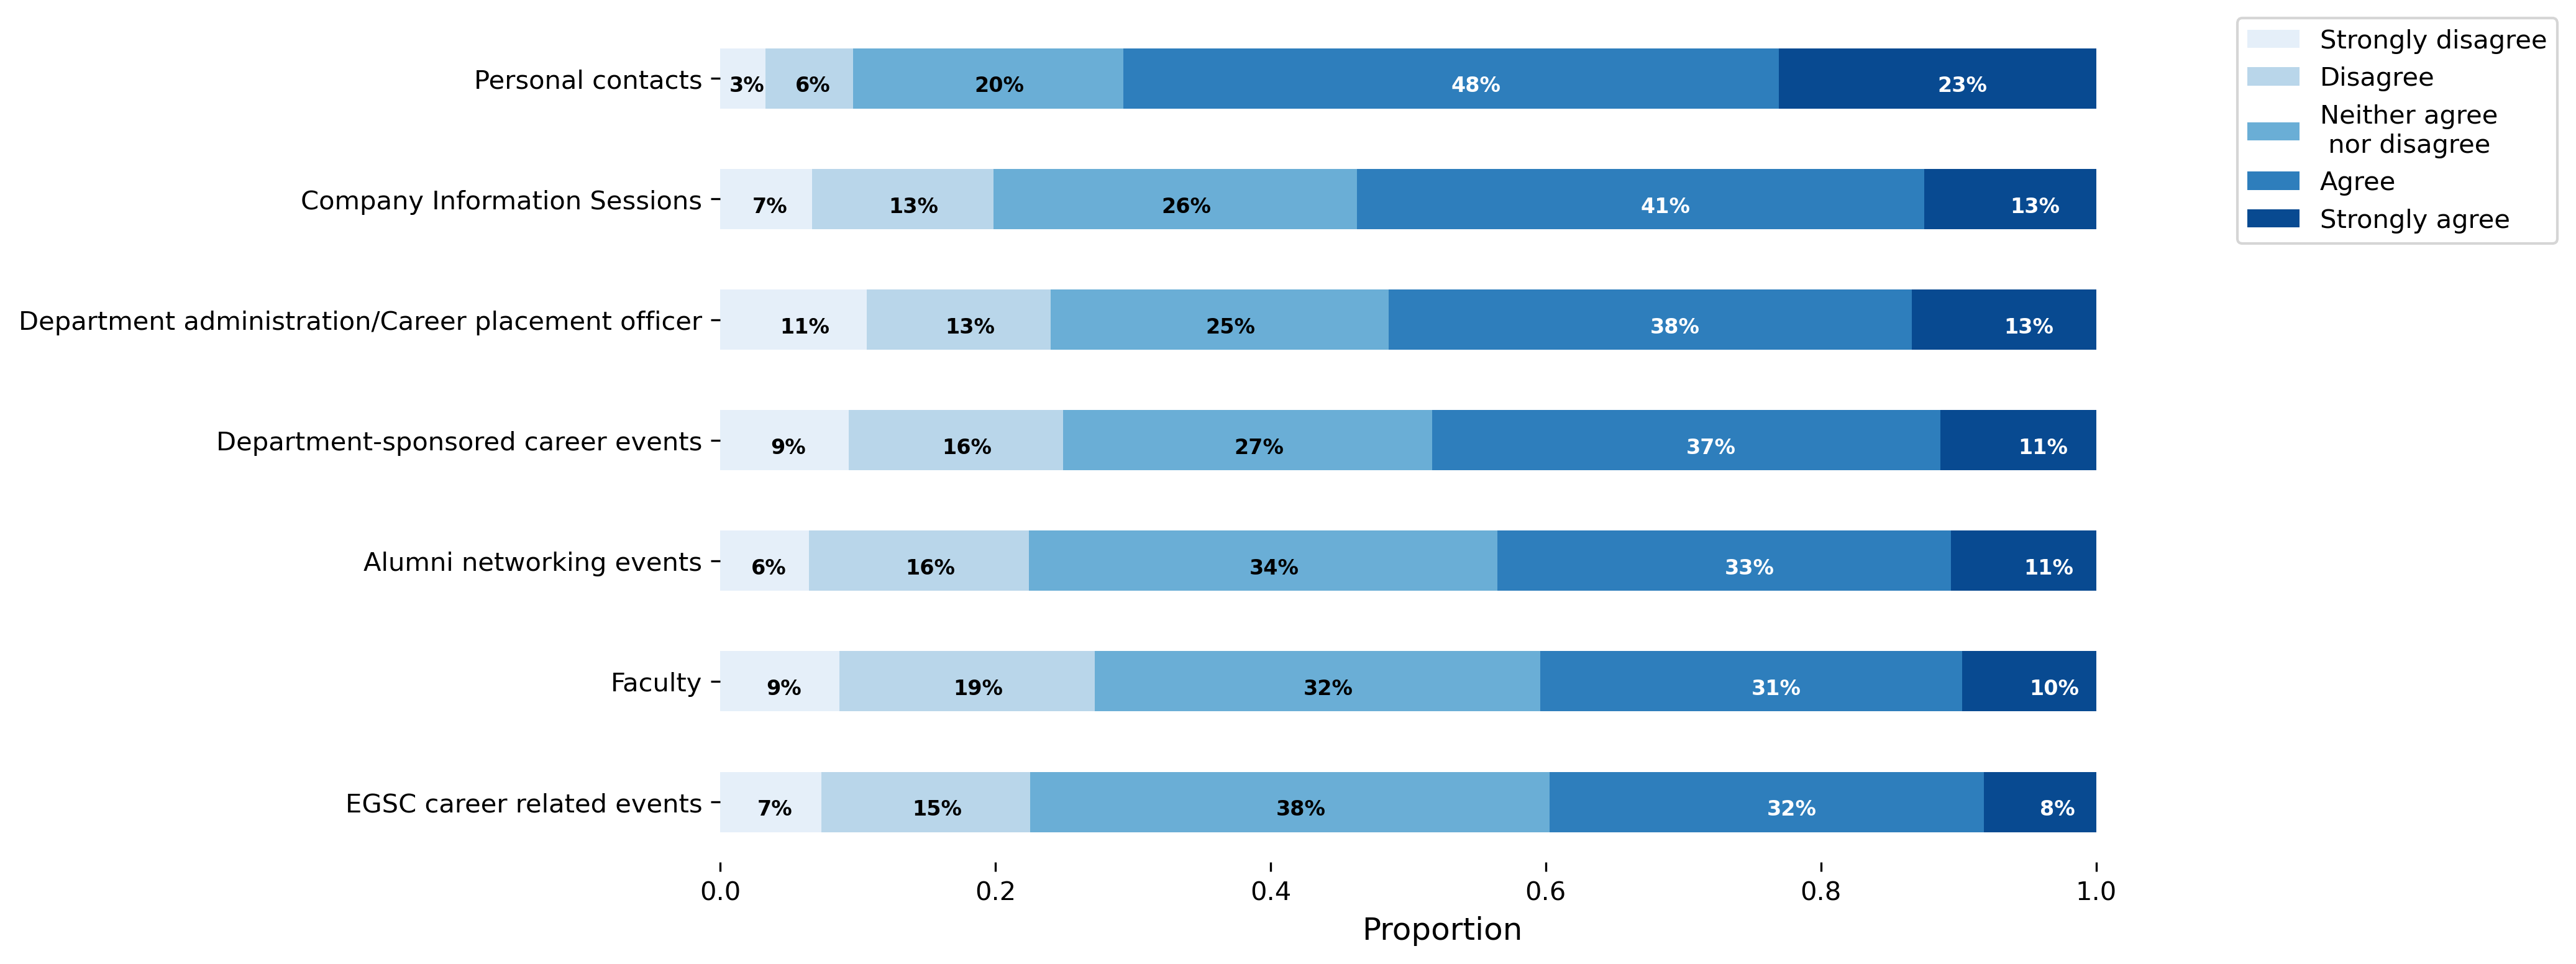

In [148]:

inddd=['Strongly agree','Agree','Neither agree \n nor disagree','Disagree','Strongly disagree','Unaware of this resource']

lokres=jobres[jobres['looking']!="No"].drop(columns="looking")
lokres_count=lokres.apply(pd.value_counts,axis=0)
d_=lokres_count[(lokres_count.iloc[3:,:].sum()).sort_values().index]
b_prob=d_.apply(lambda x: x / x.sum(), axis=0)
aaa=d_.T
bbb=b_prob.T


fig,ax=plt.subplots(figsize=(8,6),dpi=300)
b_prob.T.plot(kind='barh', stacked=True,colormap=cmap, figsize=(10, 6),ax=ax)
#pd.DataFrame(b) 
plt.legend(inddd[:-1][::-1],bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., ncol=1)

#df3_1_cafe_count.index.name = 'rate'
#df3_1_cafe_count.columns.name = 'features'

#plt.ylabel("Resources")
plt.xlabel("Proportion",fontsize=12)
#plt.title("Overall Student Satisfaction: by Degree",fontsize=20)


for n, x in enumerate([*aaa.index.values]):
    m=5
    for (proportion, count, y_loc) in zip(bbb.loc[x],
                                          aaa.loc[x],
                                          bbb.loc[x].cumsum()):
        
        if m<3:
                 plt.text(x=(y_loc - proportion) + (proportion / 2),
                 y=n - 0.11,
                 #s=f'{str(count).split(".")[0]}', 
                 s=f'{str(np.round(proportion * 100)).split(".")[0]}%',
                 color="white",
                 fontsize=8,
                 fontweight="bold")
        if m>=3:
            if count>20:
                plt.text(x=(y_loc - proportion) + (proportion / 2)-0.01,
                 y=n - 0.11,
                 #s=f'{str(count).split(".")[0]}', 
                 s=f'{str(np.round(proportion * 100)).split(".")[0]}%',
                 color="black",
                 fontsize=8,
                 fontweight="bold")
        m-=1
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)


plt.show()

In [105]:
gcpres=query_data(Q,qq,cleaned_data,"job search",indx=2)
gcpres['department']=department

gcpdep=pd.DataFrame(gcpres.groupby(['department']).mean())
gcpdep

The following Graduate Career Placement (GCP) resources have been/were useful in my job search and application process.


/var/folders/_r/5vgvtlc95cvfjt0qzlww6hhm0000gn/T/ipykernel_15598/534010401.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gcpres['department']=department


GCP Website  Career Placement Officers  Career Fairs  \
department                                                                      
APAM                        3.224138                   3.275862      3.206897   
BMEN                        2.985507                   3.304348      3.072464   
CEEM                        3.387097                   3.758065      3.774194   
CHEN                        2.970588                   3.176471      3.088235   
COMS                        2.708029                   2.788321      2.759124   
EAEE                        3.103448                   3.413793      3.586207   
ELEN                        3.101351                   3.506757      3.358108   
I prefer not to answer.     2.888889                   3.000000      2.888889   
IEOR                        2.980892                   3.133758      3.124204   
MECE                        3.126316                   3.336842      3.189474   
MSDS                        2.921053                   3.289474      3.289474   

                         Spring Employer Expo  GCP Employer Events  \
department                                                           
APAM                                 3.137931             3.224138   
BMEN                                 3.028986             3.007246   
CEEM                                 3.500000             3.435484   
CHEN                                 3.014706             3.132353   
COMS                                 2.704380             2.740876   
EAEE                                 3.310345             3.172414   
ELEN                                 3.175676             3.216216   
I prefer not to answer.              3.000000             2.888889   
IEOR                                 3.105096             3.050955   
MECE                                 3.210526             3.200000   
MSDS                                 3.131579             2.921053   

                         Career Workshops  Mock Interviews  \
department                                                   
APAM                             3.155172         3.137931   
BMEN                             3.159420         3.152174   
CEEM                             3.548387         3.370968   
CHEN                             3.102941         3.102941   
COMS                             2.751825         3.105839   
EAEE                             3.206897         3.275862   
ELEN                             3.277027         3.250000   
I prefer not to answer.          3.111111         3.222222   
IEOR                             3.159236         3.200637   
MECE                             3.305263         3.284211   
MSDS                             3.026316         3.302632   

                         Weekly Newsletters  Individual Counseling Sessions  \
department                                                                    
APAM                               3.224138                        3.155172   
BMEN                               3.282609                        3.217391   
CEEM                               3.370968                        3.548387   
CHEN                               3.088235                        3.264706   
COMS                               2.868613                        2.912409   
EAEE                               3.172414                        3.413793   
ELEN                               3.324324                        3.290541   
I prefer not to answer.            3.000000                        3.222222   
IEOR                               3.066879                        3.219745   
MECE                               3.094737                        3.357895   
MSDS                               3.289474                        3.144737   

                            VMock  Quick Questions or Walk-in hours  
department                                                           
APAM                     3.086207                          3.155172  
BMEN           

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


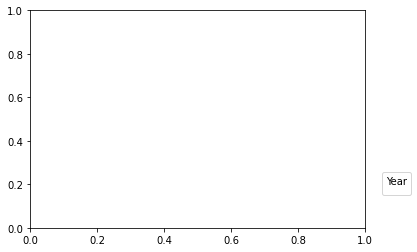

In [104]:

colors = cm.tab20(np.linspace(0, 1, (12)))


for i in range(1,8):
    ax.scatter(i, gcpdep.iloc[i,0],s=90,marker='^',label=gcpdep.columns[i],c=colors[i+1].reshape(1,-1))

for i in range(1,8):
    ax.scatter(i, gcpdep.iloc[i,1],s=90,marker='^',facecolors='none',edgecolors=colors[i+1].reshape(1,-1))

    
line1=ax.axhline(y=gcpdep.iloc[1,:-1].mean(),c='grey')
ax.axvline(x=gcpdep.iloc[0,:-1].mean(),c='grey' )


ax.set_xlim([3.370, 4.720])
ax.set_ylim([3.3, 4.3540])


#ax.set_title("Importance vs Satisfaction for all features",fontsize=22)


#second_legend=plt.legend(c.columns,bbox_to_anchor=(1, 2.5))
#second_legend=plt.legend(c.columns,loc="upper left")


#leg = plt.legend(,loc=(1.05,0.4), title="Year")


#import matplotlib.lines as mlines

import matplotlib.patches as mpatches

grey_triangle1 = ax.scatter([], [], color='grey', marker='^', linestyle='None')
grey_triangle2 = ax.scatter([], [], color='grey', marker='^', facecolors='none',edgecolors="grey",linestyle='None')

#first_legend=plt.legend([line1,line2],['2022','2019'],bbox_to_anchor=(1, 1.05))
plt.legend(loc=(1.05,0.15), title="Year")


ax.set_xlabel("Importance",fontsize=14)
ax.set_ylabel("Satisfaction",fontsize=14)


#ax.axhline(y=c2022.iloc[1,:].mean())
#ax.axvline(x=c2022.iloc[0,:].mean(),c='black' )

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)



plt.show()

The following Graduate Career Placement (GCP) resources have been/were useful in my job search and application process.


/var/folders/_r/5vgvtlc95cvfjt0qzlww6hhm0000gn/T/ipykernel_62112/775756620.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gcpres['looking']=lookingforjob


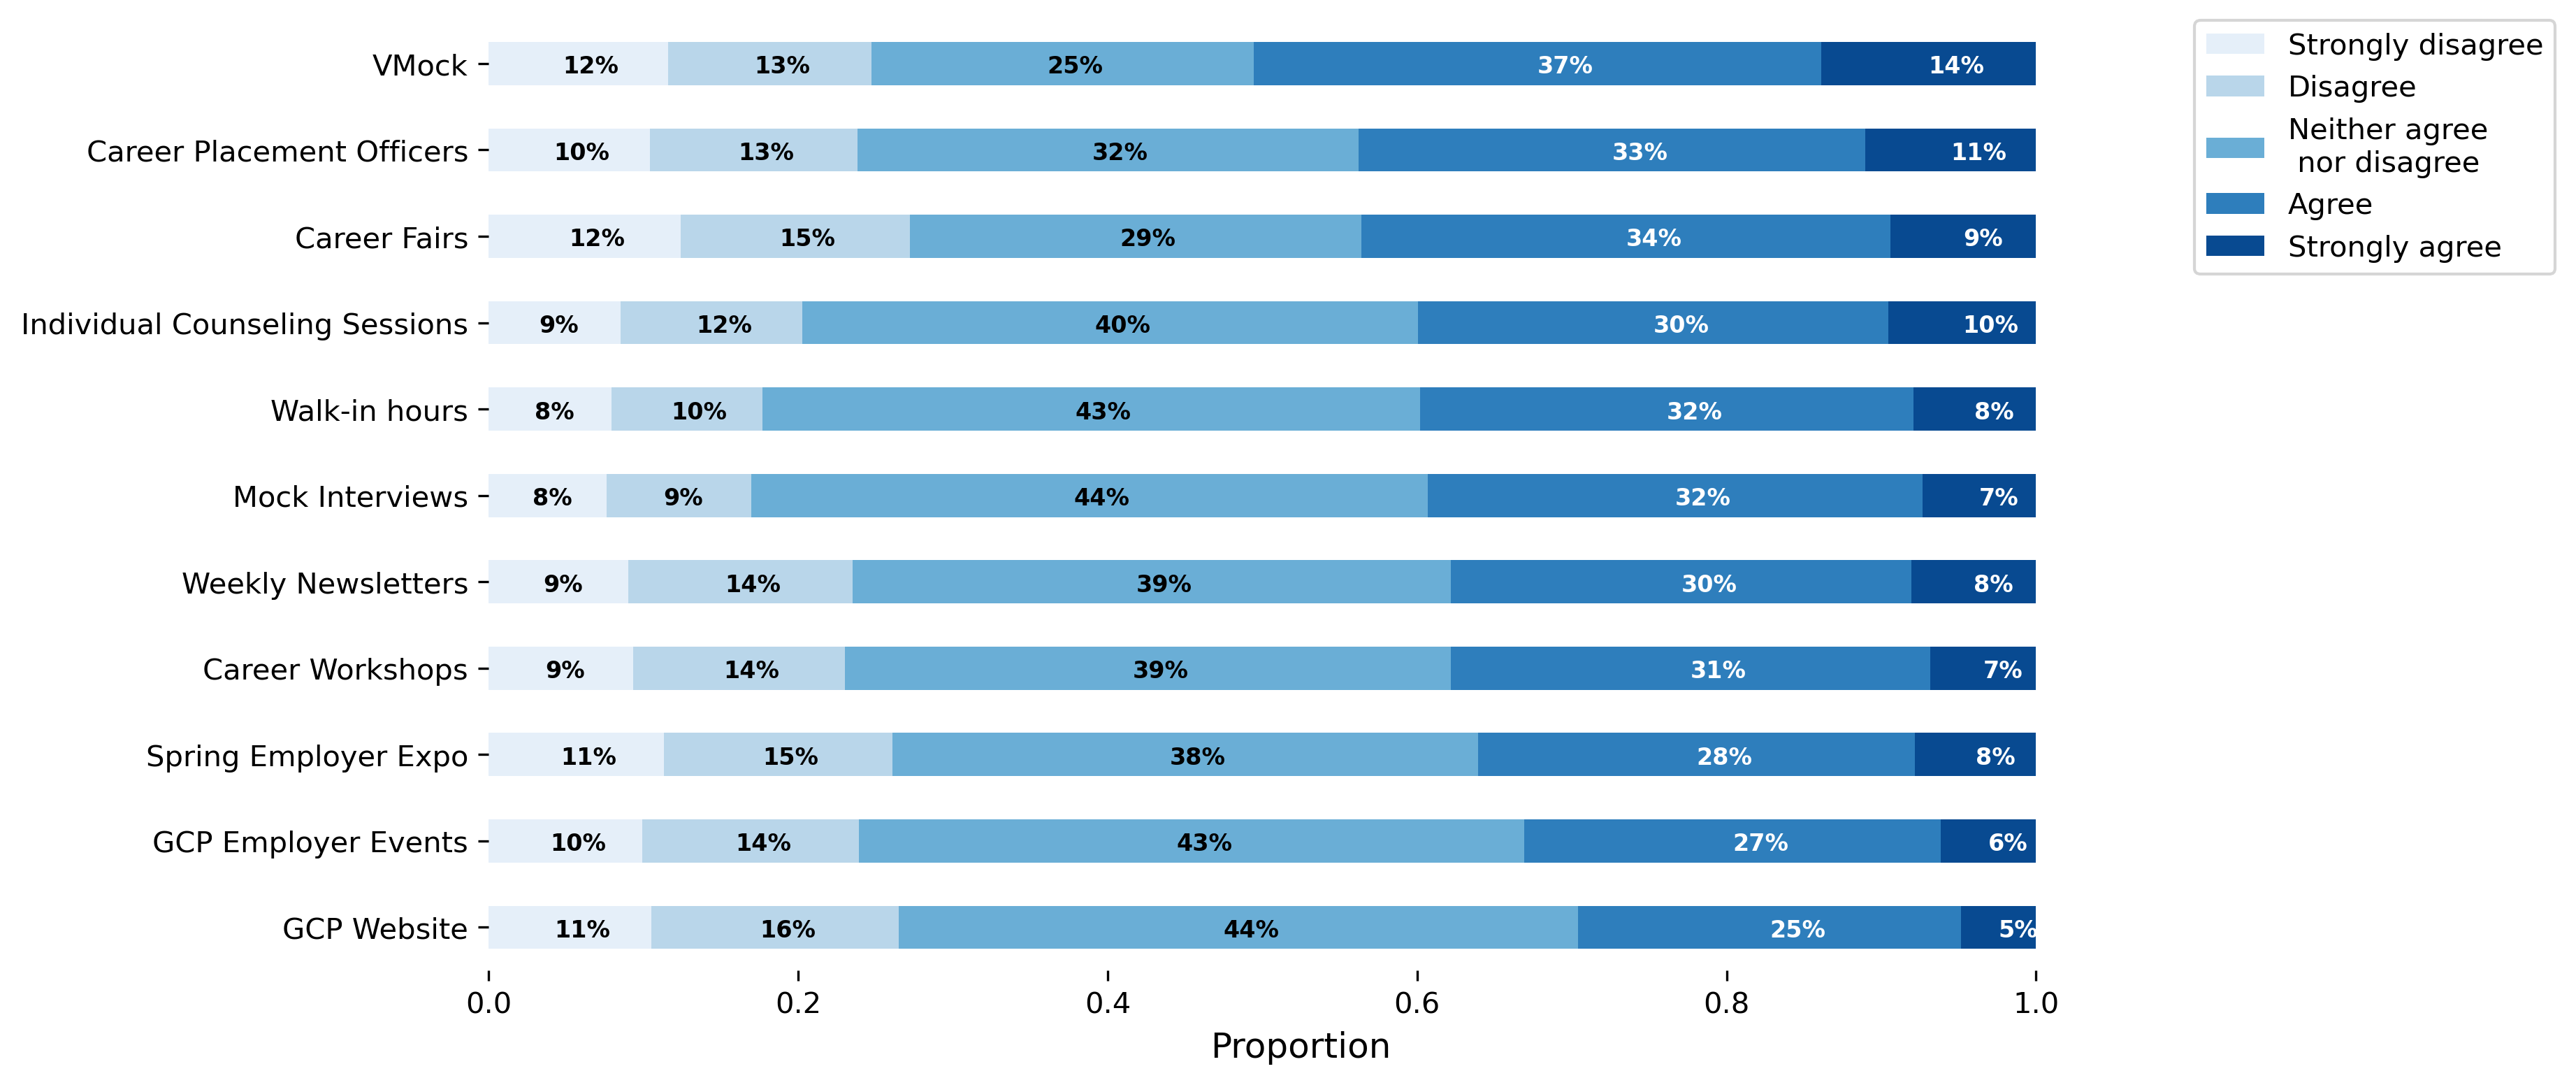

In [144]:
gcpres=query_data(Q,qq,cleaned_data,"job search",indx=2)
gcpres['looking']=lookingforjob
lokgcp=gcpres[gcpres['looking']!="No"].drop(columns="looking")

lokgcp_count=lokgcp.apply(pd.value_counts,axis=0)
lokgcp_count.rename(columns={'Quick Questions or Walk-in hours':'Walk-in hours'},inplace=True)
d_=lokgcp_count[(lokgcp_count.iloc[3:,:].sum()).sort_values().index]
b_prob=d_.apply(lambda x: x / x.sum(), axis=0)
aaa=d_.T
bbb=b_prob.T

cmap = mpl.cm.Blues(np.linspace(0,0.9,100))
cmap = mpl.colors.ListedColormap(cmap[10:,:-1])


fig,ax=plt.subplots(figsize=(8,8),dpi=300)
b_prob.T.plot(kind='barh', stacked=True,colormap=cmap, figsize=(10, 6),ax=ax)
#pd.DataFrame(b) 
plt.legend(inddd[:-1][::-1],bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., ncol=1)

#df3_1_cafe_count.index.name = 'rate'
#df3_1_cafe_count.columns.name = 'features'

#plt.ylabel("Resources")
plt.xlabel("Proportion",fontsize=12)
#plt.title("Overall Student Satisfaction: by Degree",fontsize=20)


for n, x in enumerate([*aaa.index.values]):
    m=5
    for (proportion, count, y_loc) in zip(bbb.loc[x],
                                          aaa.loc[x],
                                          bbb.loc[x].cumsum()):
        
        if m<3:
                 plt.text(x=(y_loc - proportion) + (proportion / 2),
                 y=n - 0.11,
                 #s=f'{str(count).split(".")[0]}', 
                 s=f'{str(np.round(proportion * 100)).split(".")[0]}%',
                 color="white",
                 fontsize=8,
                 fontweight="bold")
        if m>=3:
            if count>20:
                plt.text(x=(y_loc - proportion) + (proportion / 2)-0.01,
                 y=n - 0.11,
                 #s=f'{str(count).split(".")[0]}', 
                 s=f'{str(np.round(proportion * 100)).split(".")[0]}%',
                 color="black",
                 fontsize=8,
                 fontweight="bold")
        m-=1
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)


plt.show()

Are you currently looking for a job or plan to look for one in the near future?

In [1020]:
query_data(Q,qq,cleaned_data,"internship",indx=1).value_counts()

Have you secured a job offer or internship?


Response.14                          
No                                       544
Yes                                      479
I am not actively searching for a job    248
dtype: int64

In [968]:
intern=1271-query_data(Q,qq,cleaned_data,"secured",indx=2).isna().sum()

Which of the following have you secured?


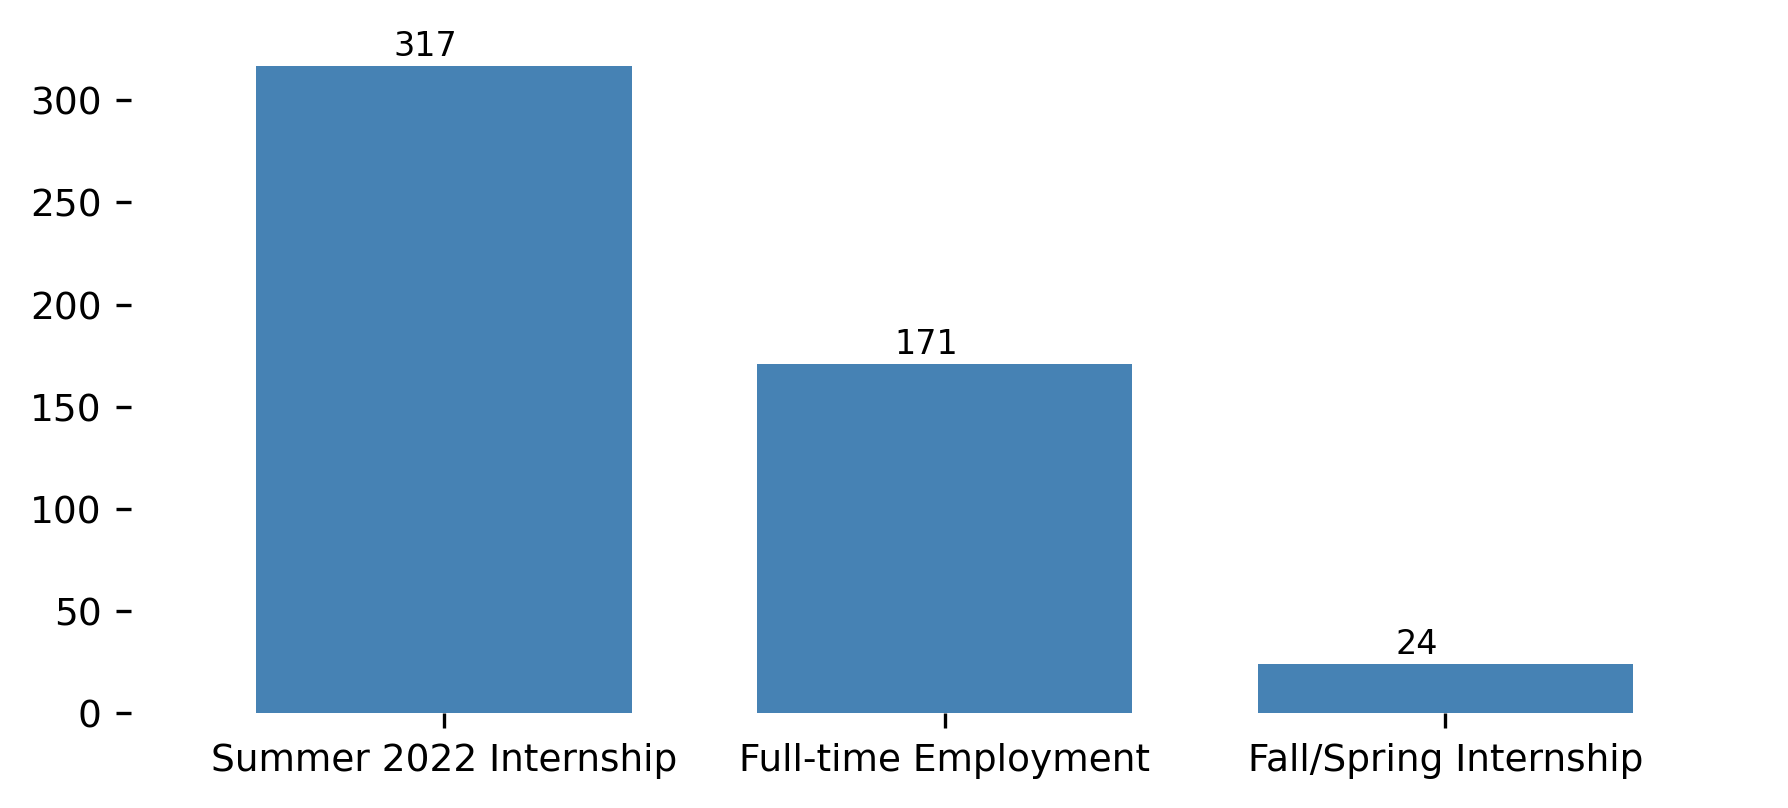

In [1006]:
fig,ax=plt.subplots(figsize=(7,3),dpi=300)
intern=pd.DataFrame(intern)
ax=intern.plot.bar(ax=ax,color="steelblue",width=0.75, rot=0 ,fontsize=9,legend=None)
#ax.set_xticklabels(indd, rotation=0,)
x_offset = -0.1
y_offset = 5
for p in ax.patches:
    b = p.get_bbox()
    val = "{}".format(b.y1 + b.y0)        
    ax.annotate(int(b.y1 + b.y0), ((b.x0 + b.x1)/2+ x_offset, b.y1+y_offset),fontsize=8)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

In [1027]:
query_data(Q,qq,cleaned_data,"job opening",indx=1)['Response.15'].value_counts()

Where did you find out about this job opening?


Company website                                                       144
LinkedIn                                                              129
Personal contacts and/or friends                                       79
Other (please specify)                                                 49
GCP (including VMock)                                                  23
Career fairs/Employer Expo Events                                      21
Advisor                                                                13
Career Placement Officers                                              13
Faculty                                                                 7
Department administration                                               4
Engineering Graduate Student Council (EGSC)/SEAS networking events      1
Name: Response.15, dtype: int64

In [1017]:
jobfind=query_data(Q,qq,cleaned_data,"job opening",indx=1)
lokint=query_data(Q,qq,cleaned_data,"internship",indx=1)
jobfind["Yes"]=lokint

Where did you find out about this job opening?
Have you secured a job offer or internship?


In [1025]:

jobfind[jobfind.Yes=="I am not actively searching for a job"]['Response.15'].dropna()
#jobfind[jobfind.Yes=="No"]['Response.15'].dropna()

81     Personal contacts and/or friends
144              Other (please specify)
Name: Response.15, dtype: object

Have you secured a job offer or internship?
Which of the following have you secured?

Where did you find out about this job opening?


## Health

In [232]:
health = query_data(Q,qq,cleaned_data,"services",indx=2).copy()
health.replace(2,1,inplace=True)
health.replace(4,5,inplace=True)
health = health.rename(columns=
                    {'Alice! organized workshops (Nutrition, Fitness, Sexual & Reproductive Health, Stress, Tobacco cessation etc)':'Alice! organized workshops'})
health_count=health.apply(pd.value_counts,axis=0)
health_count

The following services have been useful to me.


Medical services at Columbia  Go Ask Alice!  Alice! organized workshops
1.0                           124            106                         110
3.0                           226            318                         318
5.0                           645            226                         245

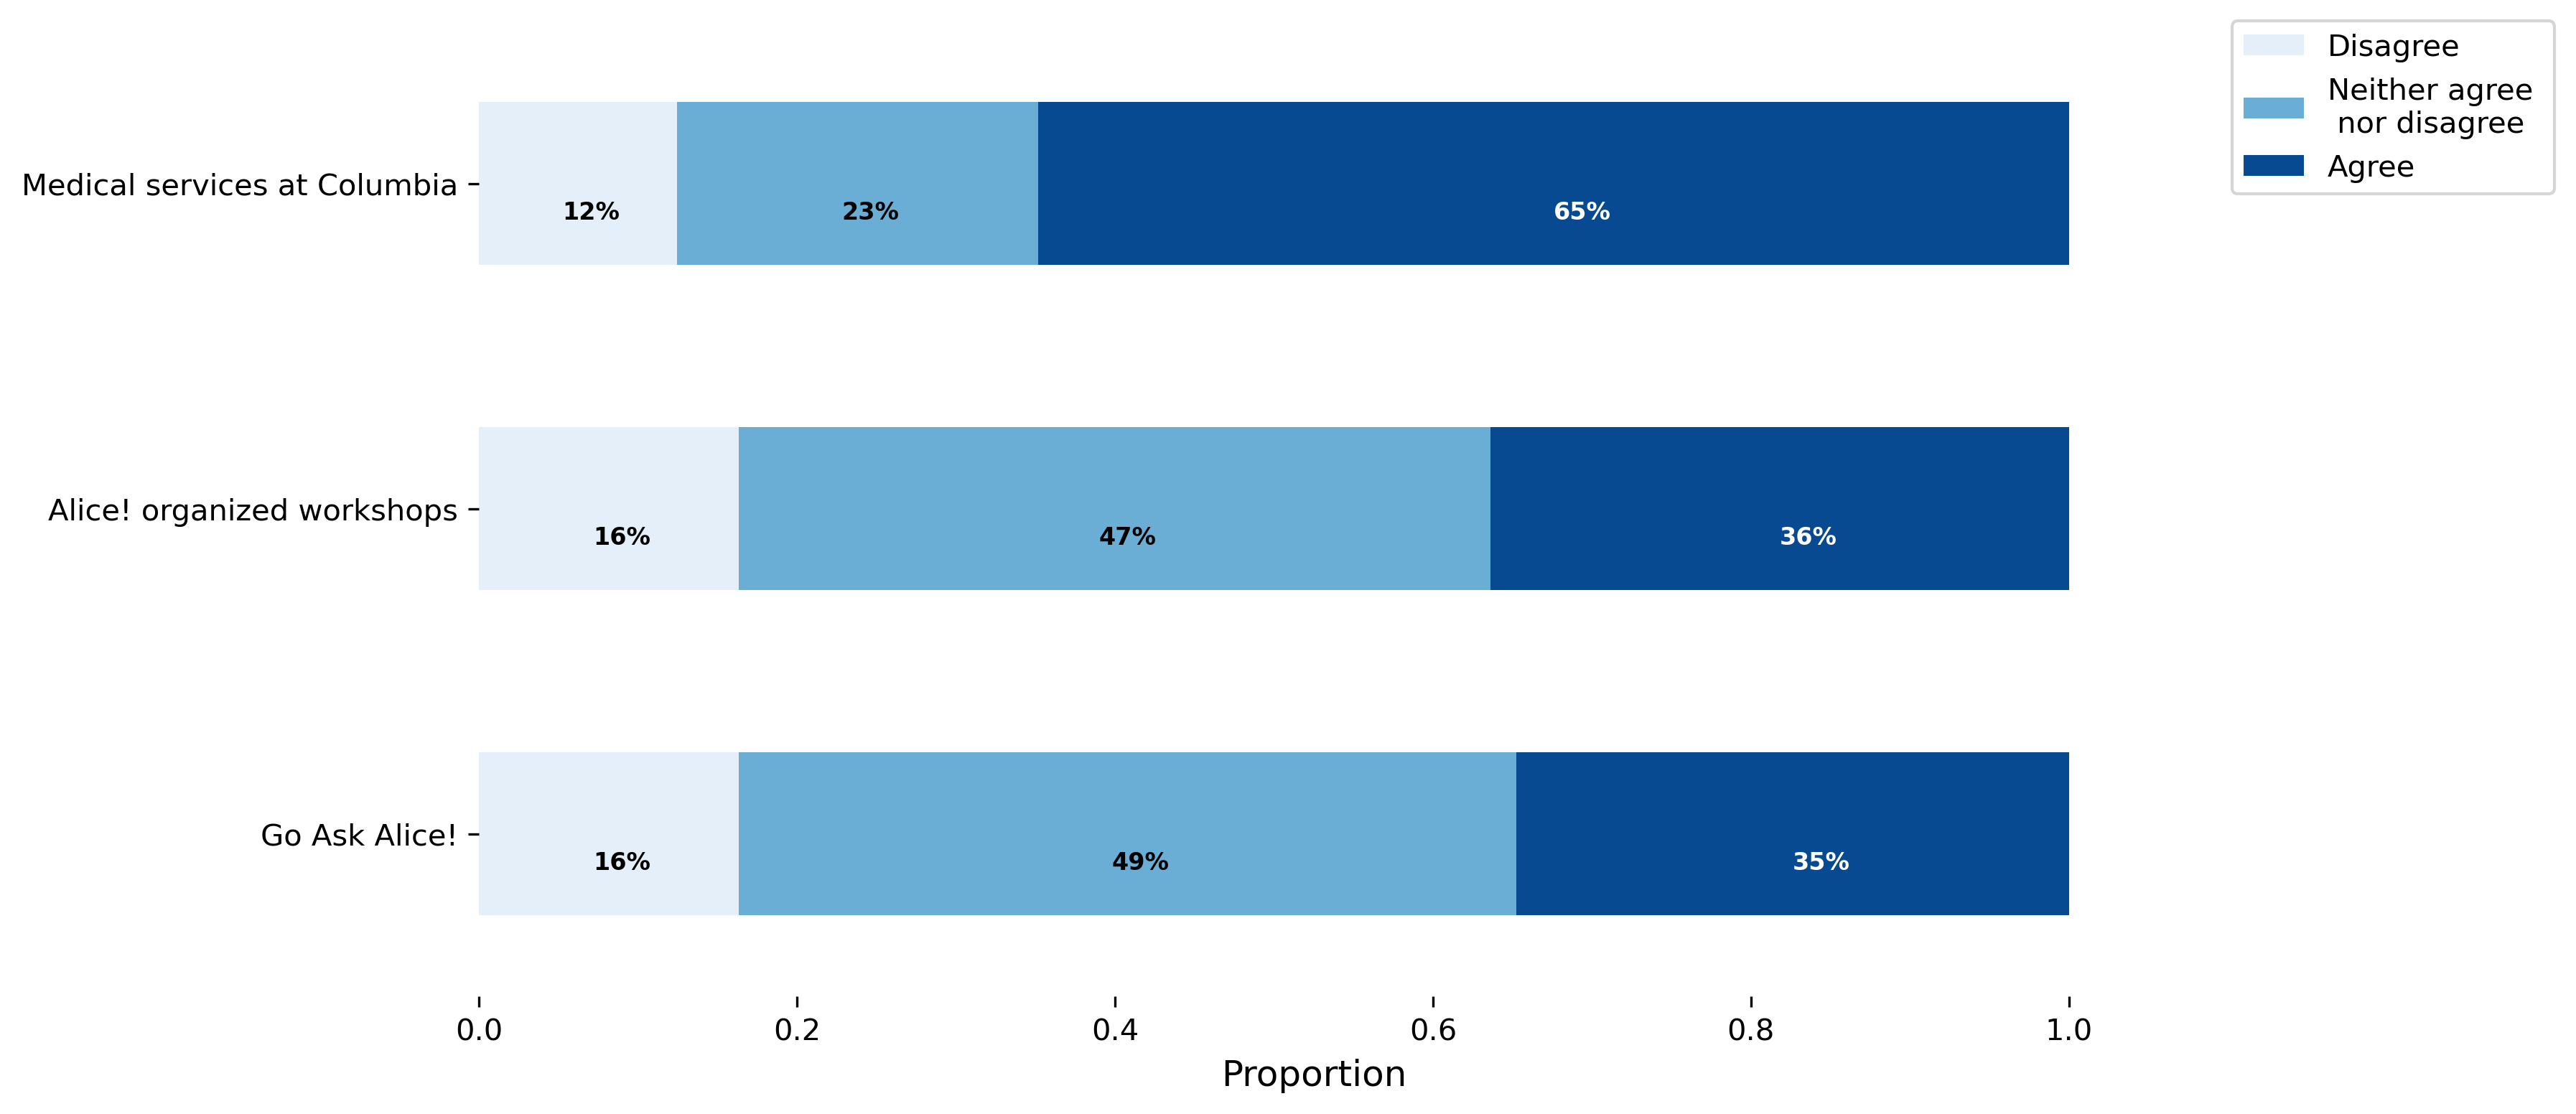

In [115]:
plot_3_cat(health_count)

In [42]:
health_count.sum()

Medical services at Columbia    995
Go Ask Alice!                   650
Alice! organized workshops      673
dtype: int64

In [163]:
query_data(Q,qq,d2019,"dental",indx=1)#.mean()

Have you ever deferred needed dental work while at Columbia due to lack of dental insurance?


Sexual Respect Website
0                         5
1                         3
3                         4
4                         5
5                         4
...                     ...
1028                      1
1029                      4
1030                    NaN
1031                      1
1032                      4

[997 rows x 1 columns]

In [139]:
insurance = query_data(Q,qq,cleaned_data,"insurance",indx=1)
insurance[~insurance.isin(['Not Applicable'])].mean()

I am satisfied with the Columbia health insurance Plan.


Response.32    3.032877
dtype: float64

In [56]:
hs_com = query_data(Q,qq,cleaned_data,"health services",indx=1).dropna()
hs_com.value_counts()

Please enter any additional comments regarding health services at Columbia


Open-Ended Response.11                                                                                                                                                                                                                                                                                      
too expensive                                                                                                                                                                                                                                                                                                   2
#NAME?                                                                                                                                                                                                                                                                                                          1
The health center doesn’t take other insurance which is ridiculous, I can’t use the hea

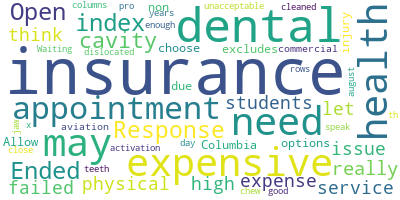

In [57]:
(hs_com).reset_index(inplace=True)
long_string = (str((hs_com)))
long_string = long_string.replace('libraries','library')
long_string = long_string.replace('please','')
long_string = long_string.replace('make','')
long_string = long_string.replace('','')
wordcloud = WordCloud(background_color="white", max_words=1000, contour_width=3,random_state=2,  contour_color='skyblue')
wordcloud.generate(long_string)
    #path = f'../fig/Restaurant_{i}stars_wordcloud.png'
    #print(f"Word Cloud for {i} stars Restaurant")
fig = wordcloud.to_image()
display(fig)
    #fig.save(path)

In [231]:
sexres = (query_data(Q,qq,cleaned_data,"sexual",indx=0)).copy()#.value_counts())
sexres.replace(2,1,inplace=True)
sexres.replace(4,5,inplace=True)
sexres_count=sexres.apply(pd.value_counts,axis=0).copy()[::-1]

I think the following Sexual Response Initiative resources regarding sexual violence and gender-based misconduct awareness are effective.


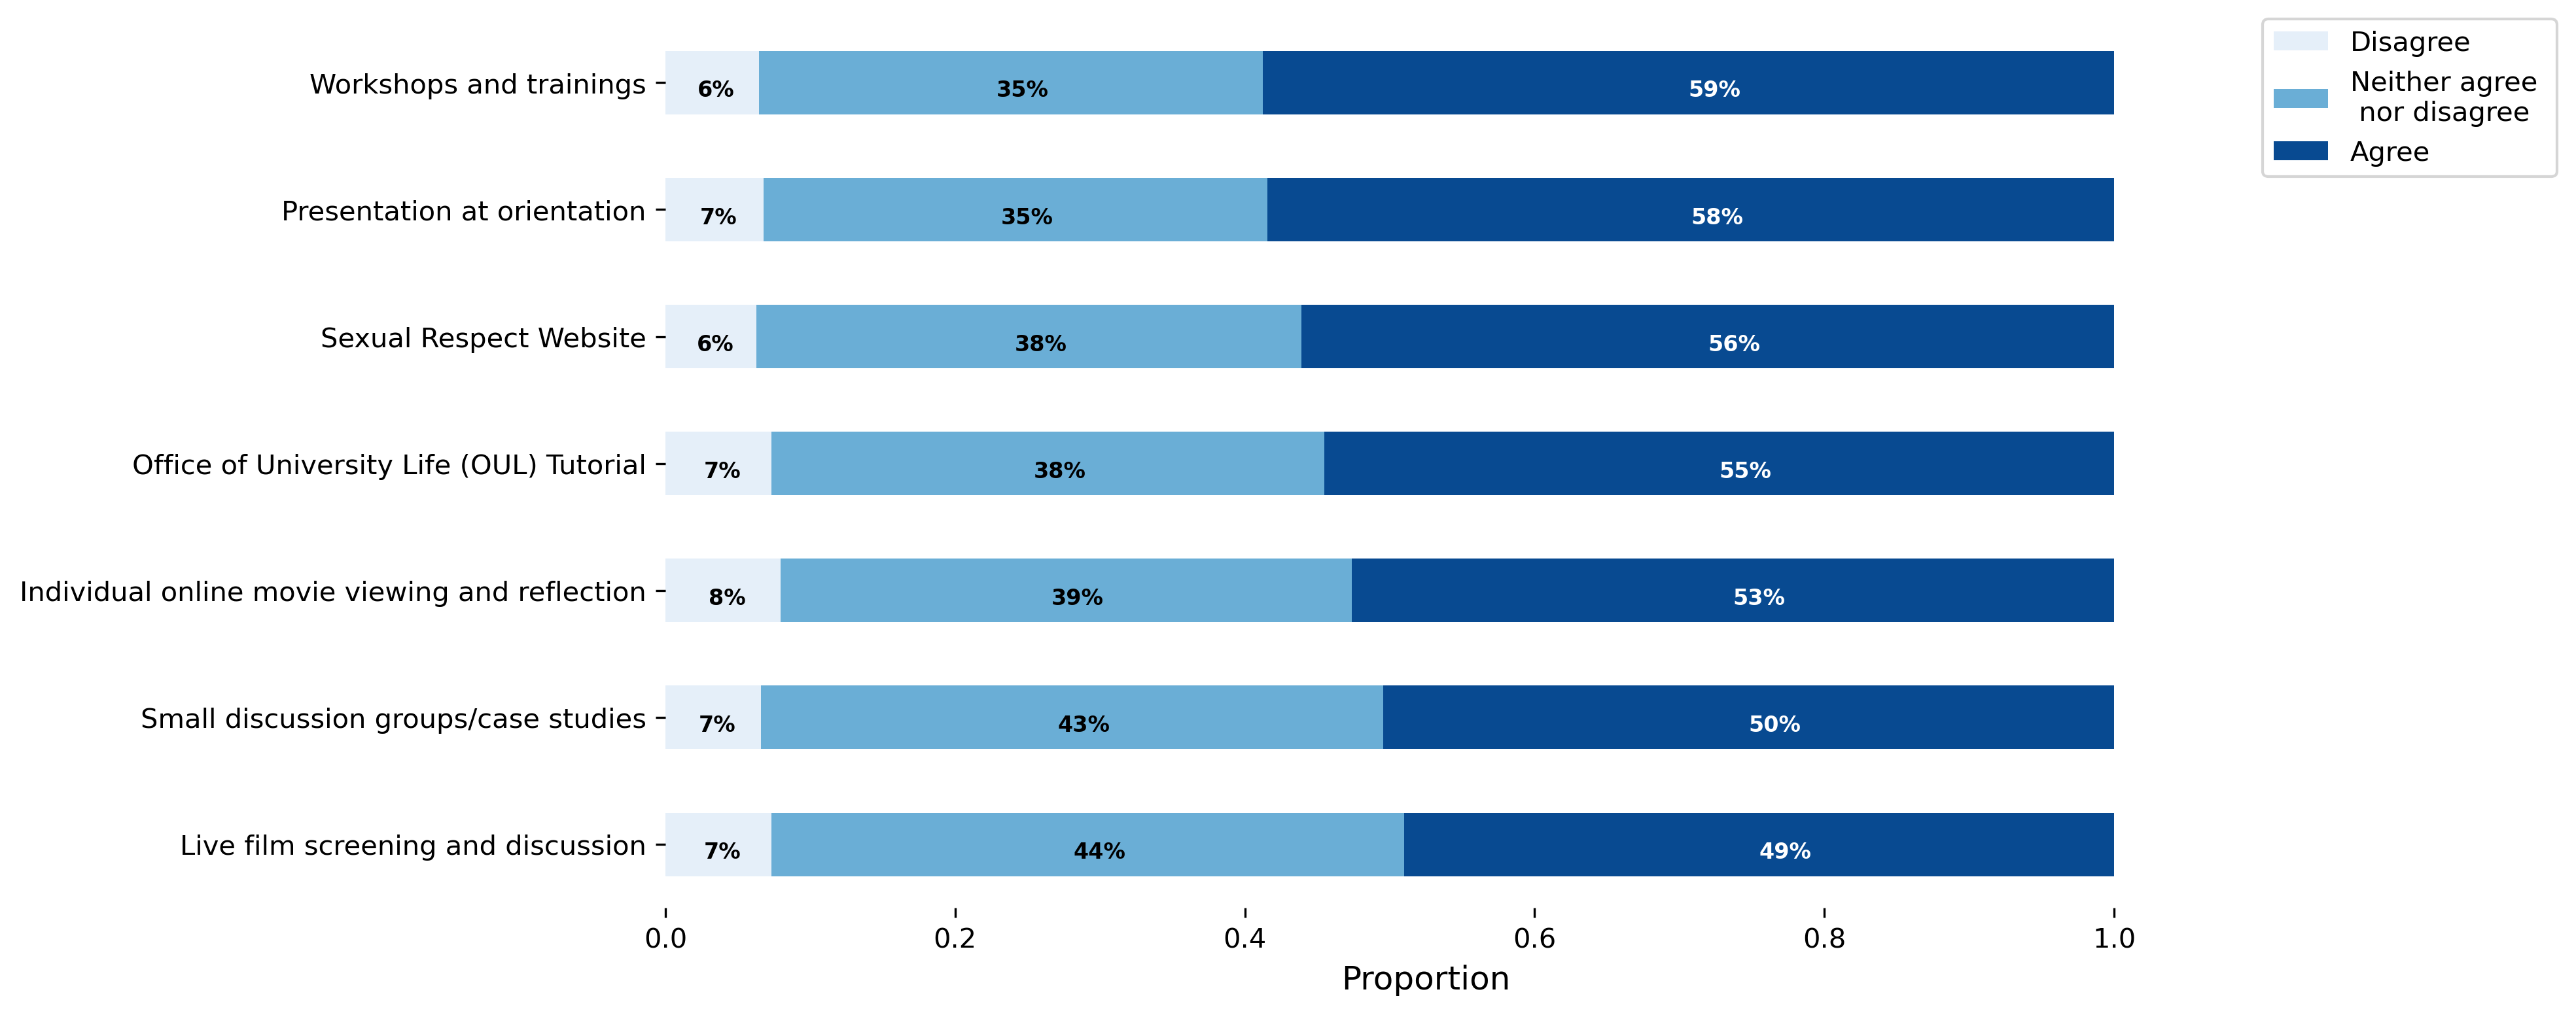

In [114]:
plot_3_cat(sexres_count)

In [117]:
sexres2 = (query_data(Q,qq,cleaned_data,"resources",indx=0))

Are you aware of the resources available at the following University offices?


In [126]:
#sexres2.replace(2,1,inplace=True)
#sexres2.replace(4,5,inplace=True)
sexres2_count=sexres2.apply(pd.value_counts,axis=0).copy()[::-1]
(sexres2_count).sum()

Gender-Based Misconduct Appeal Process             1271
SVR (Sexual Violence Response)                     1271
EOAA (Equal Opportunity and Affirmative Action)    1271
CPS (Counseling Psychology Services)               1271
dtype: int64

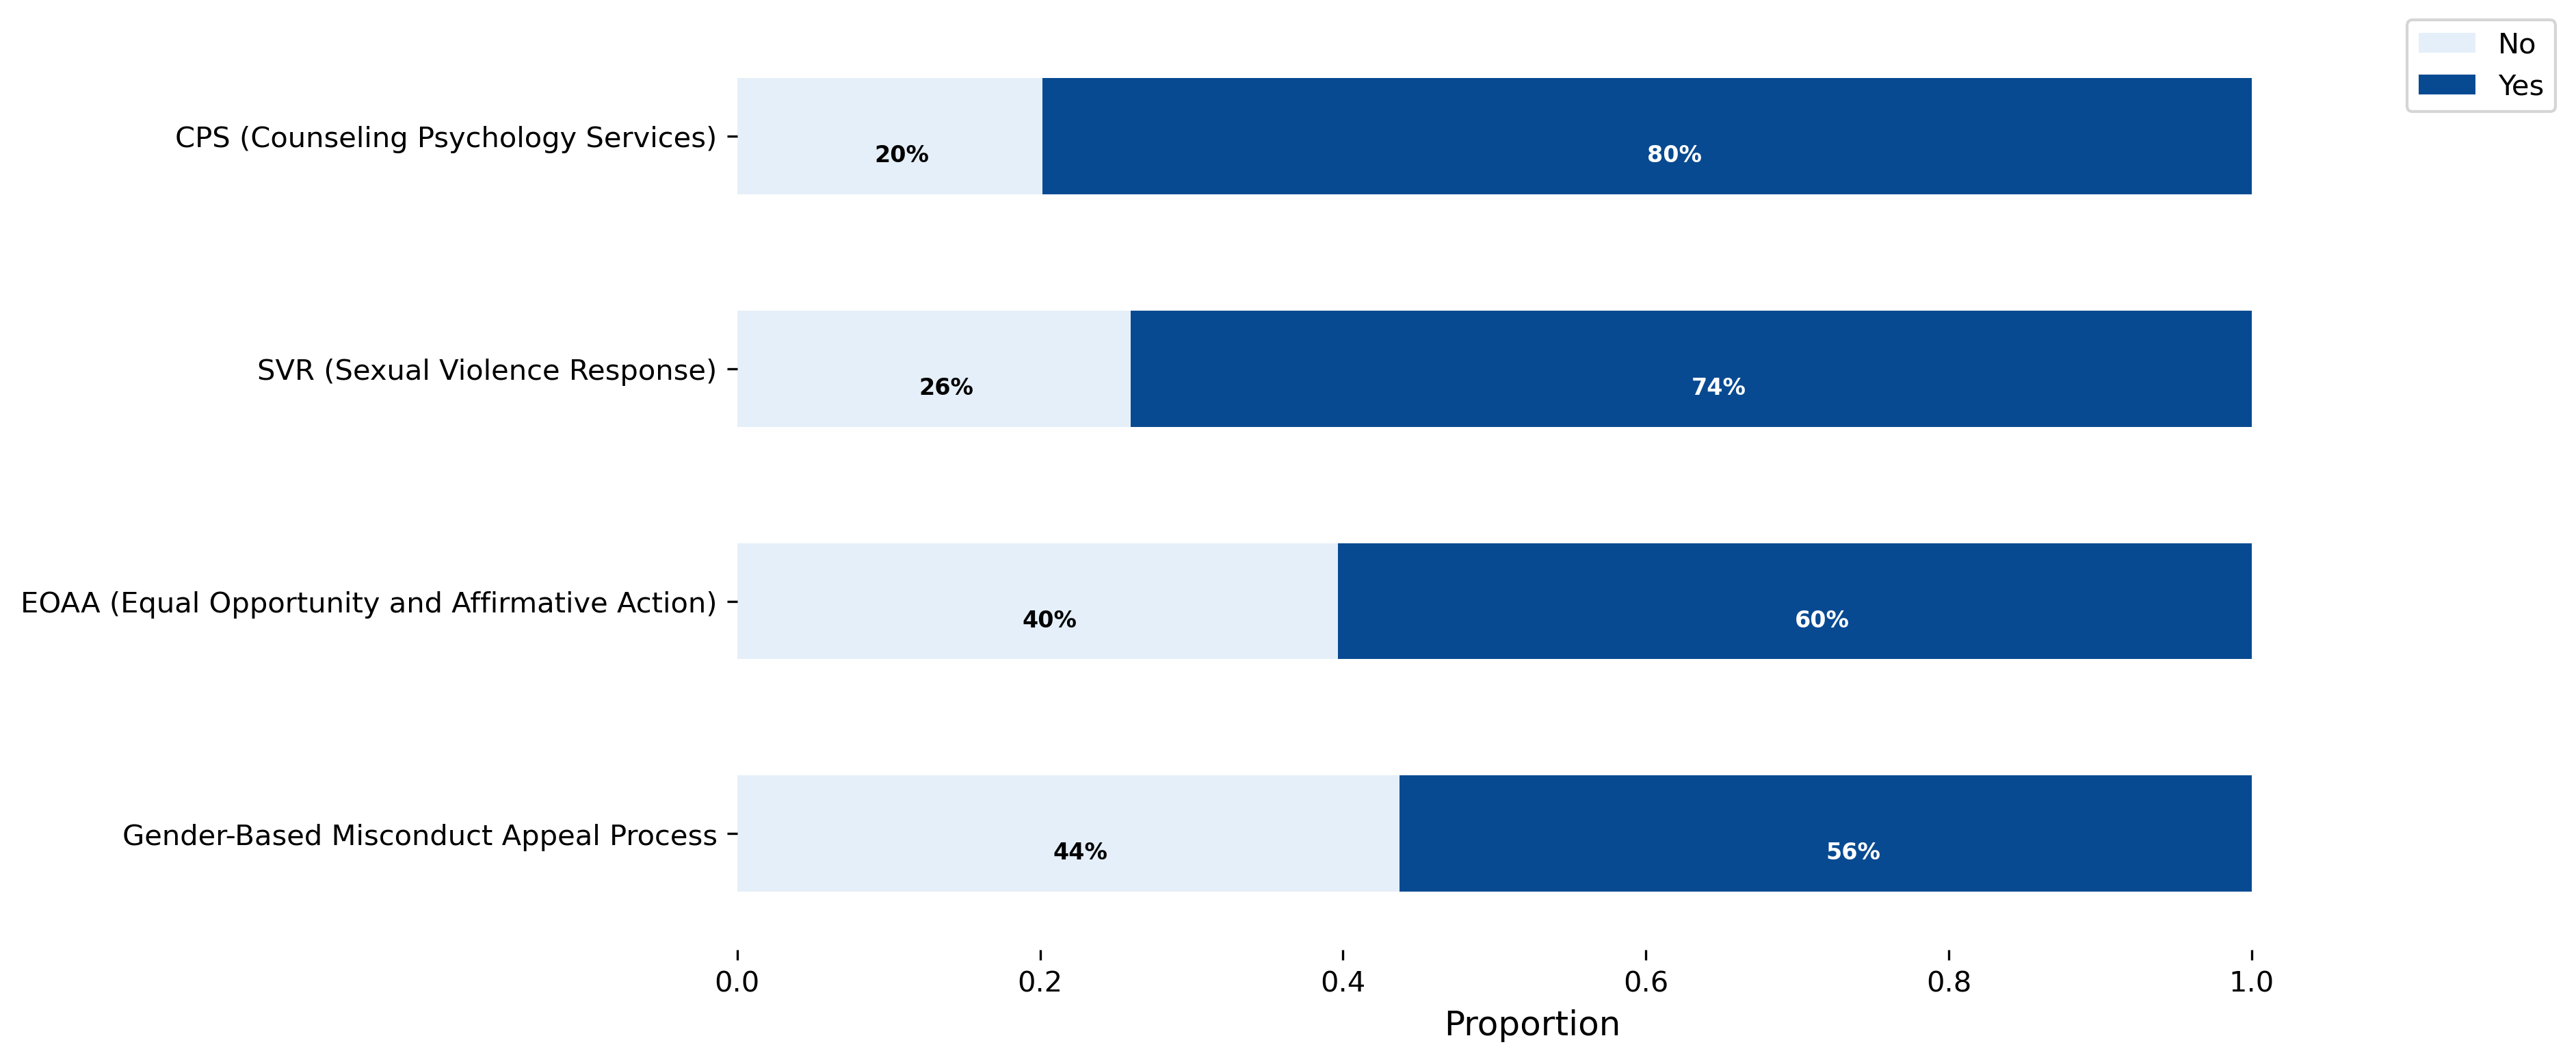

In [125]:
b_prob=(sexres2_count[(sexres2_count.iloc[1:,:].sum()).sort_values().index]).apply(lambda x: x / x.sum(), axis=0)
aaa=(sexres2_count[(sexres2_count.iloc[1:,:].sum()).sort_values().index]).T
bbb=b_prob.T

fig,ax=plt.subplots(figsize=(8,6),dpi=300)
b_prob.T.plot(kind='barh', stacked=True,colormap=cmap, figsize=(10, 6),ax=ax)
plt.legend(['Yes','No'][::-1],bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., ncol=1)
plt.xlabel("Proportion",fontsize=12)
for n, x in enumerate([*aaa.index.values]):
    m=1
    for (proportion, count, y_loc) in zip(bbb.loc[x],
                                      aaa.loc[x],
                                      bbb.loc[x].cumsum()):

        if m<1:
             plt.text(x=(y_loc - proportion) + (proportion / 2),
             y=n - 0.11,
             s=f'{str(np.round(proportion * 100)).split(".")[0]}%',
                      #s=f'{str(count).split(".")[0]}', 
             color="white",
             fontsize=8,
             fontweight="bold")
        if m>=1:

            plt.text(x=(y_loc - proportion) + (proportion / 2)-0.01,
             y=n - 0.11,
             s=f'{str(np.round(proportion * 100)).split(".")[0]}%',
                     #s=f'{str(count).split(".")[0]}', 
             color="black",
             fontsize=8,
             fontweight="bold")
        m-=1
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)


plt.show()

In [230]:
food = query_data(Q,qq,cleaned_data,"food",indx=0).copy()
food.replace(2,1,inplace=True)
food.replace(4,5,inplace=True)
food_count = (food).apply(pd.value_counts,axis=0).copy()

I have experienced the following in regards to my personal food situation:


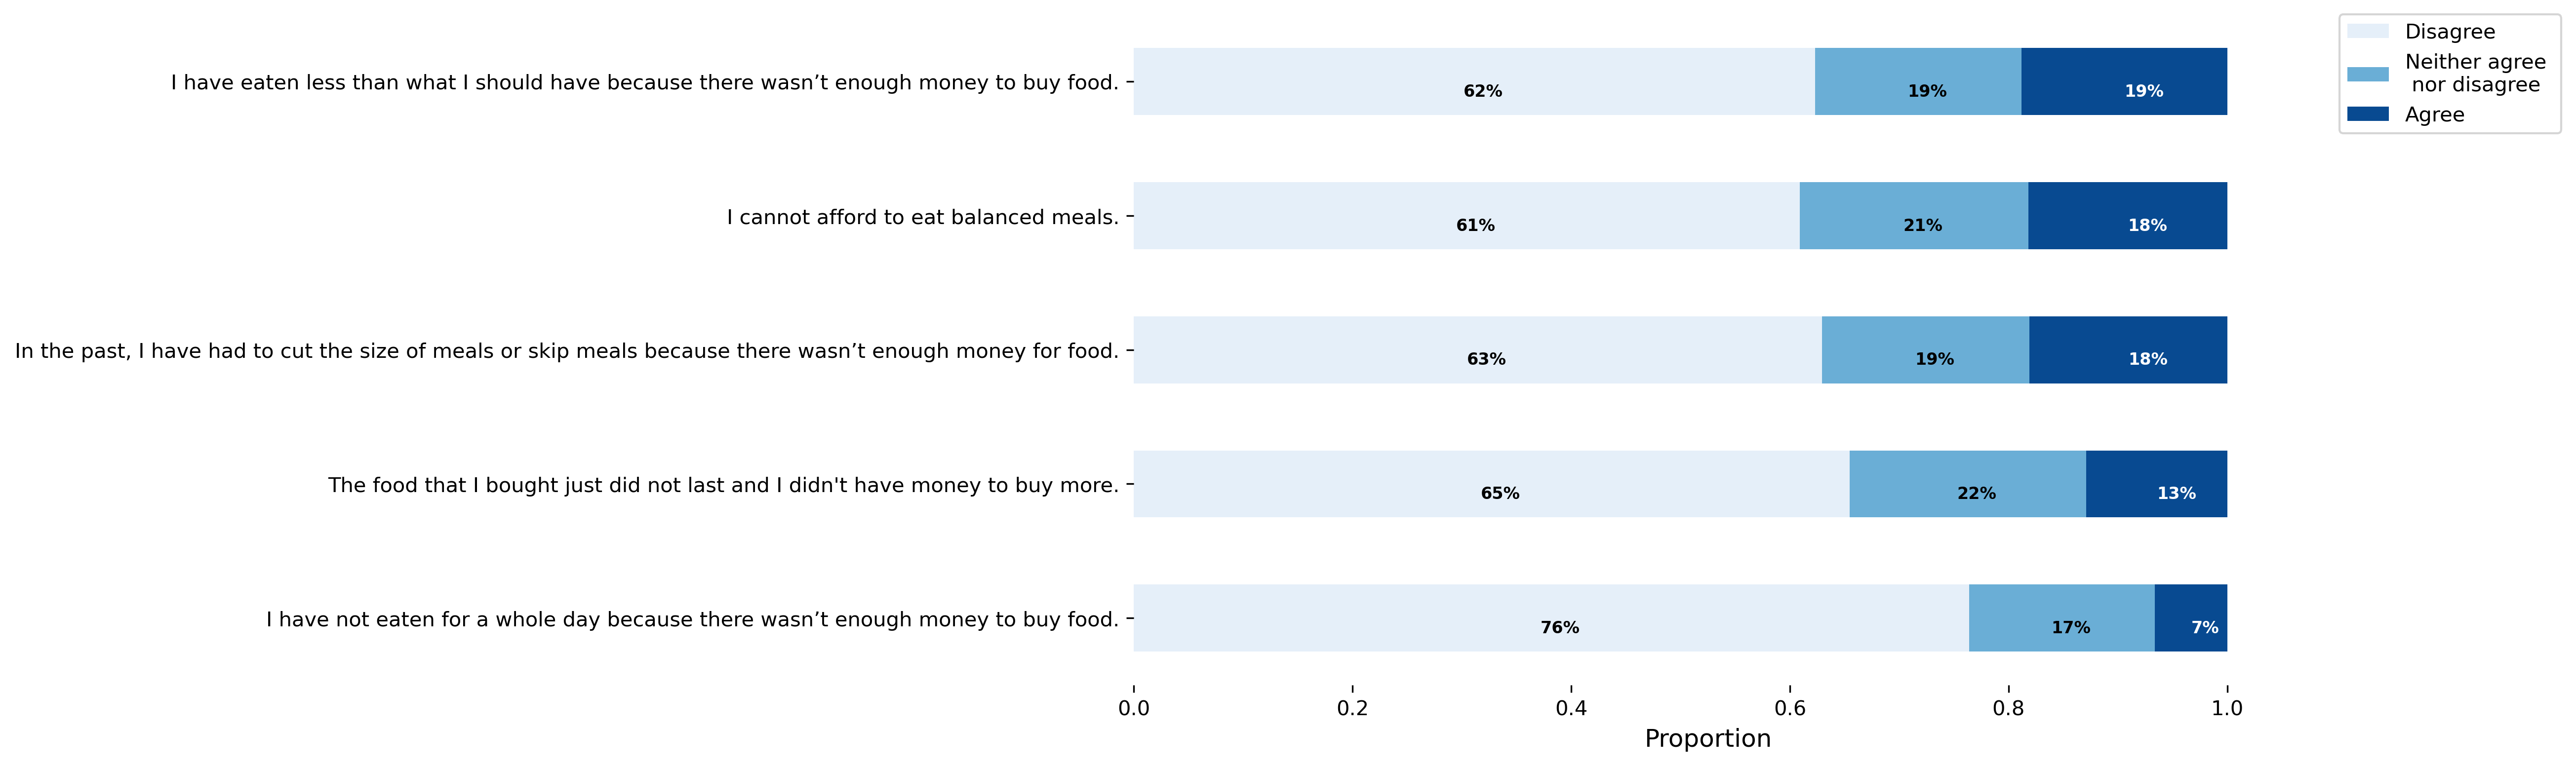

In [133]:
plot_3_cat(food_count)